# [Maureen] Inftrain ABX Analysis

## Includes bilingual data

In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'

* Functions definition

In [2]:
def retrieve_scores( size= [50,100, 200, 400, 800, 1600, 3200], abx_type="both", easyfilter = False, models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/checkpoints/inftrain'):
    fam_dict={}

    #columns = fam_id 	size 	eval_lang 	en_model 	fr_model 	bil_totalsize_A 	bil_totalsize_B 	same 	different 	bil_langsize 	bil_totalsize 	mono_avg (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]

    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :

            for eval_lang in ['en','fr']:
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    
                    if model == "EN" or model == "FR" :
                        
                        path = os.path.join(models_path,model,str(s)+"h",fam,"cpc_small/ABX_CV","**",eval_lang, "ABX_scores.json")
                        json_f = glob(path, recursive=True)
                        if easyfilter : 
                            json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                        else:
                            json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                        
                        if len(json_f) > 1:
                            json_f = [max(json_f, key=os.path.getctime)]

                        if not json_f :
                            score = np.nan
                        else:
                            with open(json_f[0], "r") as f:

                                scores = json.load(f)
                            if abx_type == "both" :
                                score = np.mean([scores['within'],scores['across']]) * 100
                            else :
                                score = scores[abx_type]*100
                        values.append(score)

                    elif model == "EN+FR" :
                        bil_scores = []
                        for bil_fam in [str(int(fam)*2).zfill(2), str((int(fam)*2) + 1).zfill(2)] :
                            path = os.path.join(models_path,model,str(s)+"h",bil_fam,"cpc_small/ABX_CV","**",eval_lang, "ABX_scores.json")
                            json_f = glob(path, recursive=True)
                            
                            
                            if easyfilter : 
                                json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                            else:
                                json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                                                        
                            if len(json_f) > 1:
                                
                                json_f = [max(json_f, key=os.path.getctime)]

                            if not json_f :
                                score = np.nan
                            else:
                                with open(json_f[0], "r") as f:
                                    scores = json.load(f)
                                if abx_type == "both" :
                                    score = np.mean([scores['within'],scores['across']]) * 100
                                else :
                                    score = scores[abx_type]*100 
                                    
                            values.append(score)
                            
                            #below add langsize
                            if fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict :
                                fam_dict[bil_fam+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                        
                    if model == "EN" and eval_lang == "en" :
                        same = score
                    elif model == "EN" and eval_lang == "fr" :
                        different = score
                    elif model == "FR" and eval_lang == "fr" :
                        same = score
                    elif model == "FR" and eval_lang == "en" :
                        different = score

                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize_A", "bil_totalsize_B", 'same', 'different', "bil_langsize"])
    df['bil_totalsize'] = df[["bil_totalsize_A", "bil_totalsize_B"]].mean(axis=1)
    df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
    return df

## Retrieve ABX scores & datasets

*MDS - Todo : add lambda function to systematically retrieve latest checkpoint ABX score*

1. df_within : original ABX scores calculated "within speaker"
2. df_across : original ABX scores calculated "across speakers"
3. df_ef_within : "easyfilter" ABX scores calculated "within speaker"
4. df_ef_across : "easyfilter" ABX scores calculated "across speakers"


The "easyfilter" abx scores correspond, for the french scores, to the scores calculated on the "quickfix" item files (see [Google Document](https://docs.google.com/document/d/1XoGX52rBFOwue2twX02IuEhO_-ZktSZh-qdvpuBqK3I/edit?usp=sharing)). The english scores are the same as the original ones. 

In [3]:
abx_type="both"
abx_type="within"


df_within = retrieve_scores(abx_type="within")
df_within_size = df_within.groupby(by="size").mean()

df_across = retrieve_scores(abx_type="across")
df_across_size = df_across.groupby(by="size").mean()

err_within=df_within.groupby('size').std()
err_across=df_across.groupby('size').std()

In [4]:
df_within

fam_id  size eval_lang   en_model   fr_model  bil_totalsize_A  \
00_en_50       00    50        en  14.267050  15.219505              NaN   
00_fr_50       00    50        fr  15.032649  14.534754              NaN   
01_en_50       01    50        en  14.509746  15.411201              NaN   
01_fr_50       01    50        fr  14.989951  14.412789              NaN   
02_en_50       02    50        en  15.167840  15.652916              NaN   
...           ...   ...       ...        ...        ...              ...   
00_fr_1600     00  1600        fr  12.264634  11.465147        11.725300   
01_en_1600     01  1600        en  10.490447  12.914965        11.321610   
01_fr_1600     01  1600        fr  11.815779  11.653051        12.167590   
00_en_3200     00  3200        en  10.069969  12.300677        10.809671   
00_fr_3200     00  3200        fr  11.552946  10.958823        10.713123   

            bil_totalsize_B       same  different  bil_langsize  \
00_en_50                NaN  14.267050  15.219505     14.341909   
00_fr_50                NaN  14.534754  15.032649     14.614822   
01_en_50                NaN  14.509746  15.411201     14.549951   
01_fr_50                NaN  14.412789  14.989951     14.100266   
02_en_50                NaN  15.167840  15.652916     15.544102   
...                     ...        ...        ...           ...   
00_fr_1600        11.974081  11.465147  12.264634     10.713123   
01_en_1600        11.706240  10.490447  12.914965     11.110011   
01_fr_1600        11.975791  11.653051  11.815779     11.395957   
00_en_3200        11.110011  10.069969  12.300677           NaN   
00_fr_3200        11.395957  10.958823  11.552946           NaN   

            bil_totalsize   mono_avg  
00_en_50              NaN  14.743277  
00_fr_50              NaN  14.783701  
01_en_50              NaN  14.960474  
01_fr_50              NaN  14.701370  
02_en_50              NaN  15.410378  
...                   ...        ...  
00_fr_1600      11.849690  11.864891  
01_en_1600      11.513925  11.702706  
01_fr_1600      12.071691  11.734415  
00_en_3200      10.959841  11.185323  
00_fr_3200      11.054540  11.255885  

[254 rows x 12 columns]

# Figures

## A. Boxplots of ABX scores in function of training size for the different model types

### A1 - ABX across speakers - original
- Test set : average of French and English
- Df : Original

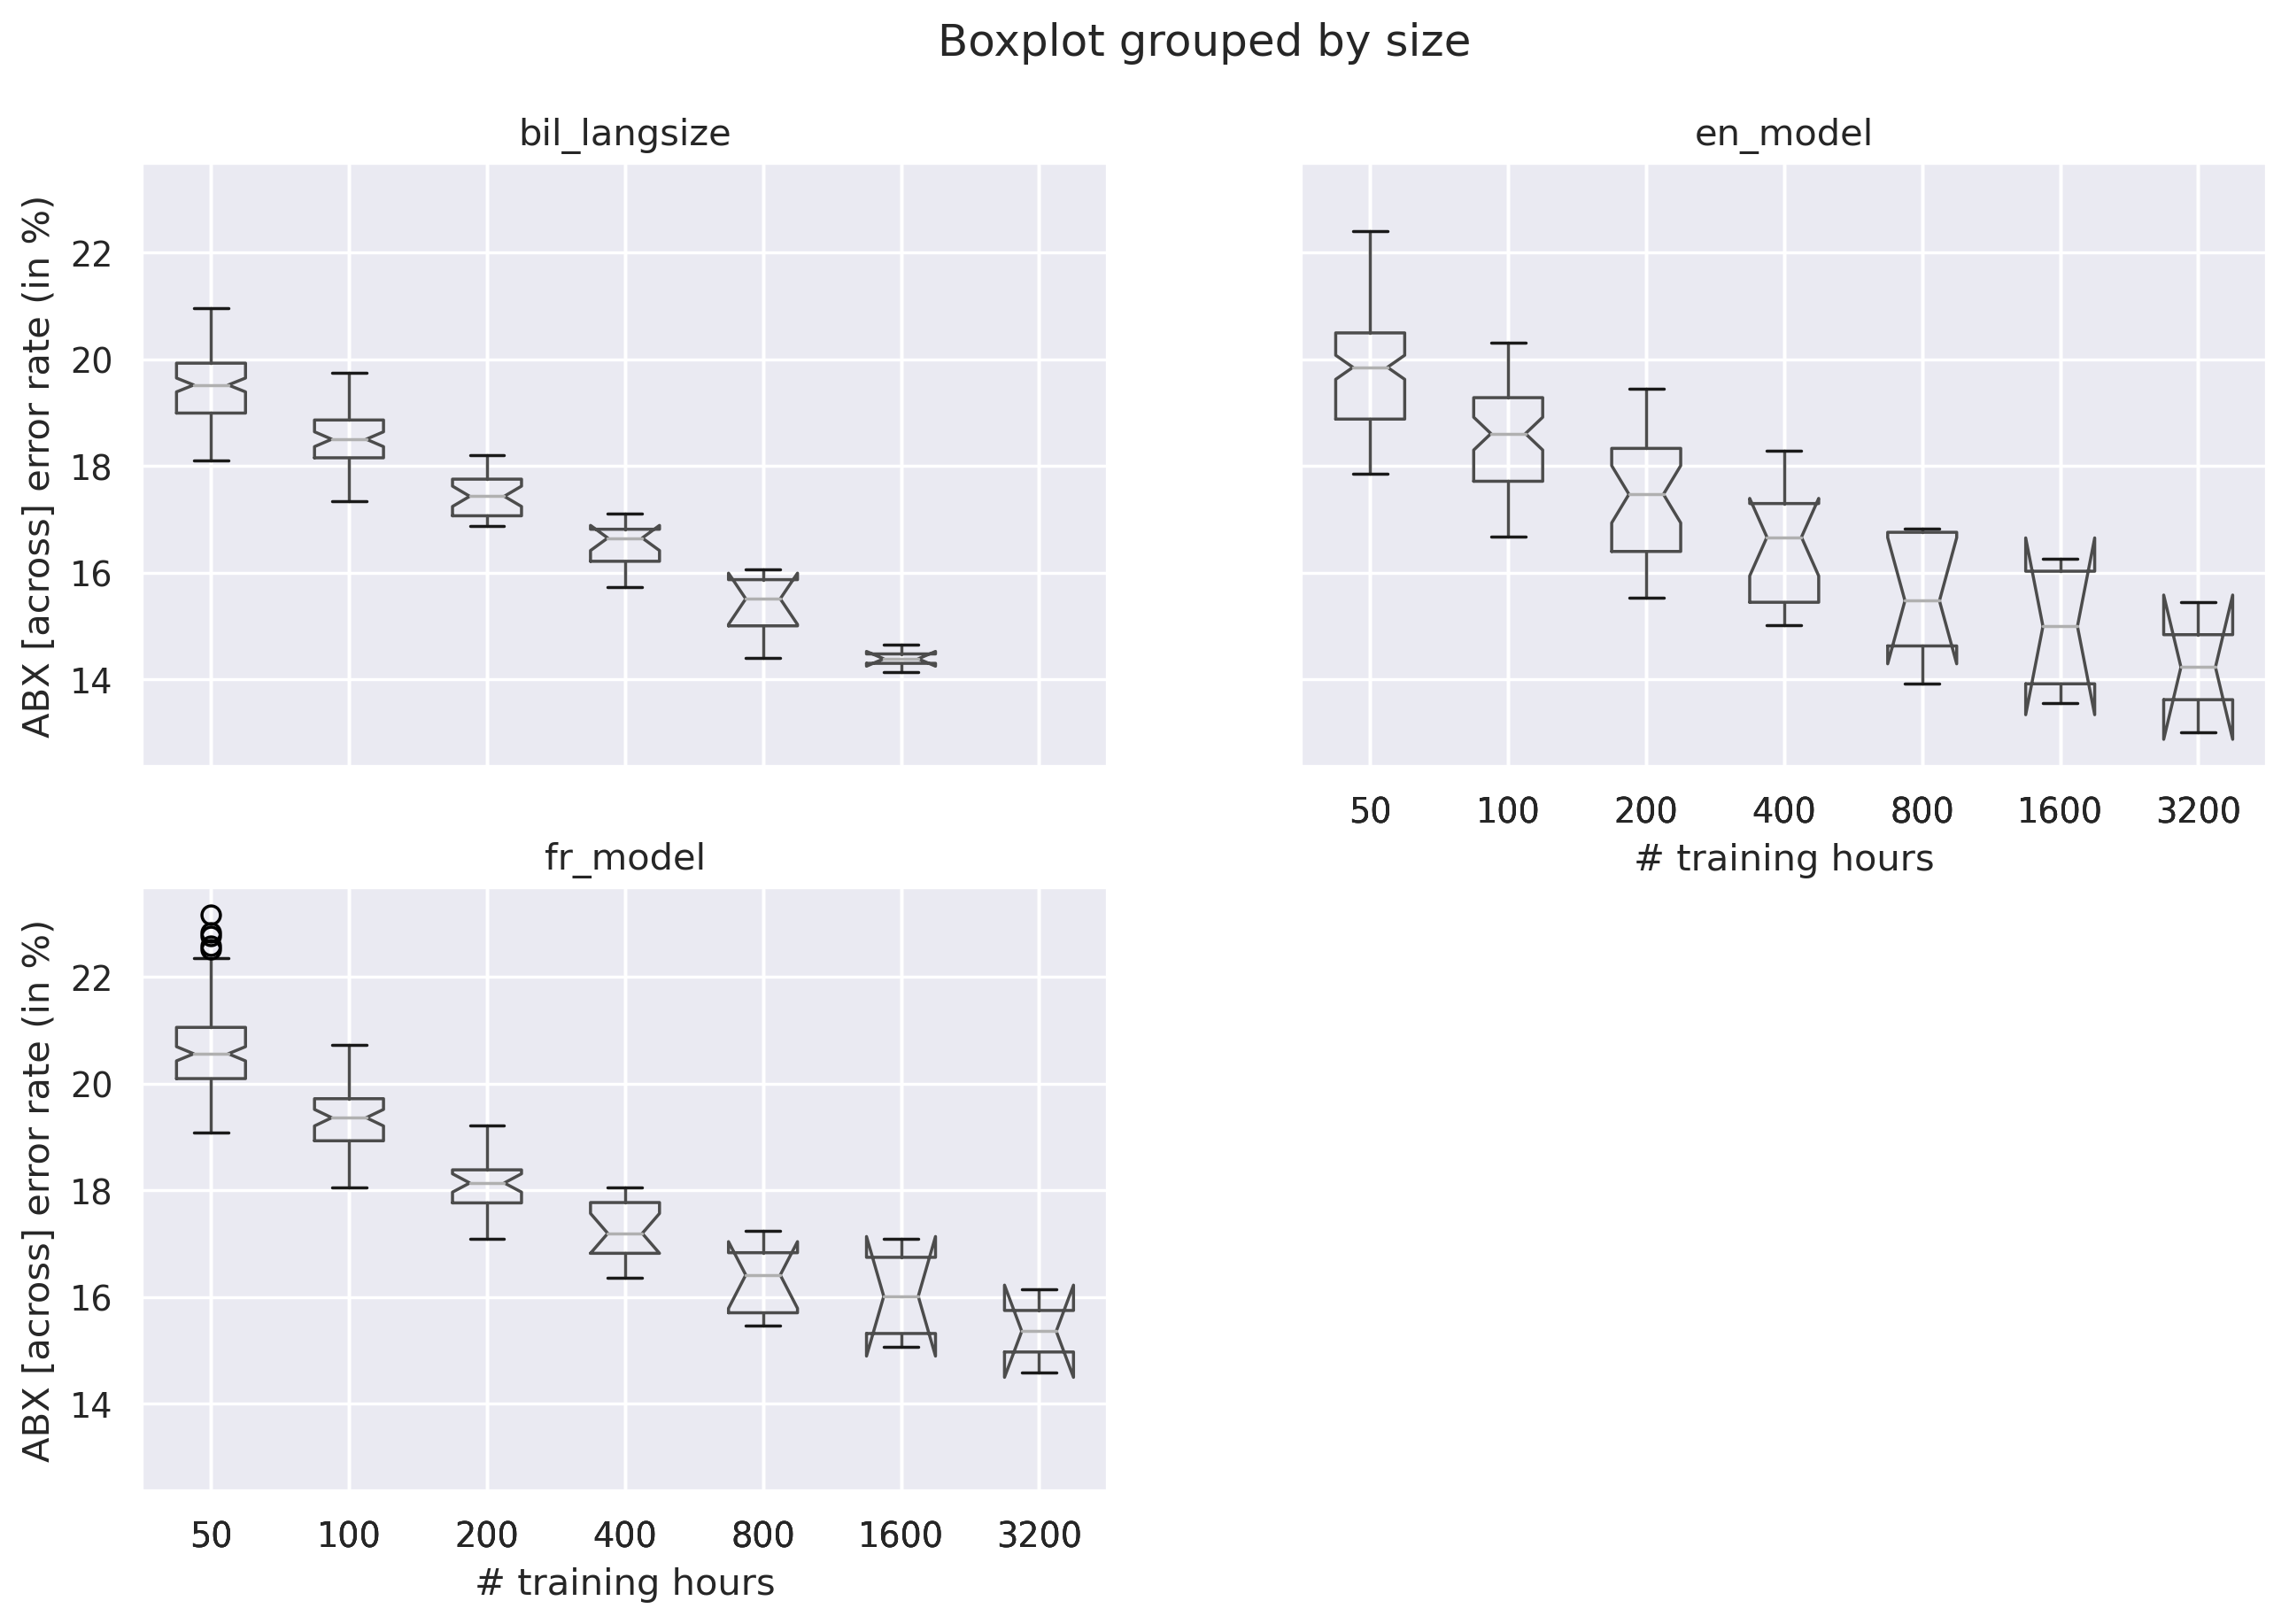

In [5]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [across] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

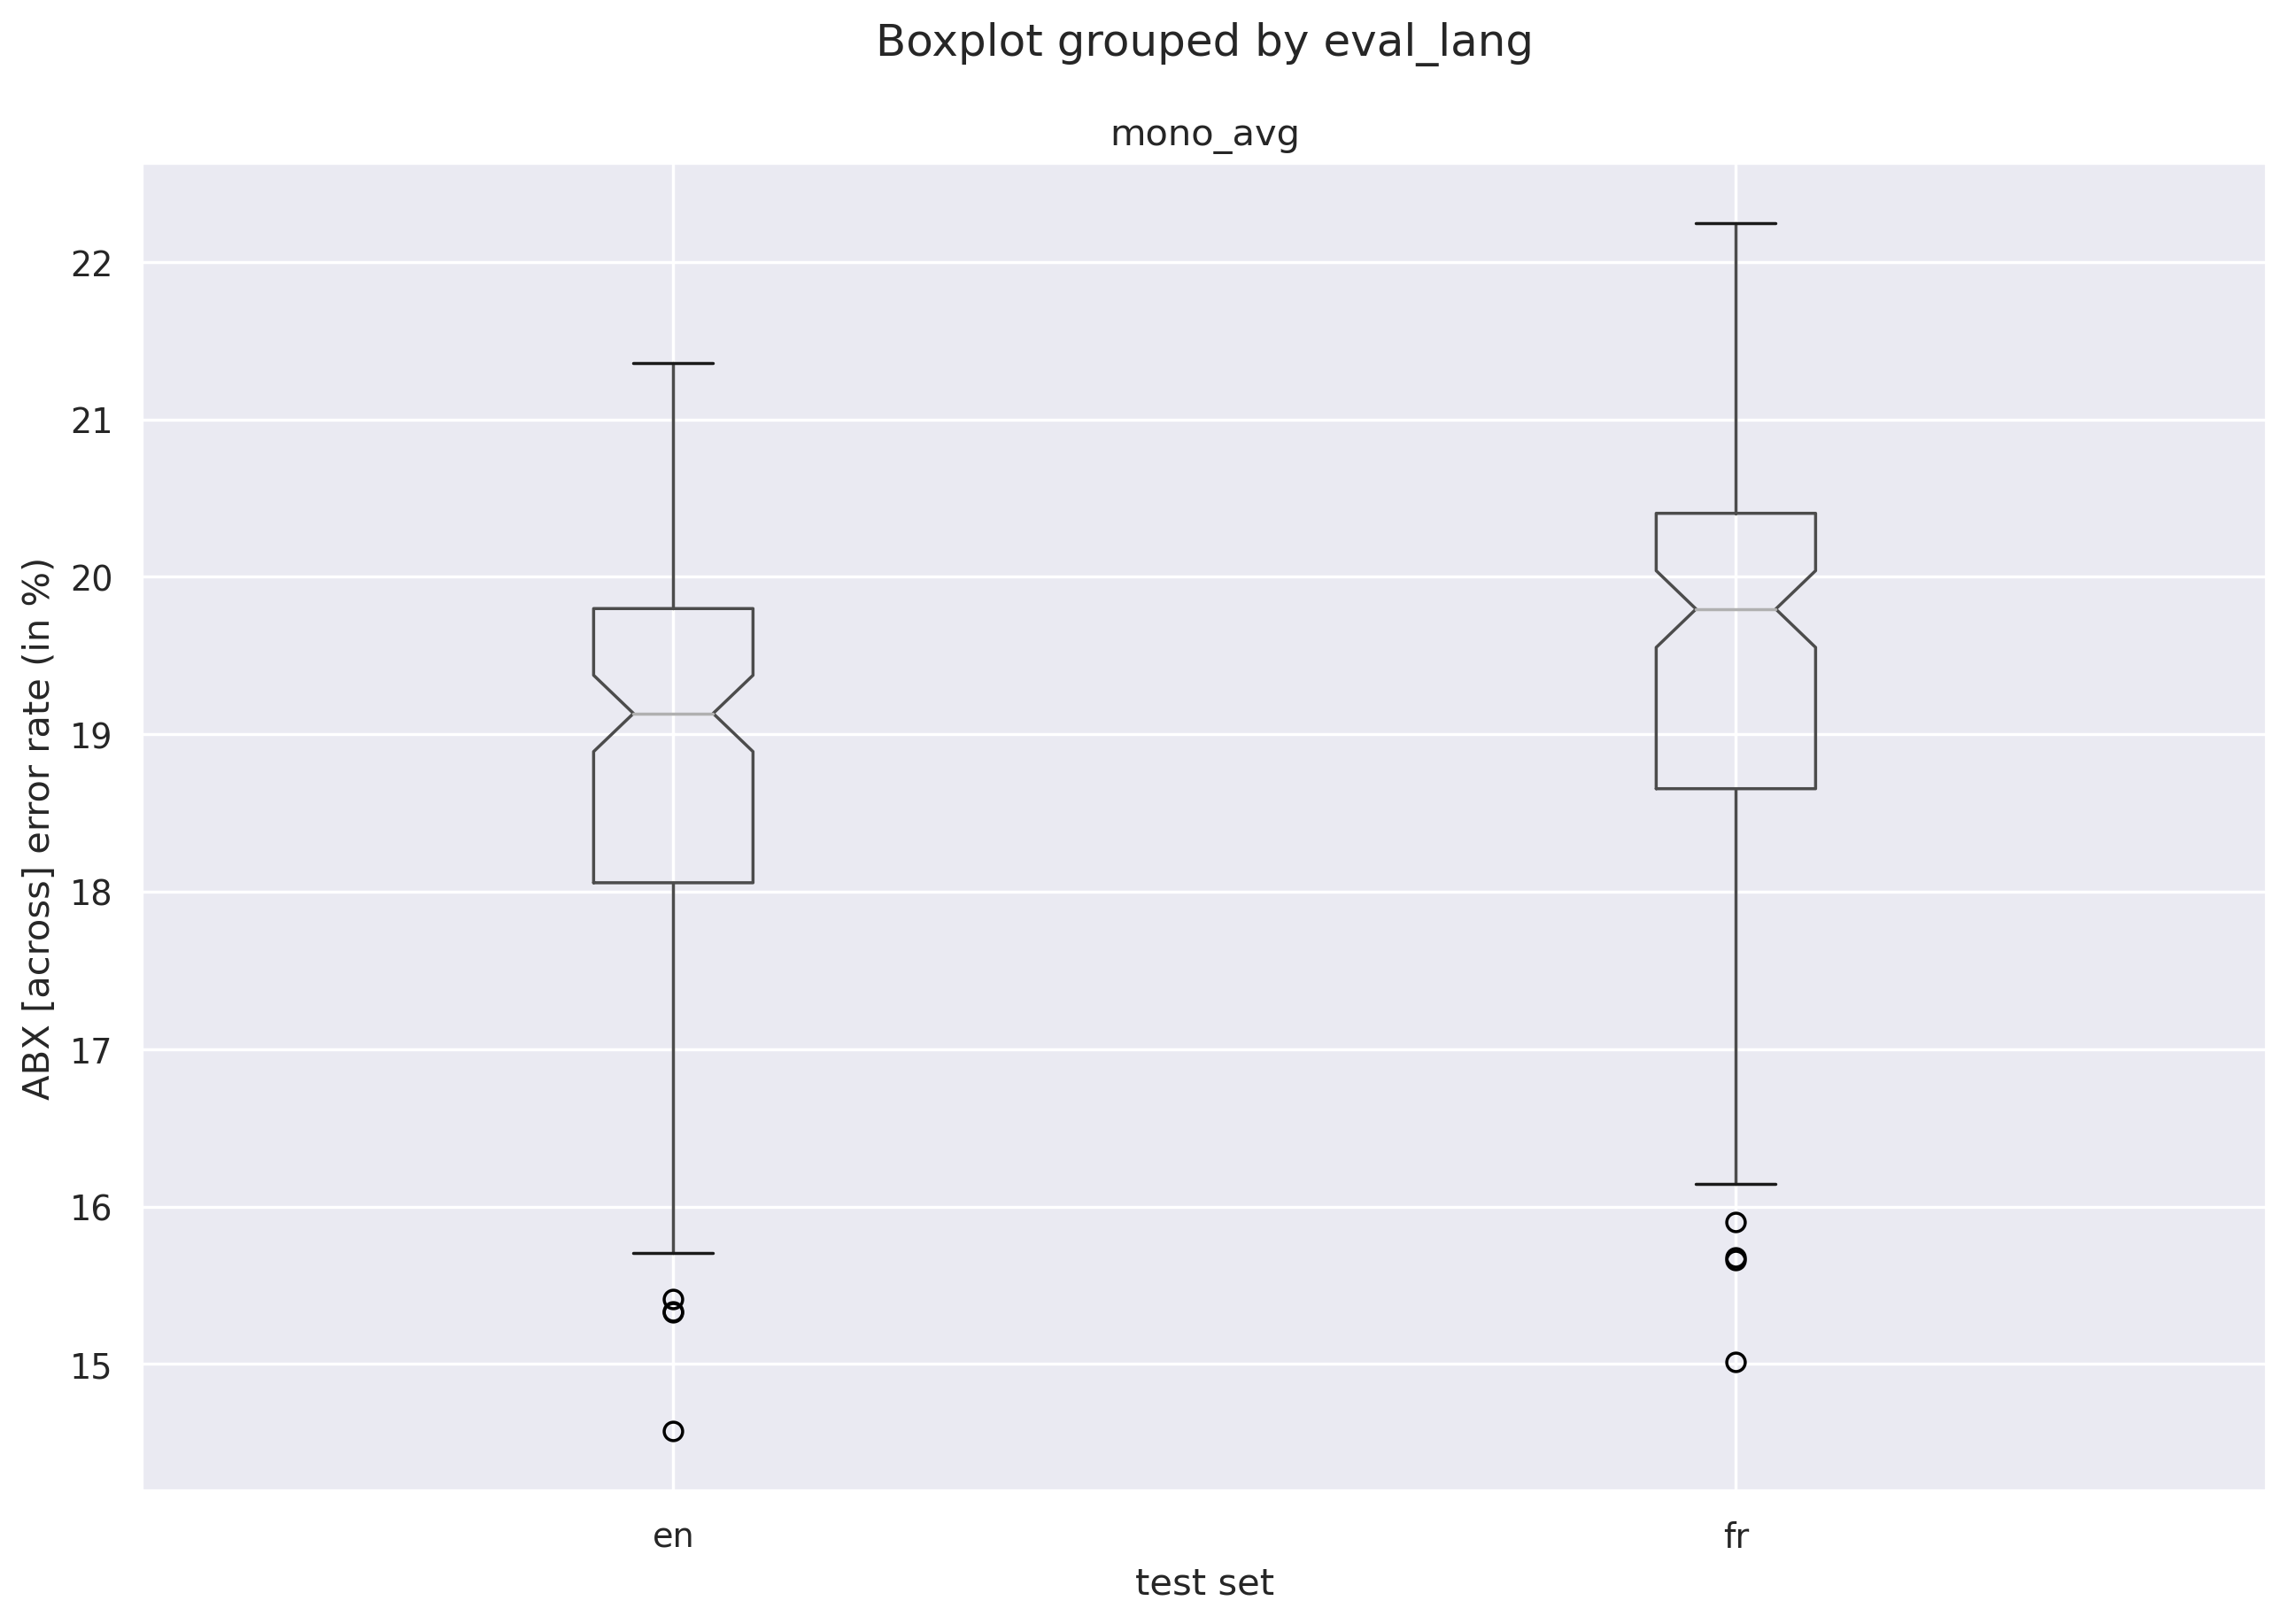

In [6]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [across] error rate (in %)')
plt.xlabel('test set')


### A2 - ABX within speakers  - original
- Test set : average of French and English
- Df : Original

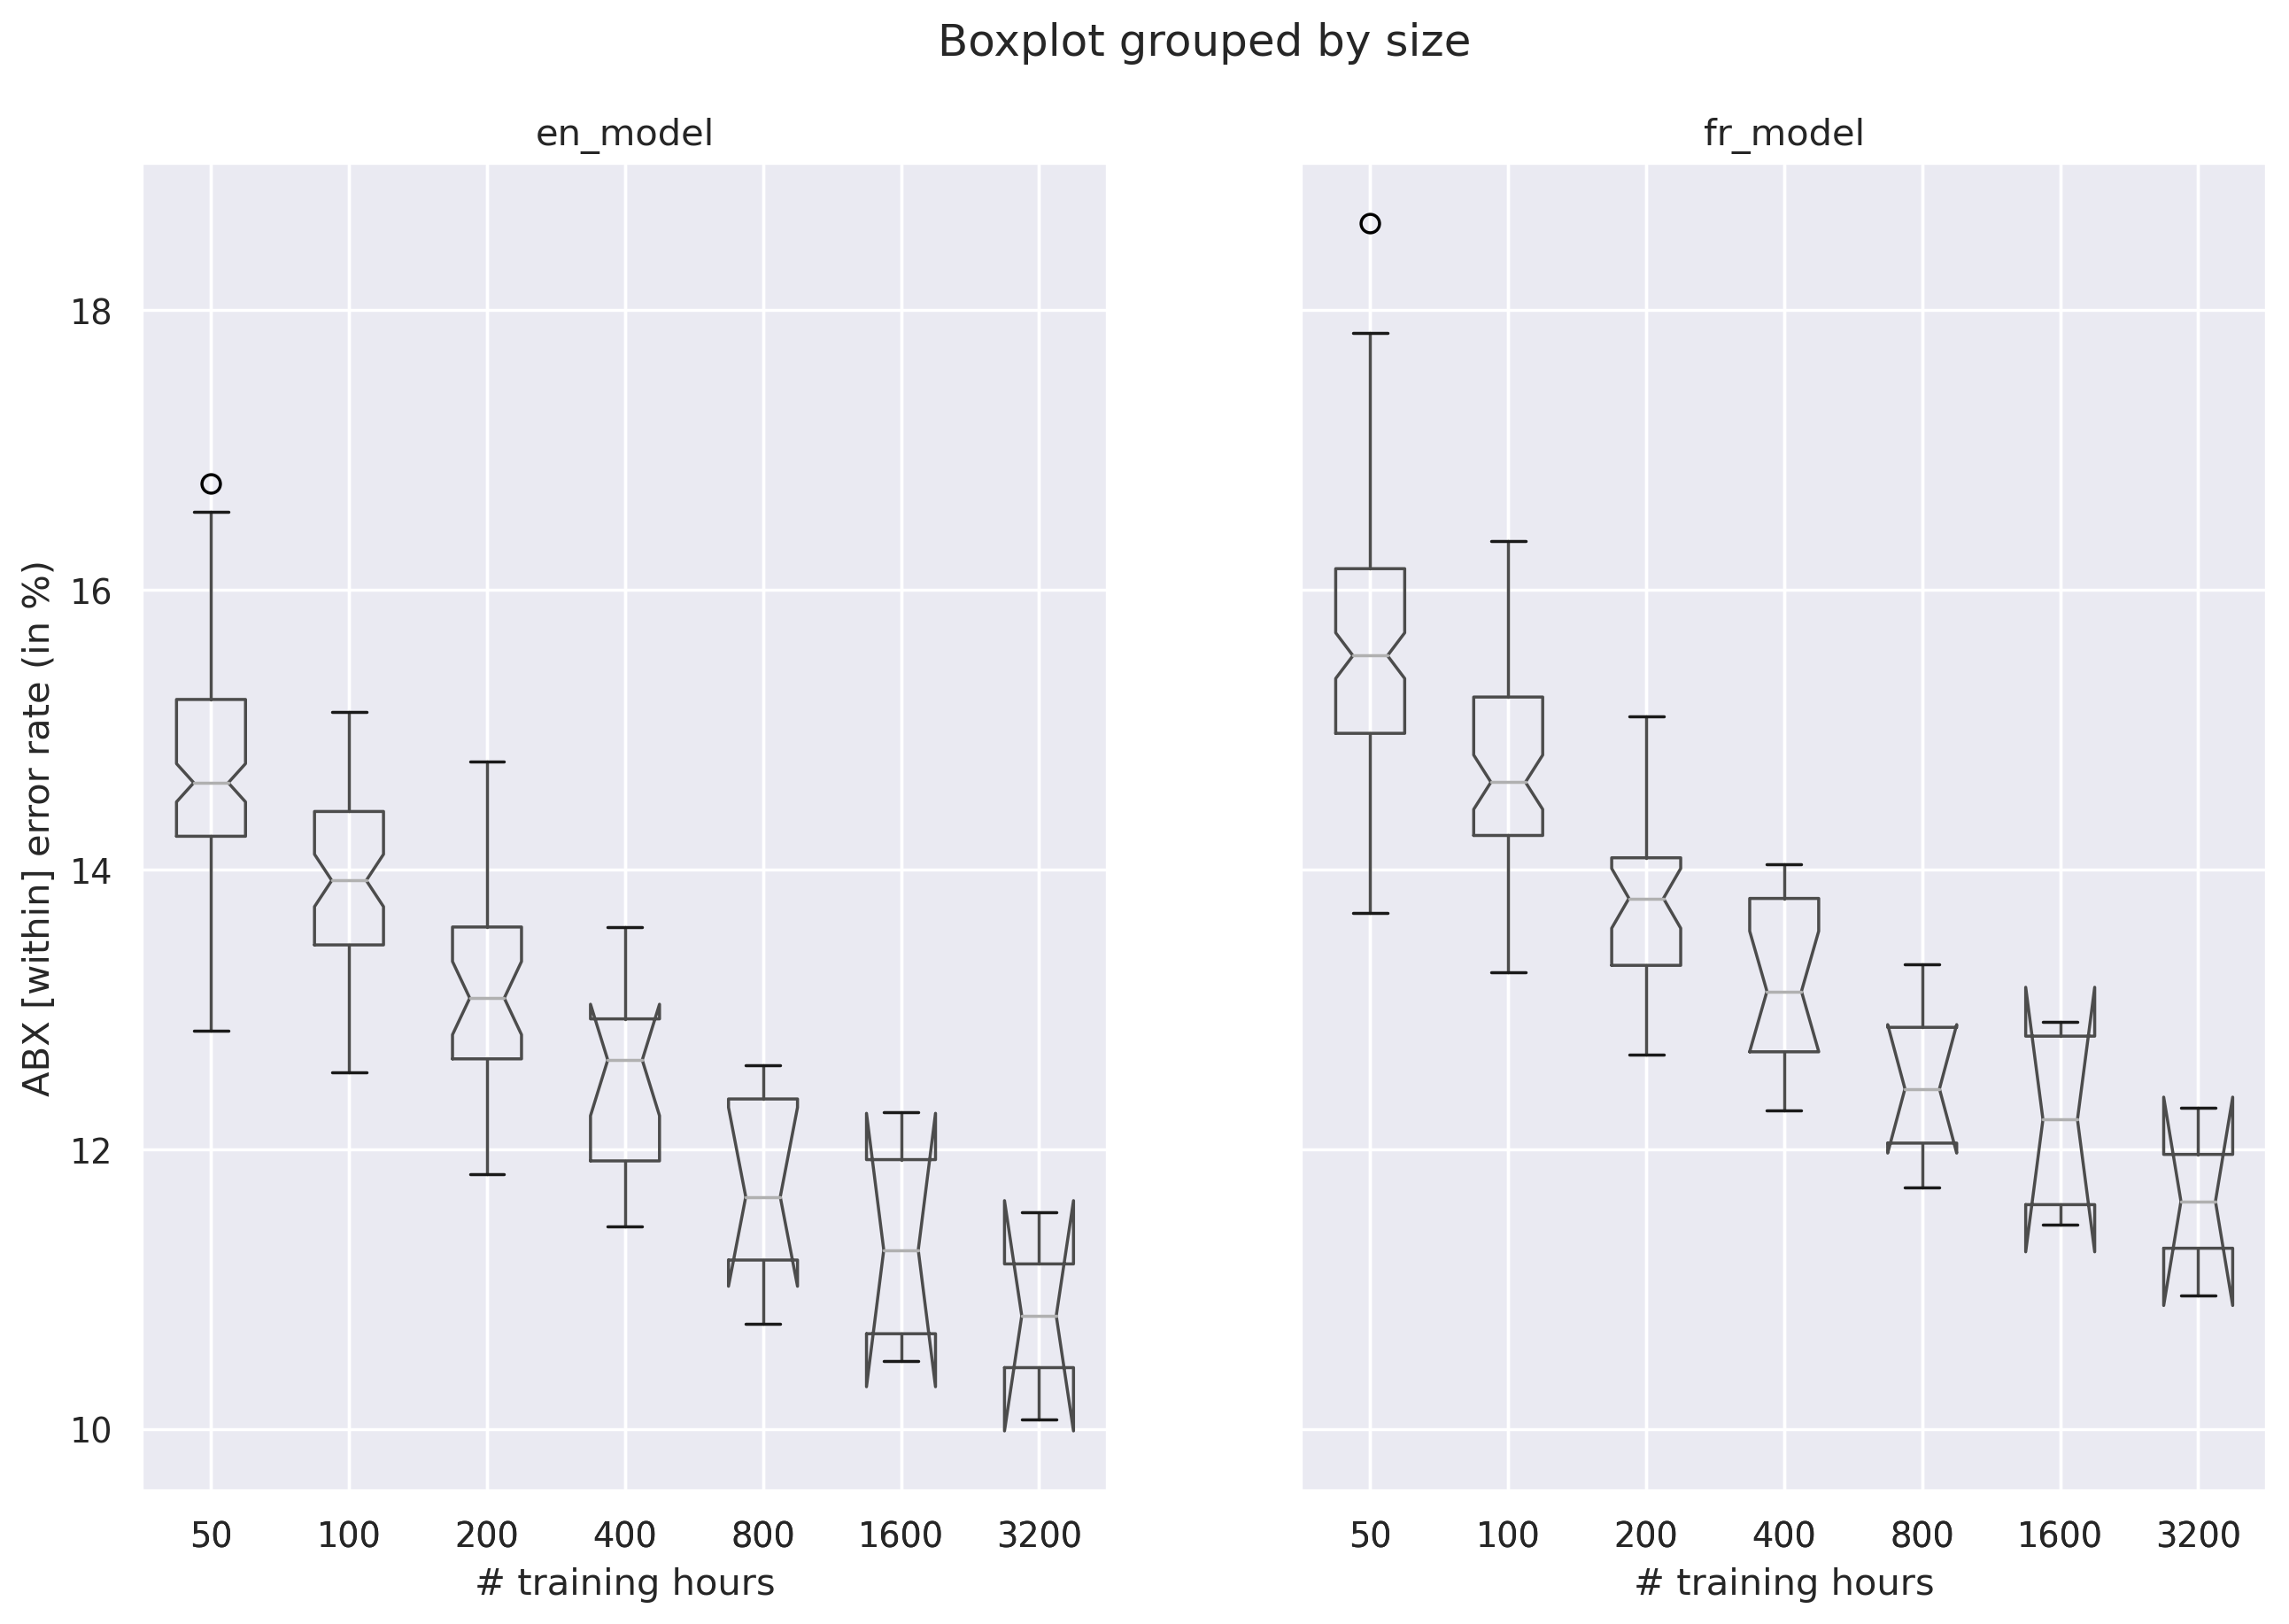

In [7]:
boxplot = df_within[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [within] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

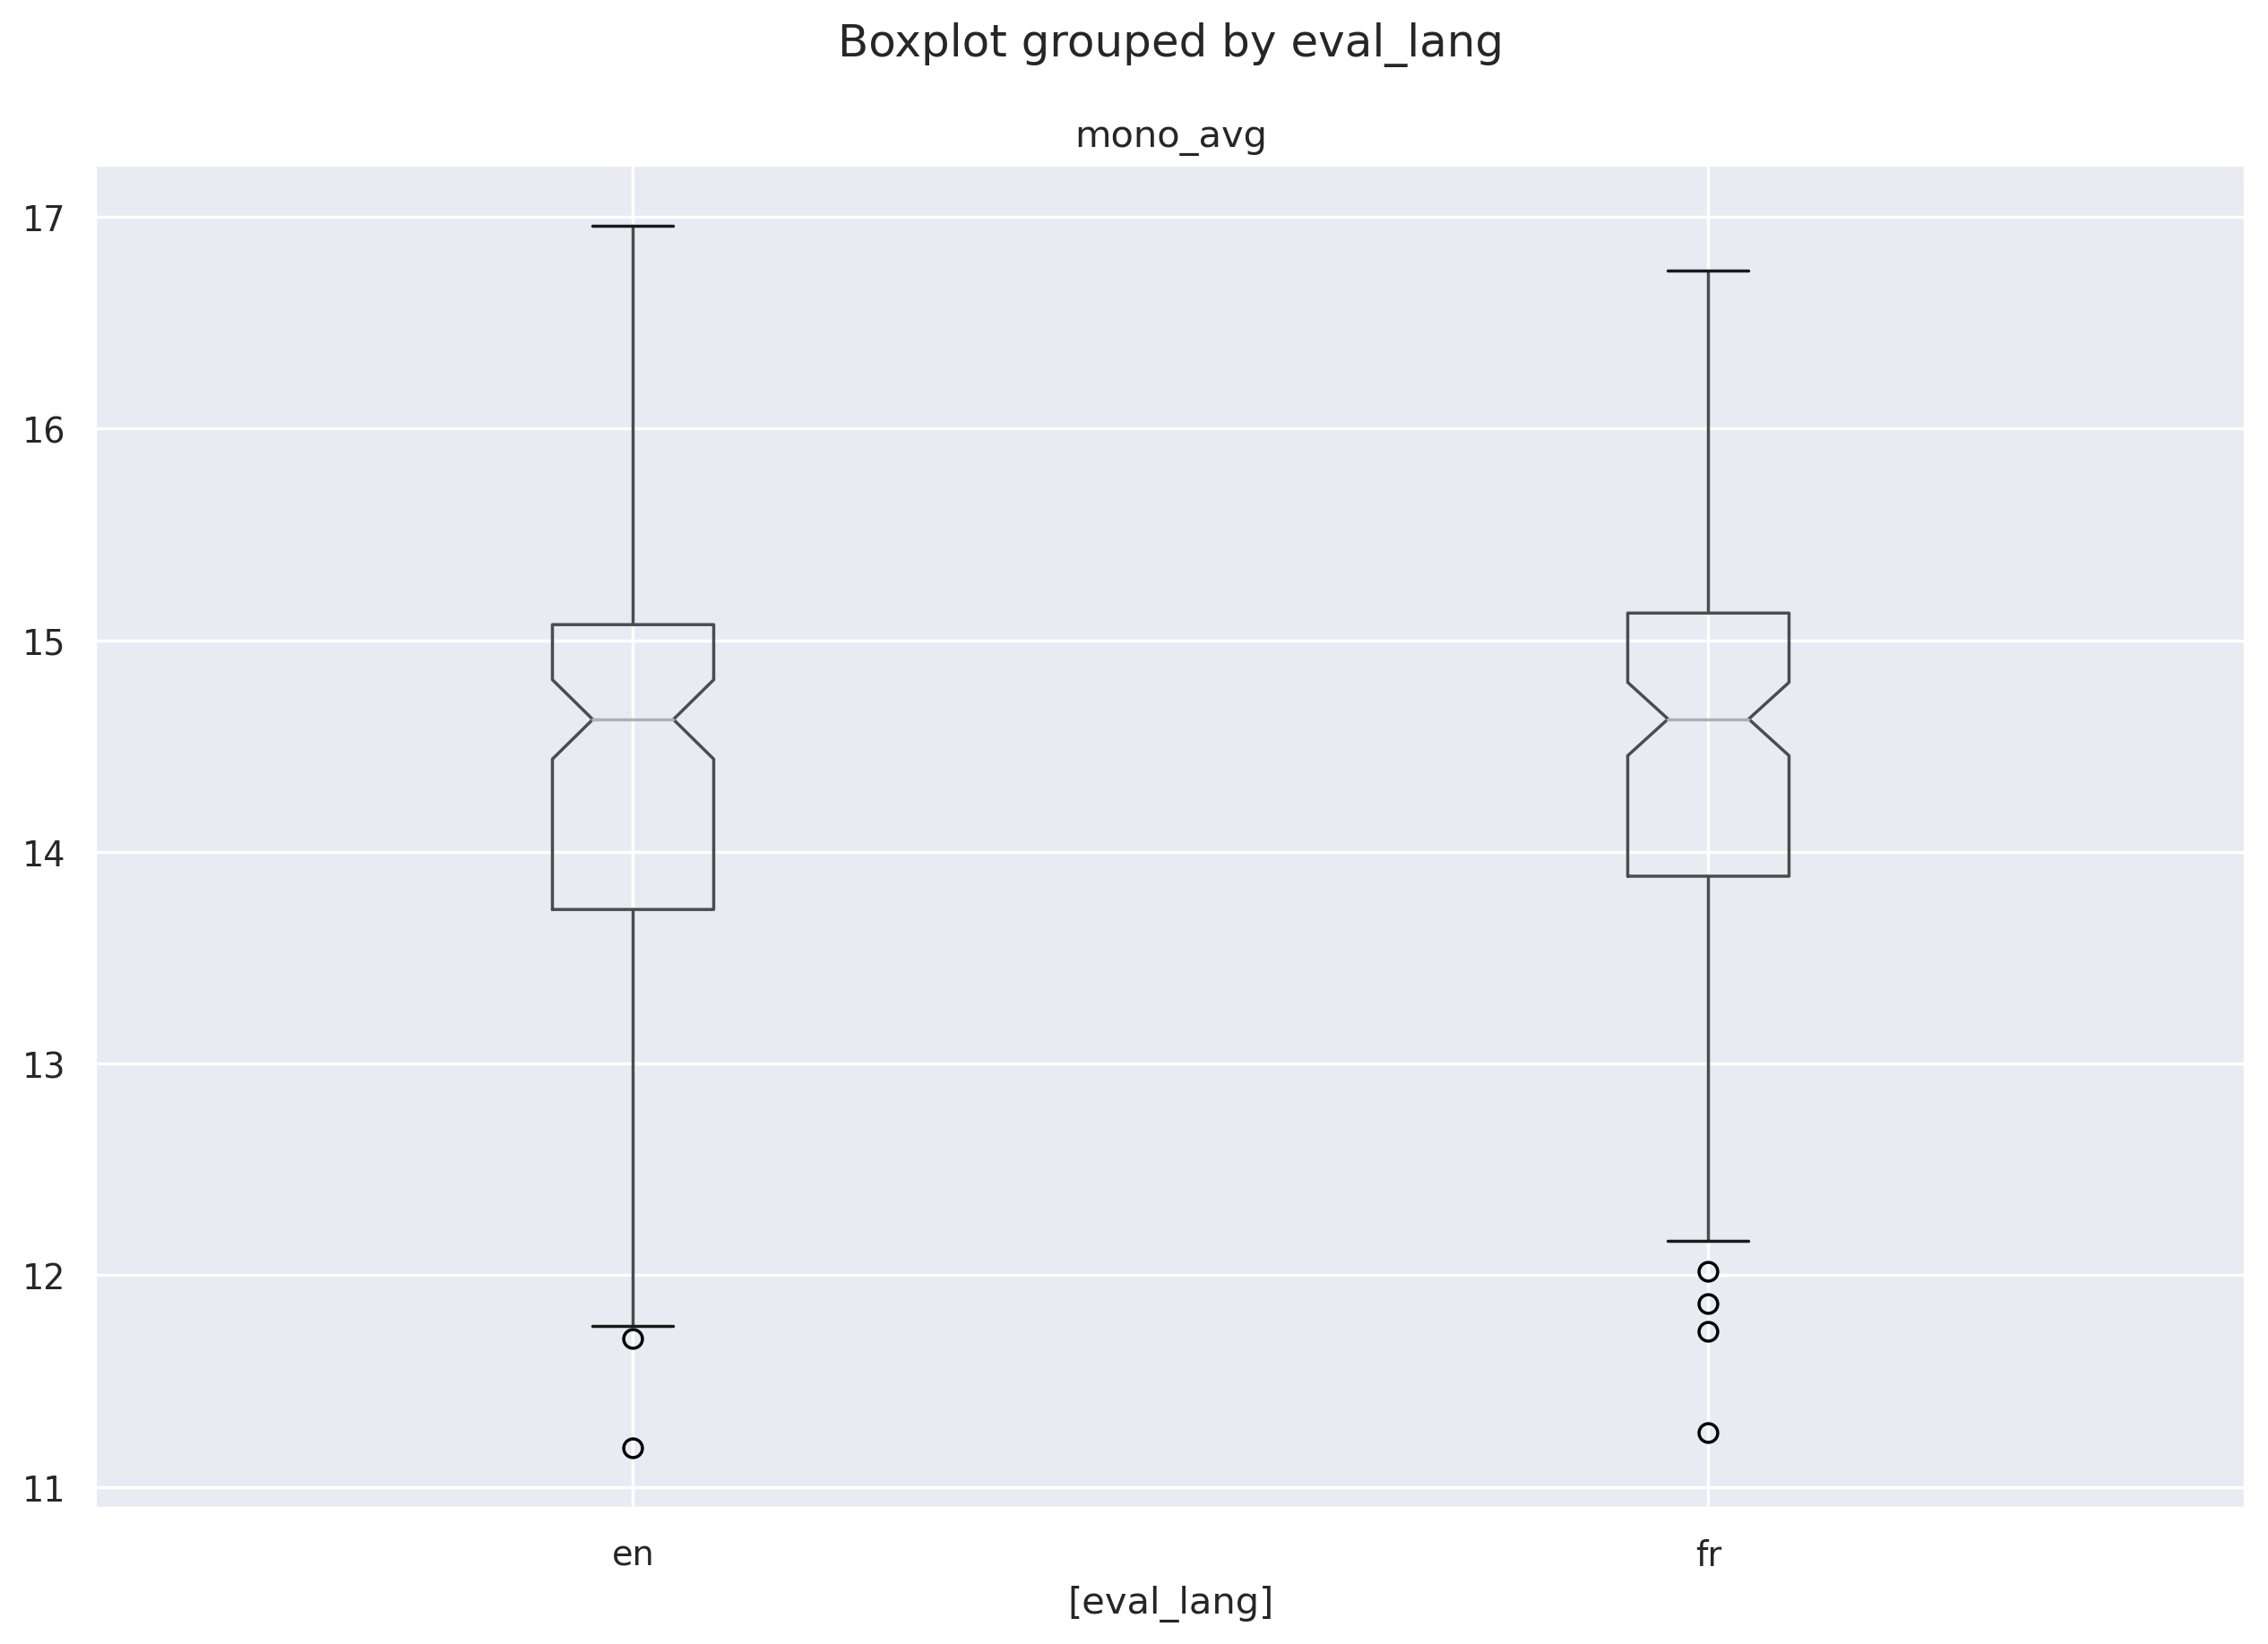

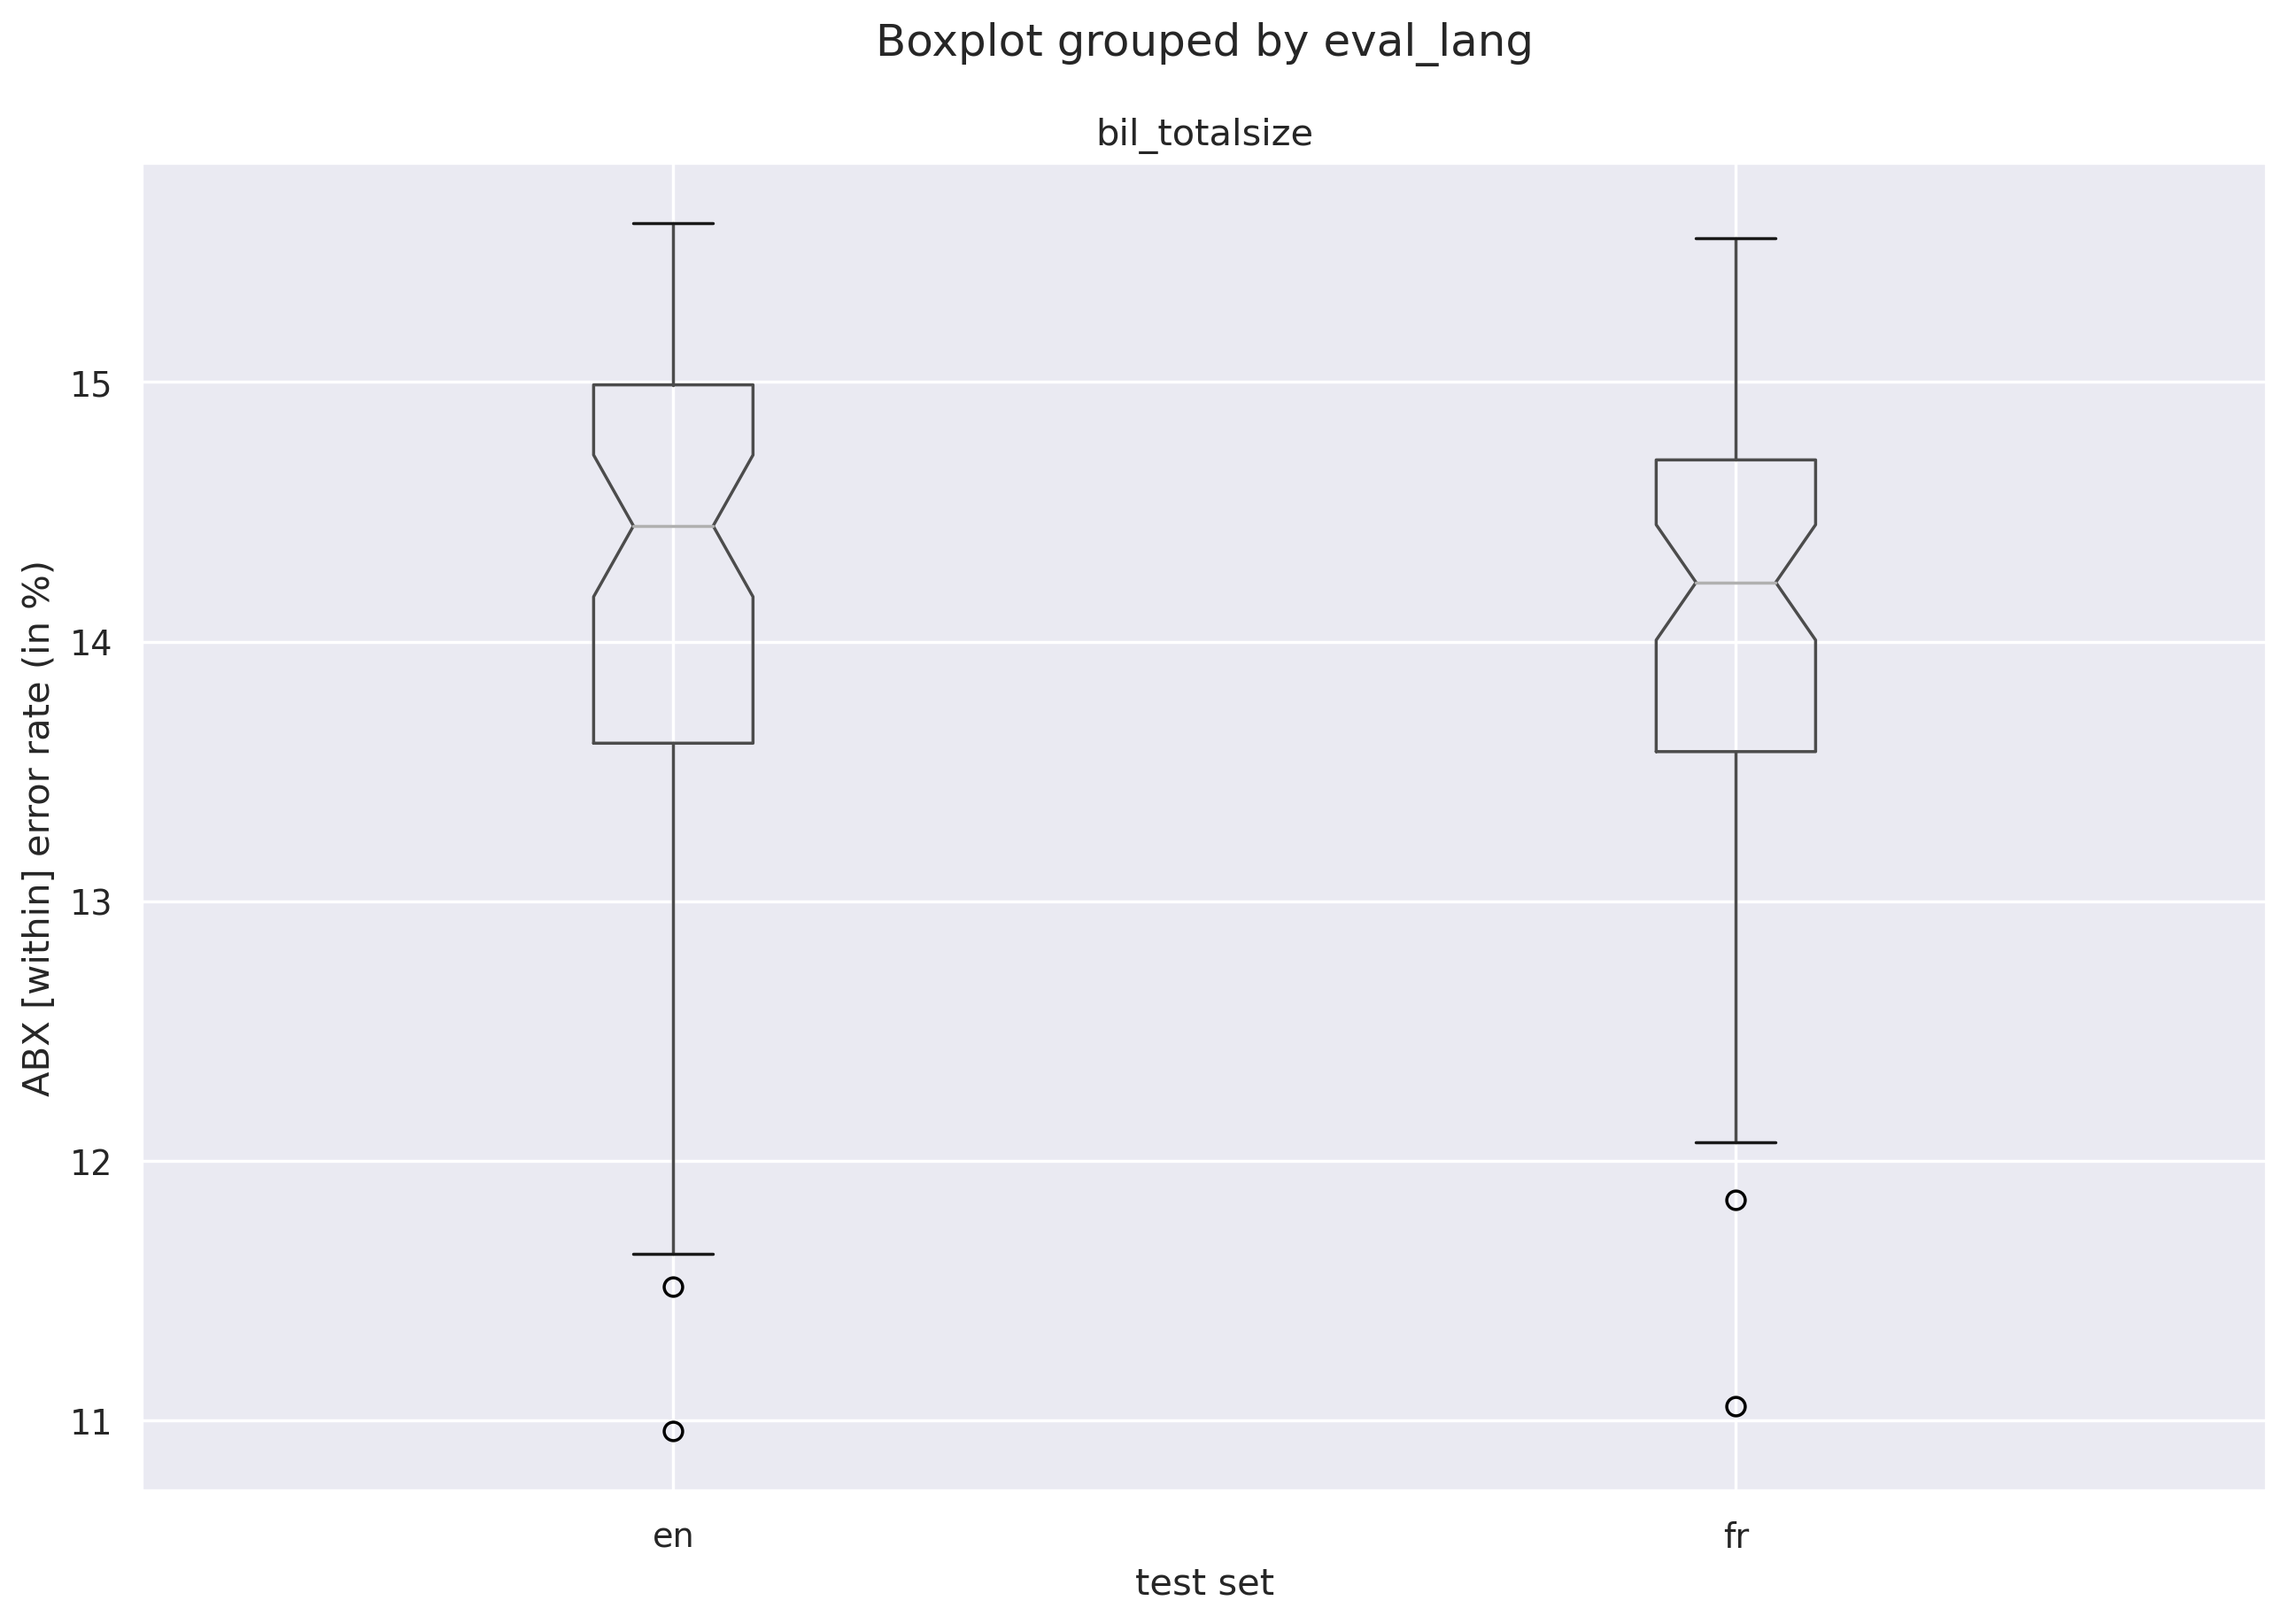

In [8]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_within[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

boxplot = df_within[['bil_totalsize',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('test set')


## C. Comparing Monolingual vs Bilingual ABX scores 



### C1. French vs English vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')

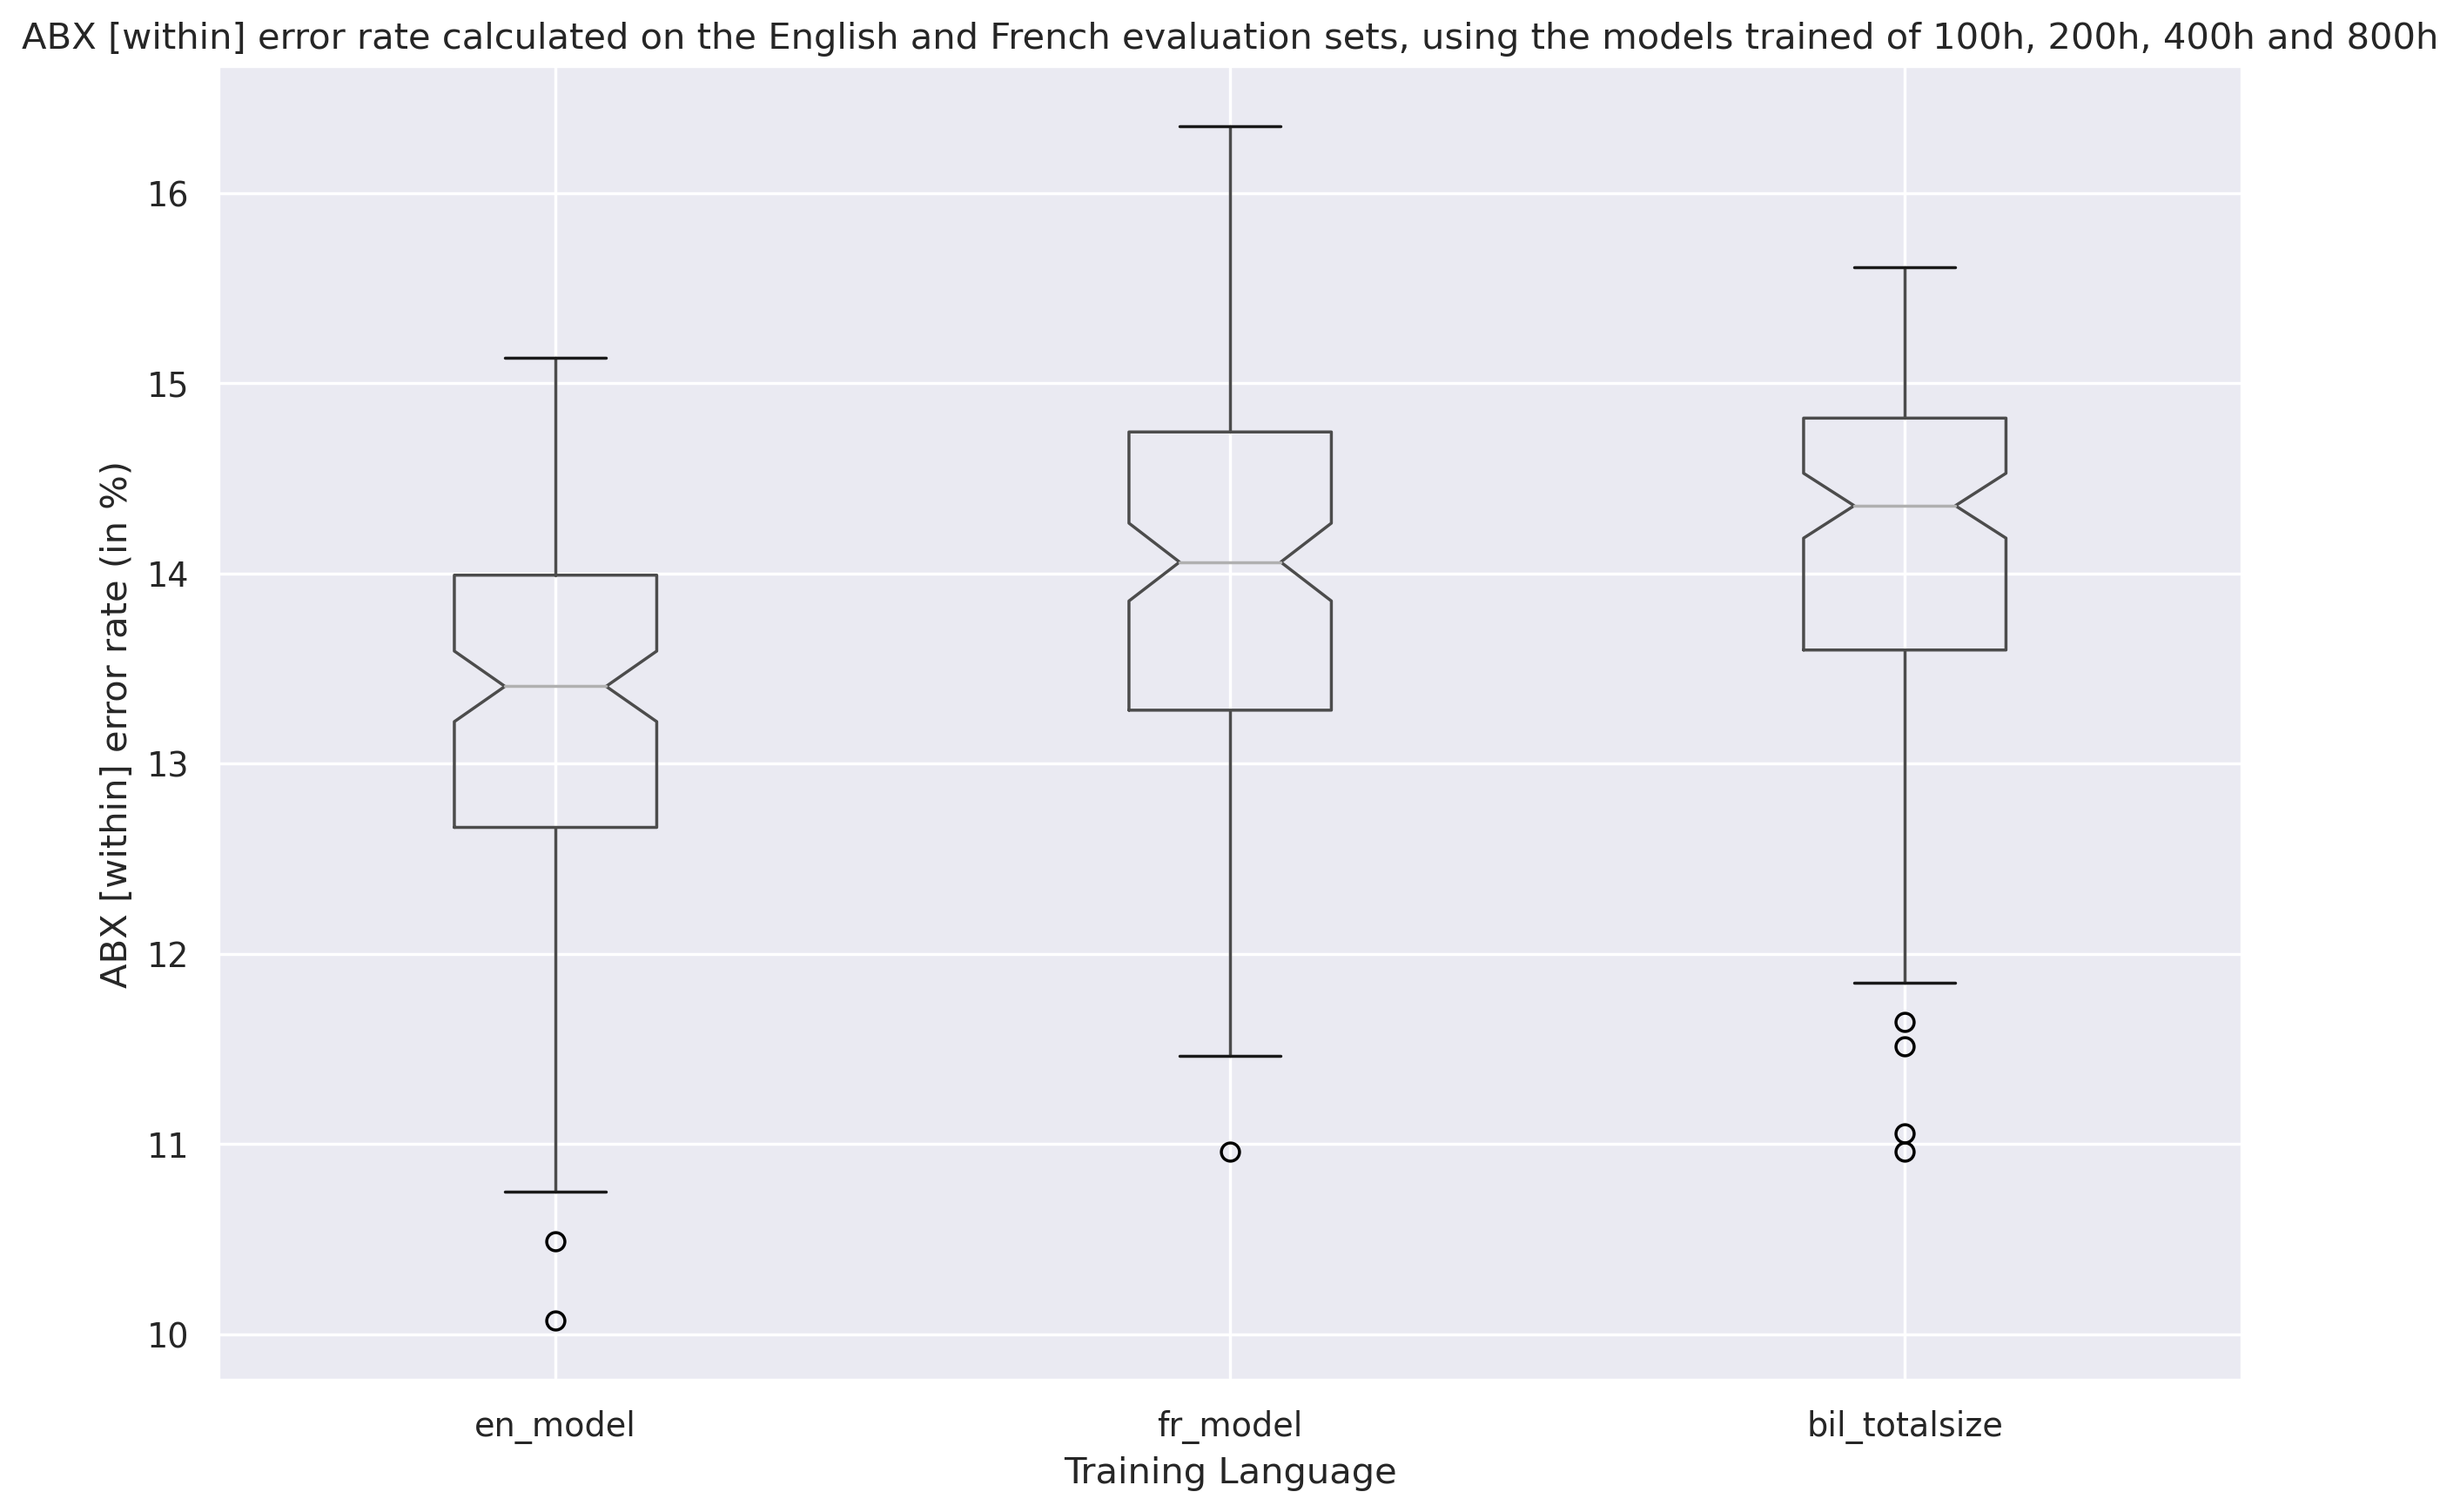

In [9]:
boxplot = df_within[['en_model', 'fr_model', 'bil_totalsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')



Text(0.5, 1.0, 'ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')

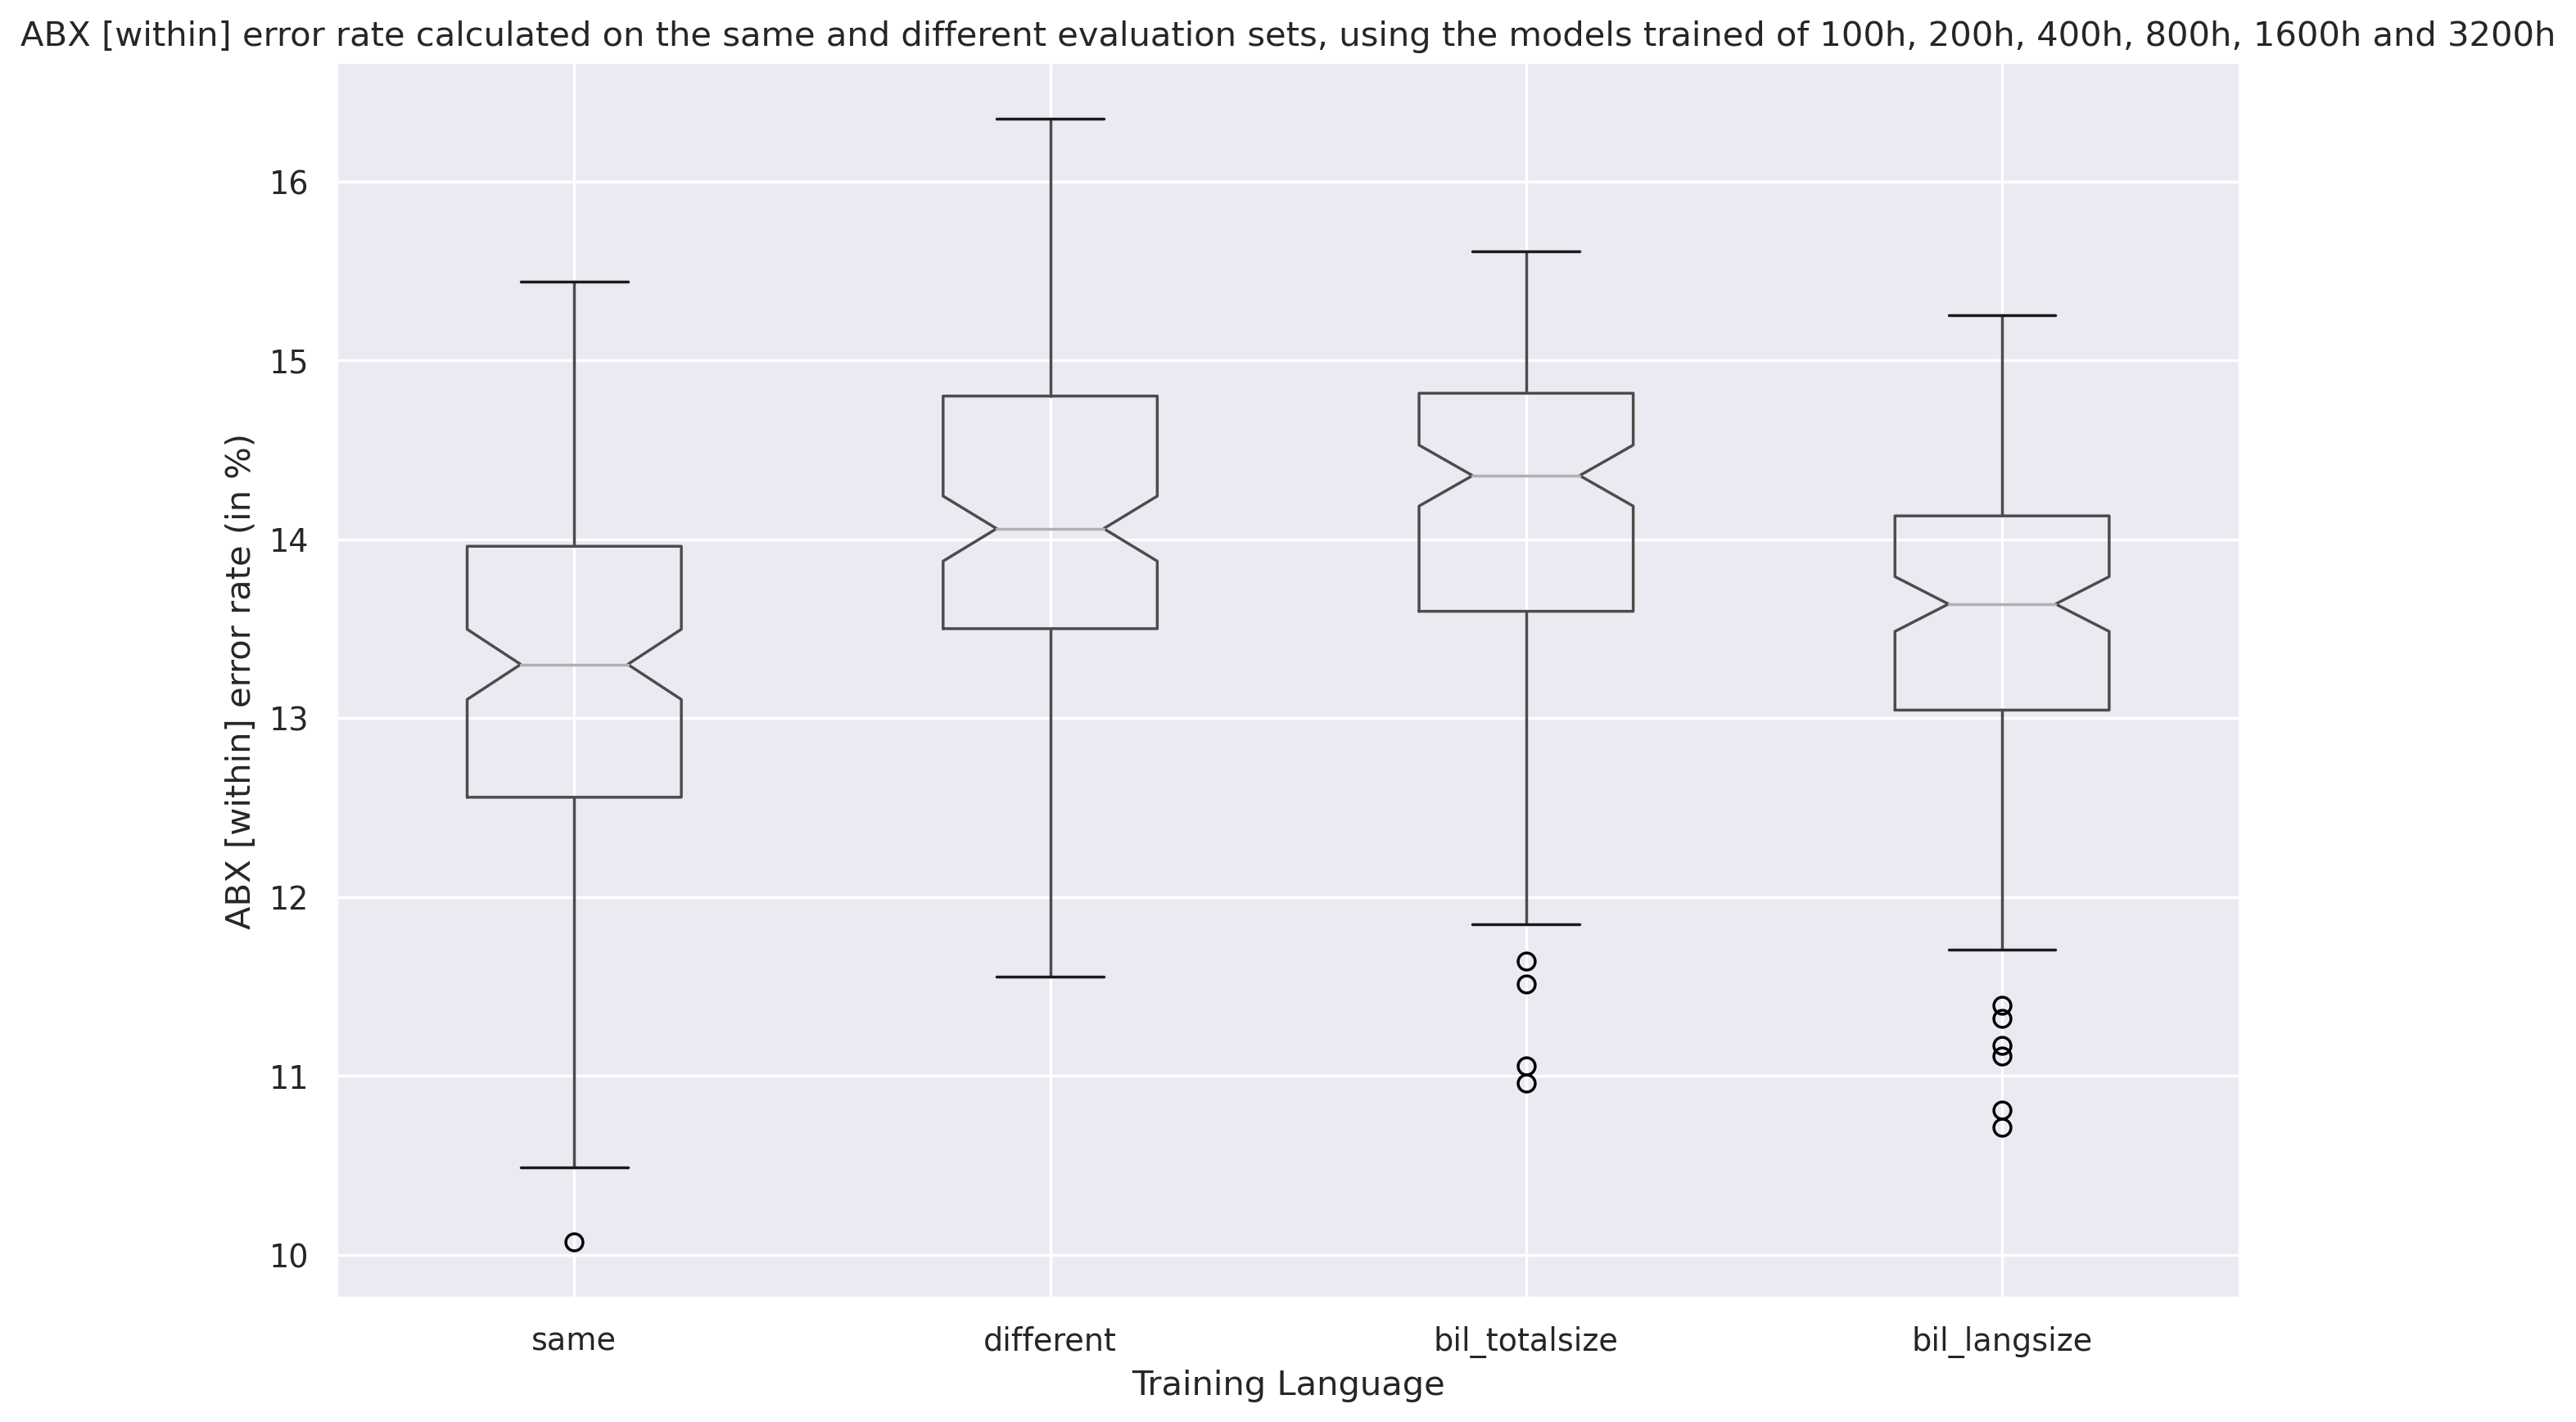

In [36]:
boxplot = df_within[['same', 'different', 'bil_totalsize','bil_langsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')



### C2. Monolingual vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')

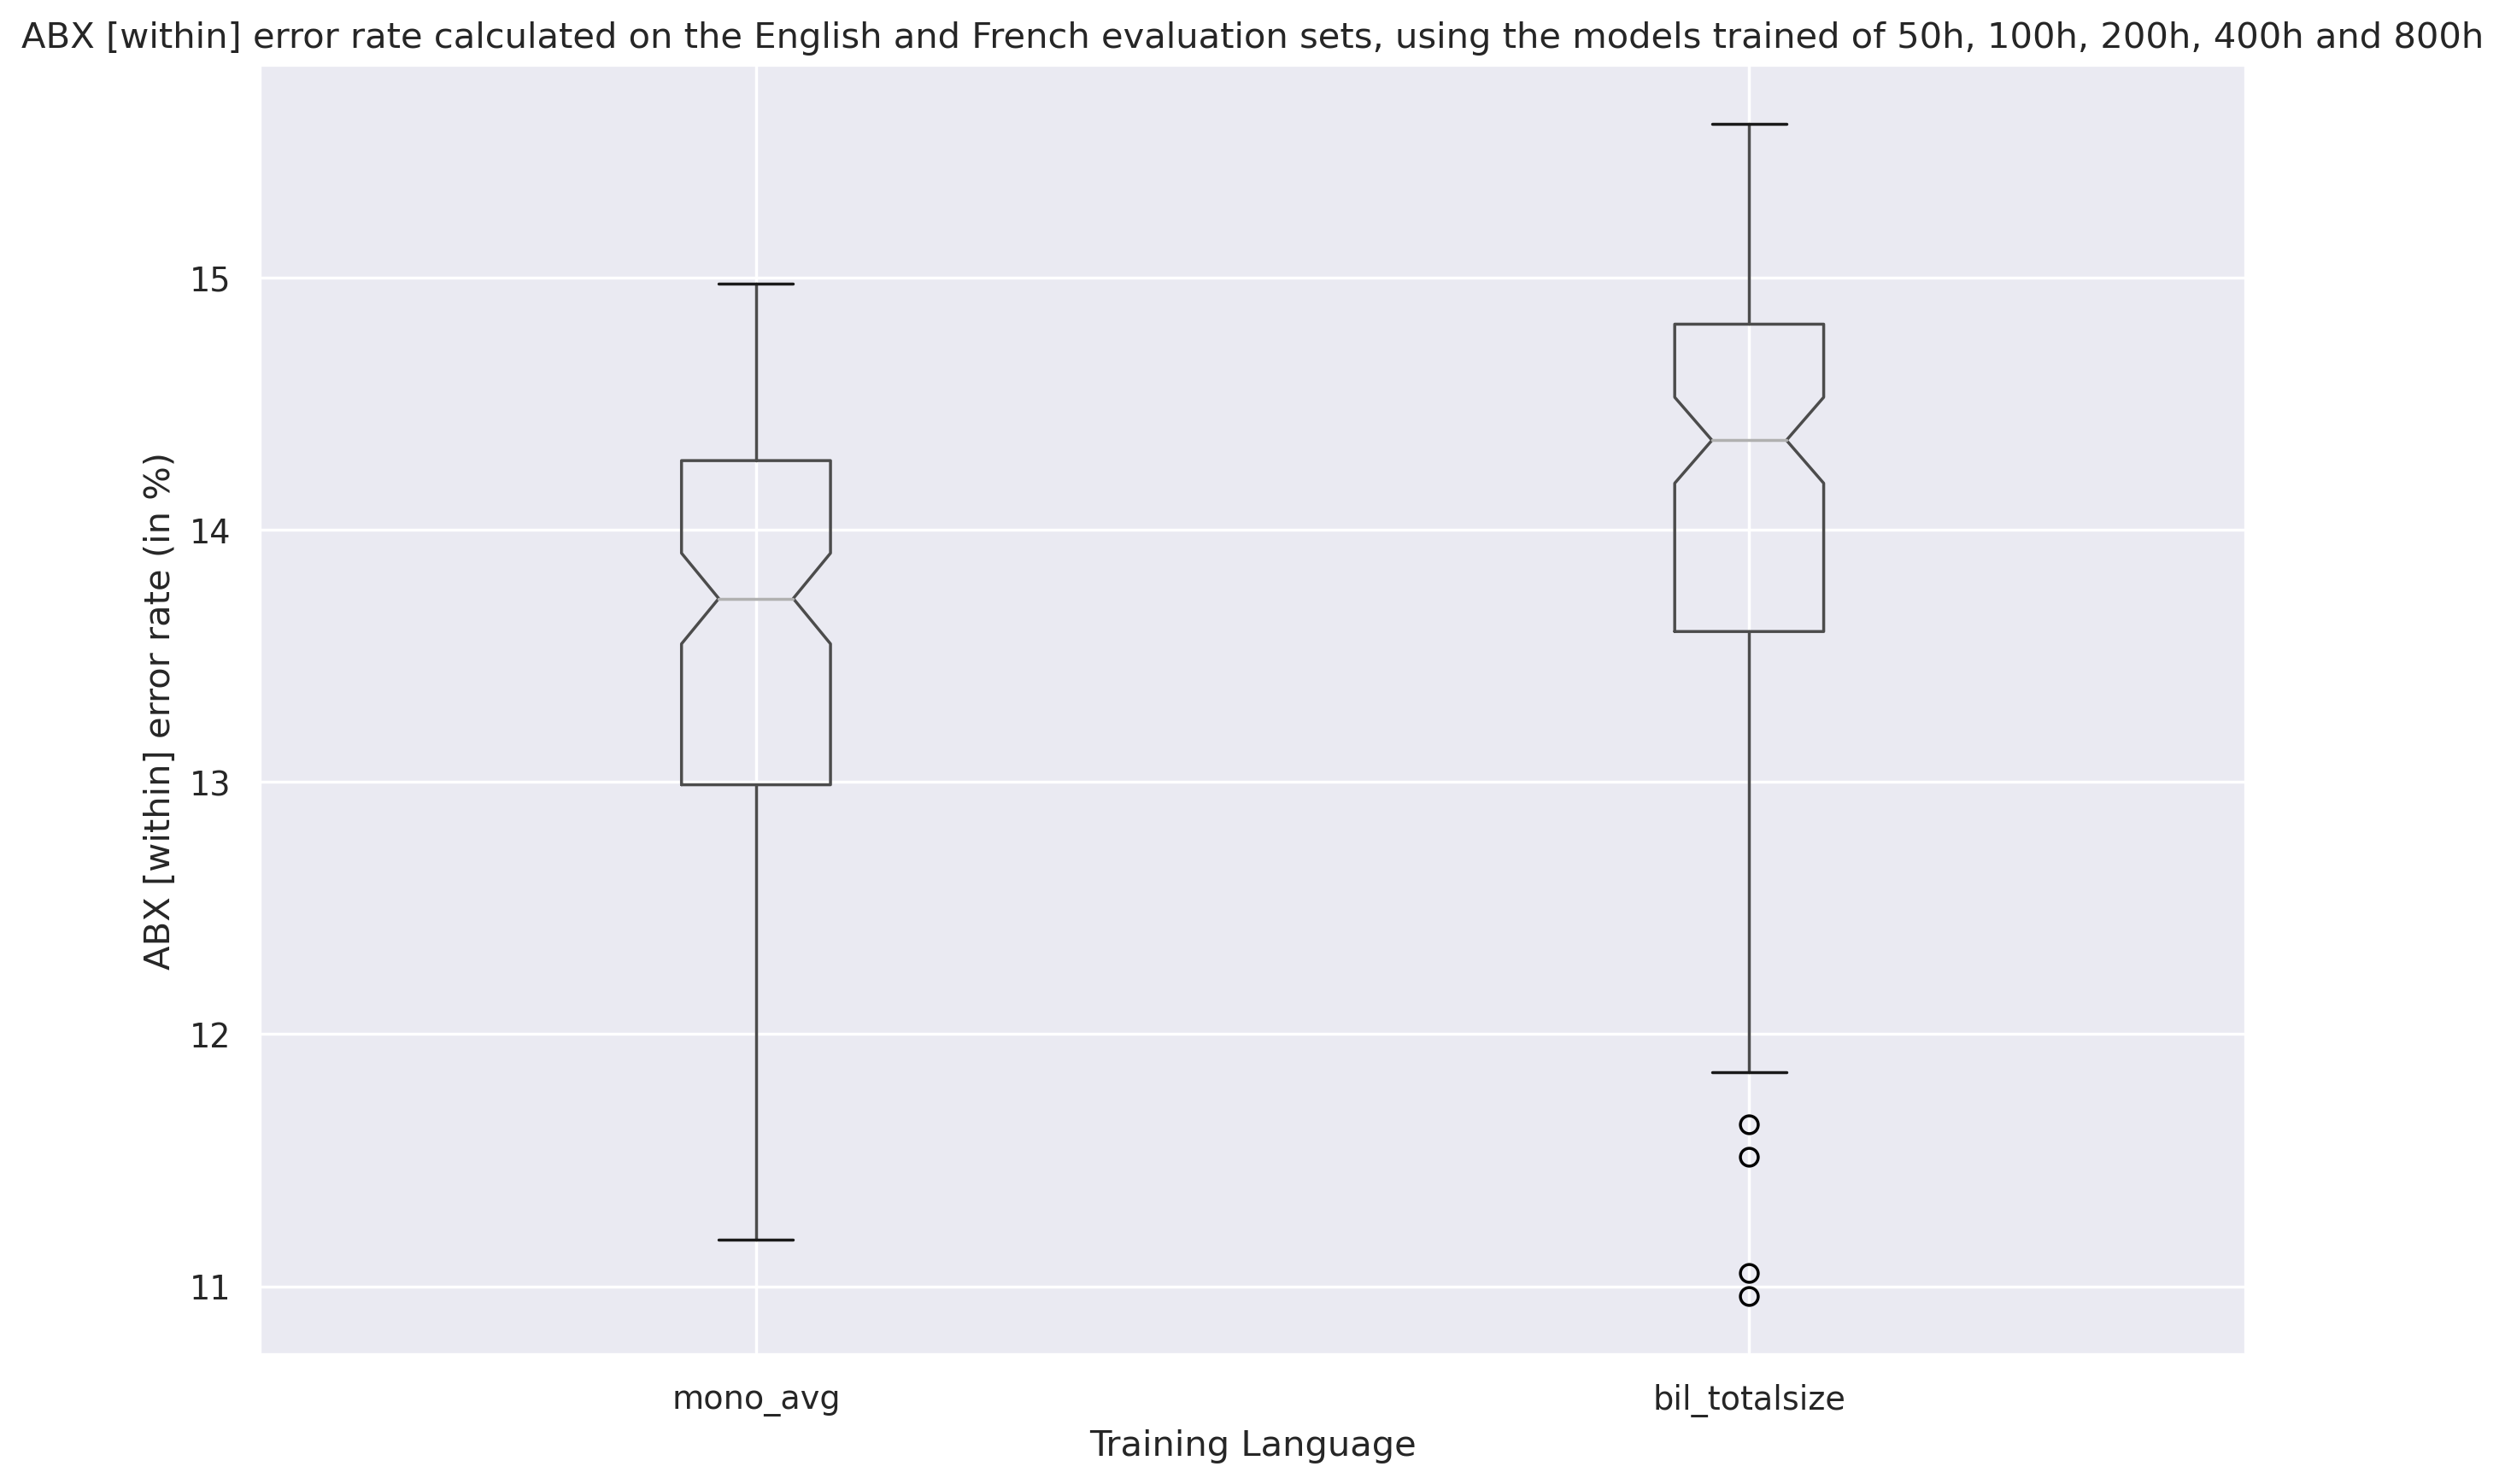

In [10]:
boxplot = df_within[['mono_avg', 'bil_totalsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')



### C3. Monolingual vs Bilingual LangSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the largest dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')

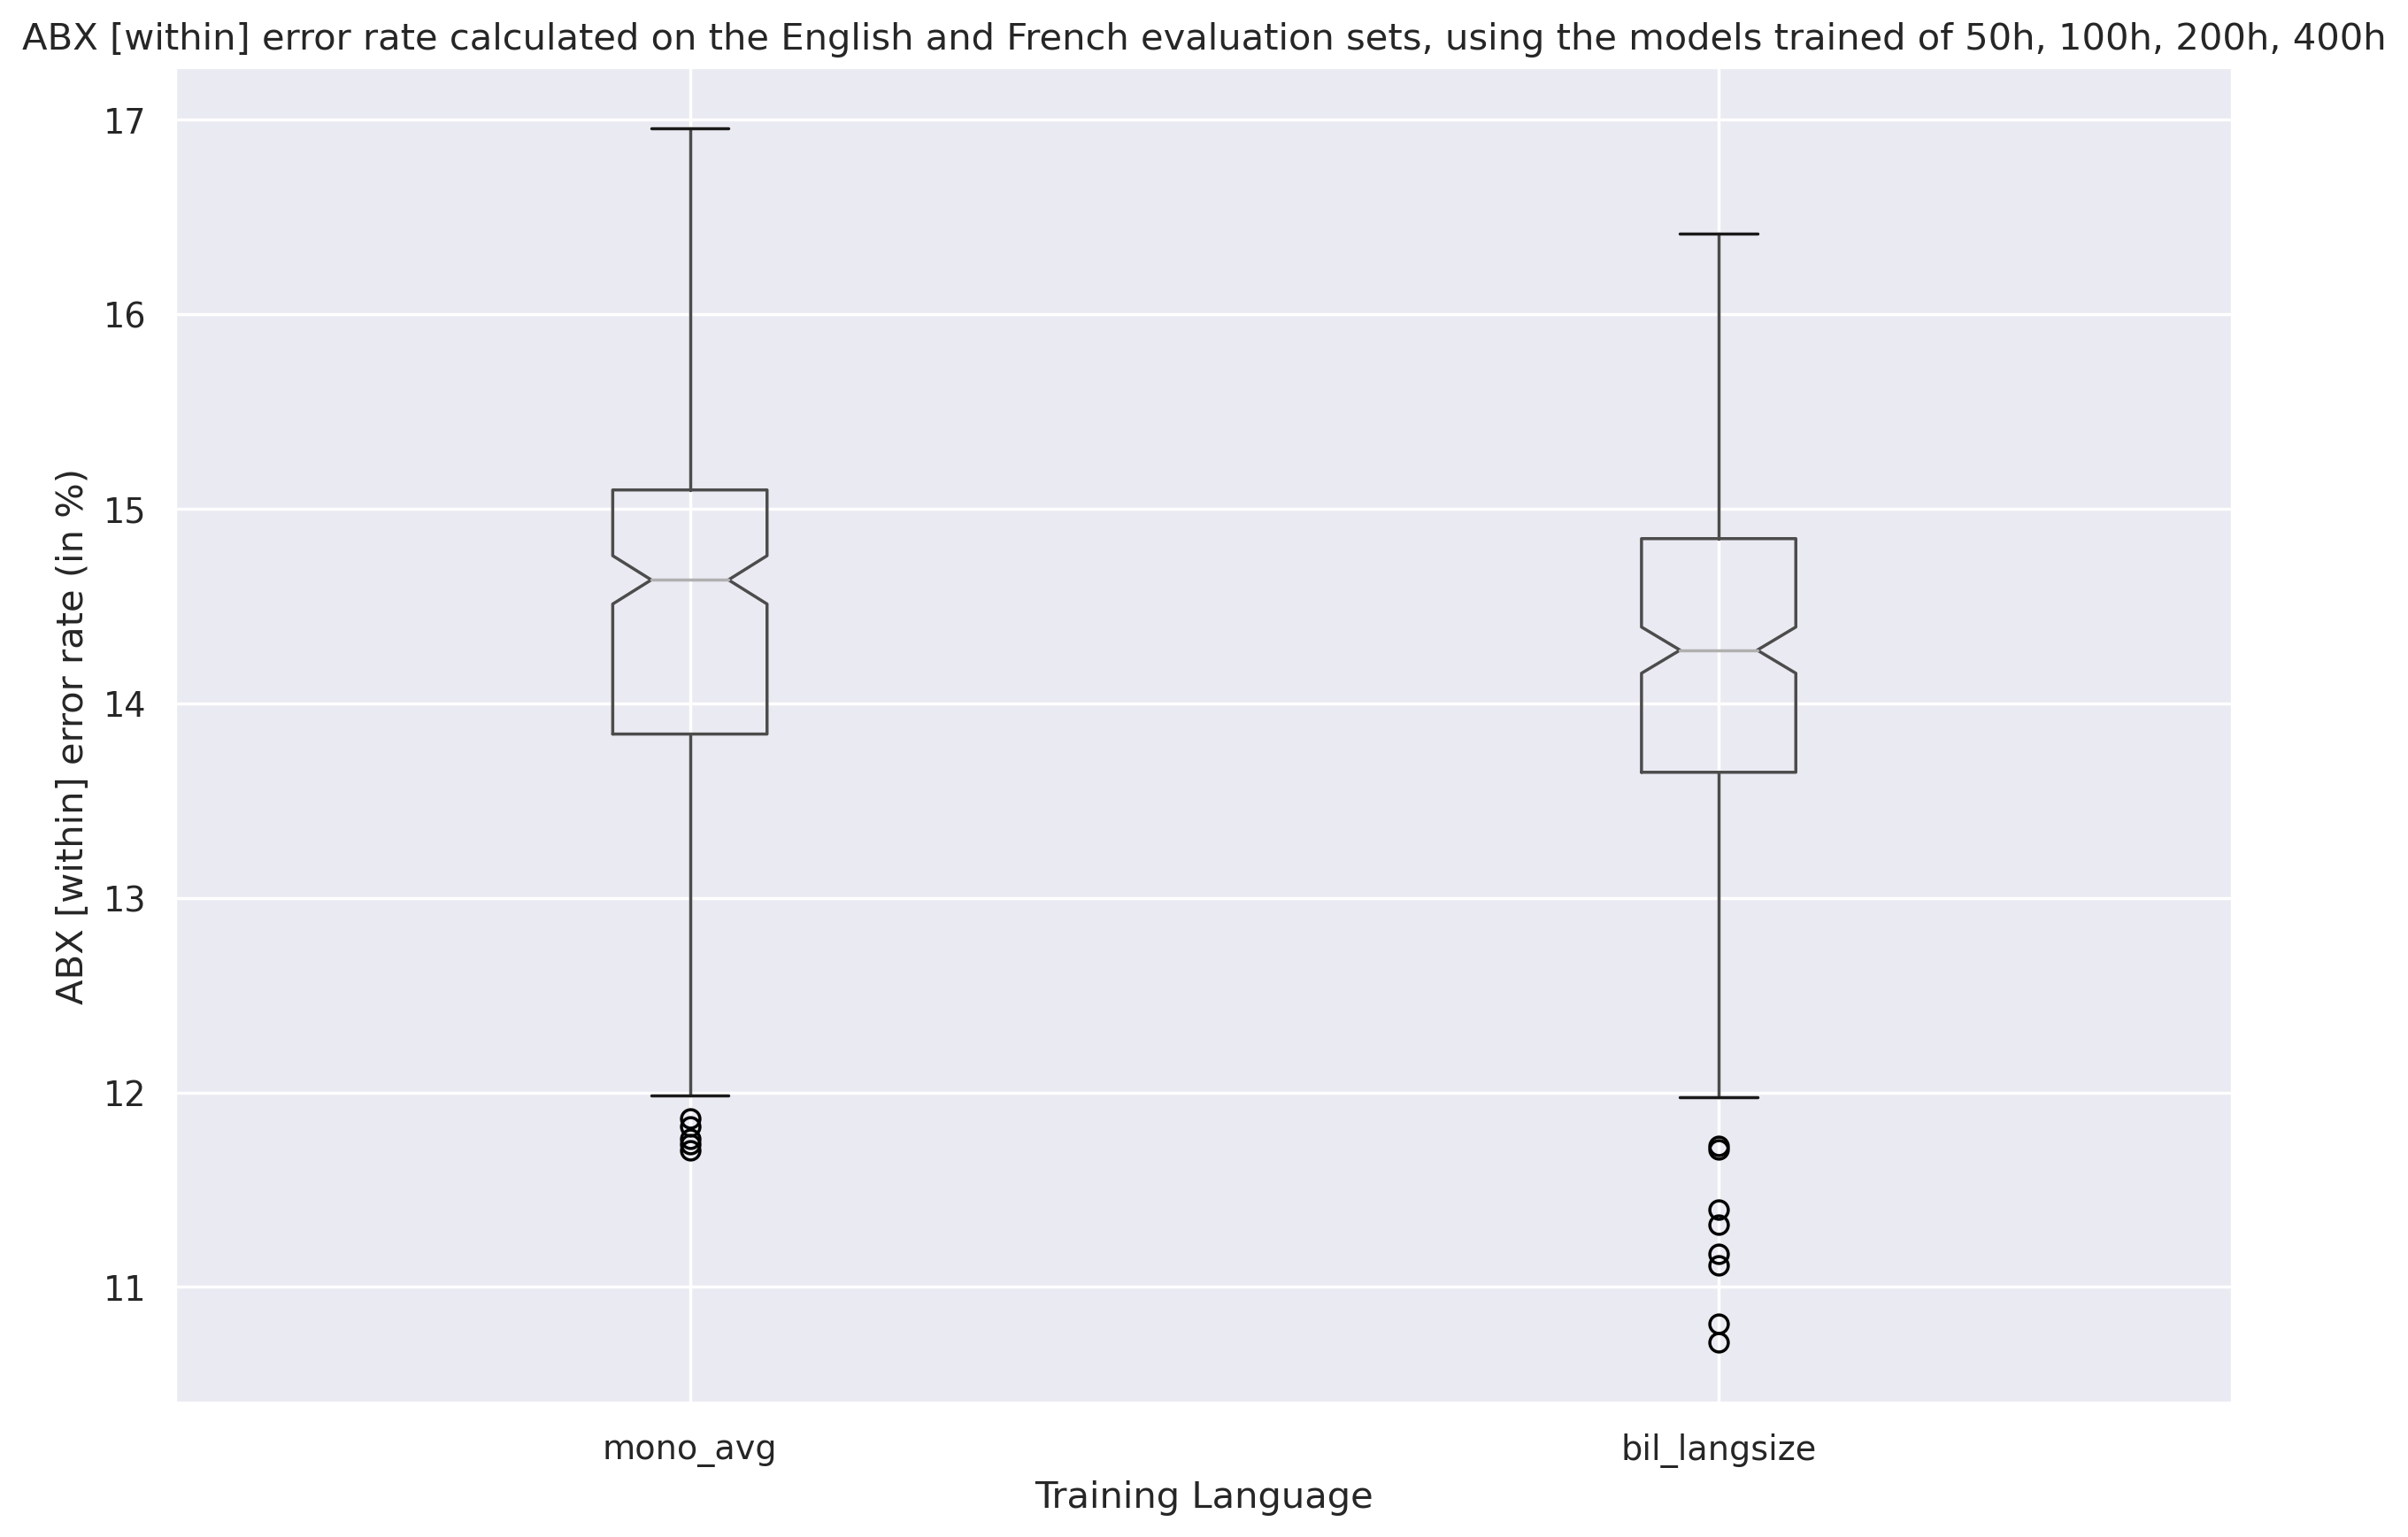

In [11]:
boxplot = df_within[['mono_avg', 'bil_langsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')



## D. Developmental graphs

In [37]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


### D1. Developmental [within] ABX  on both test sets (original)

(10.0, 21.0)

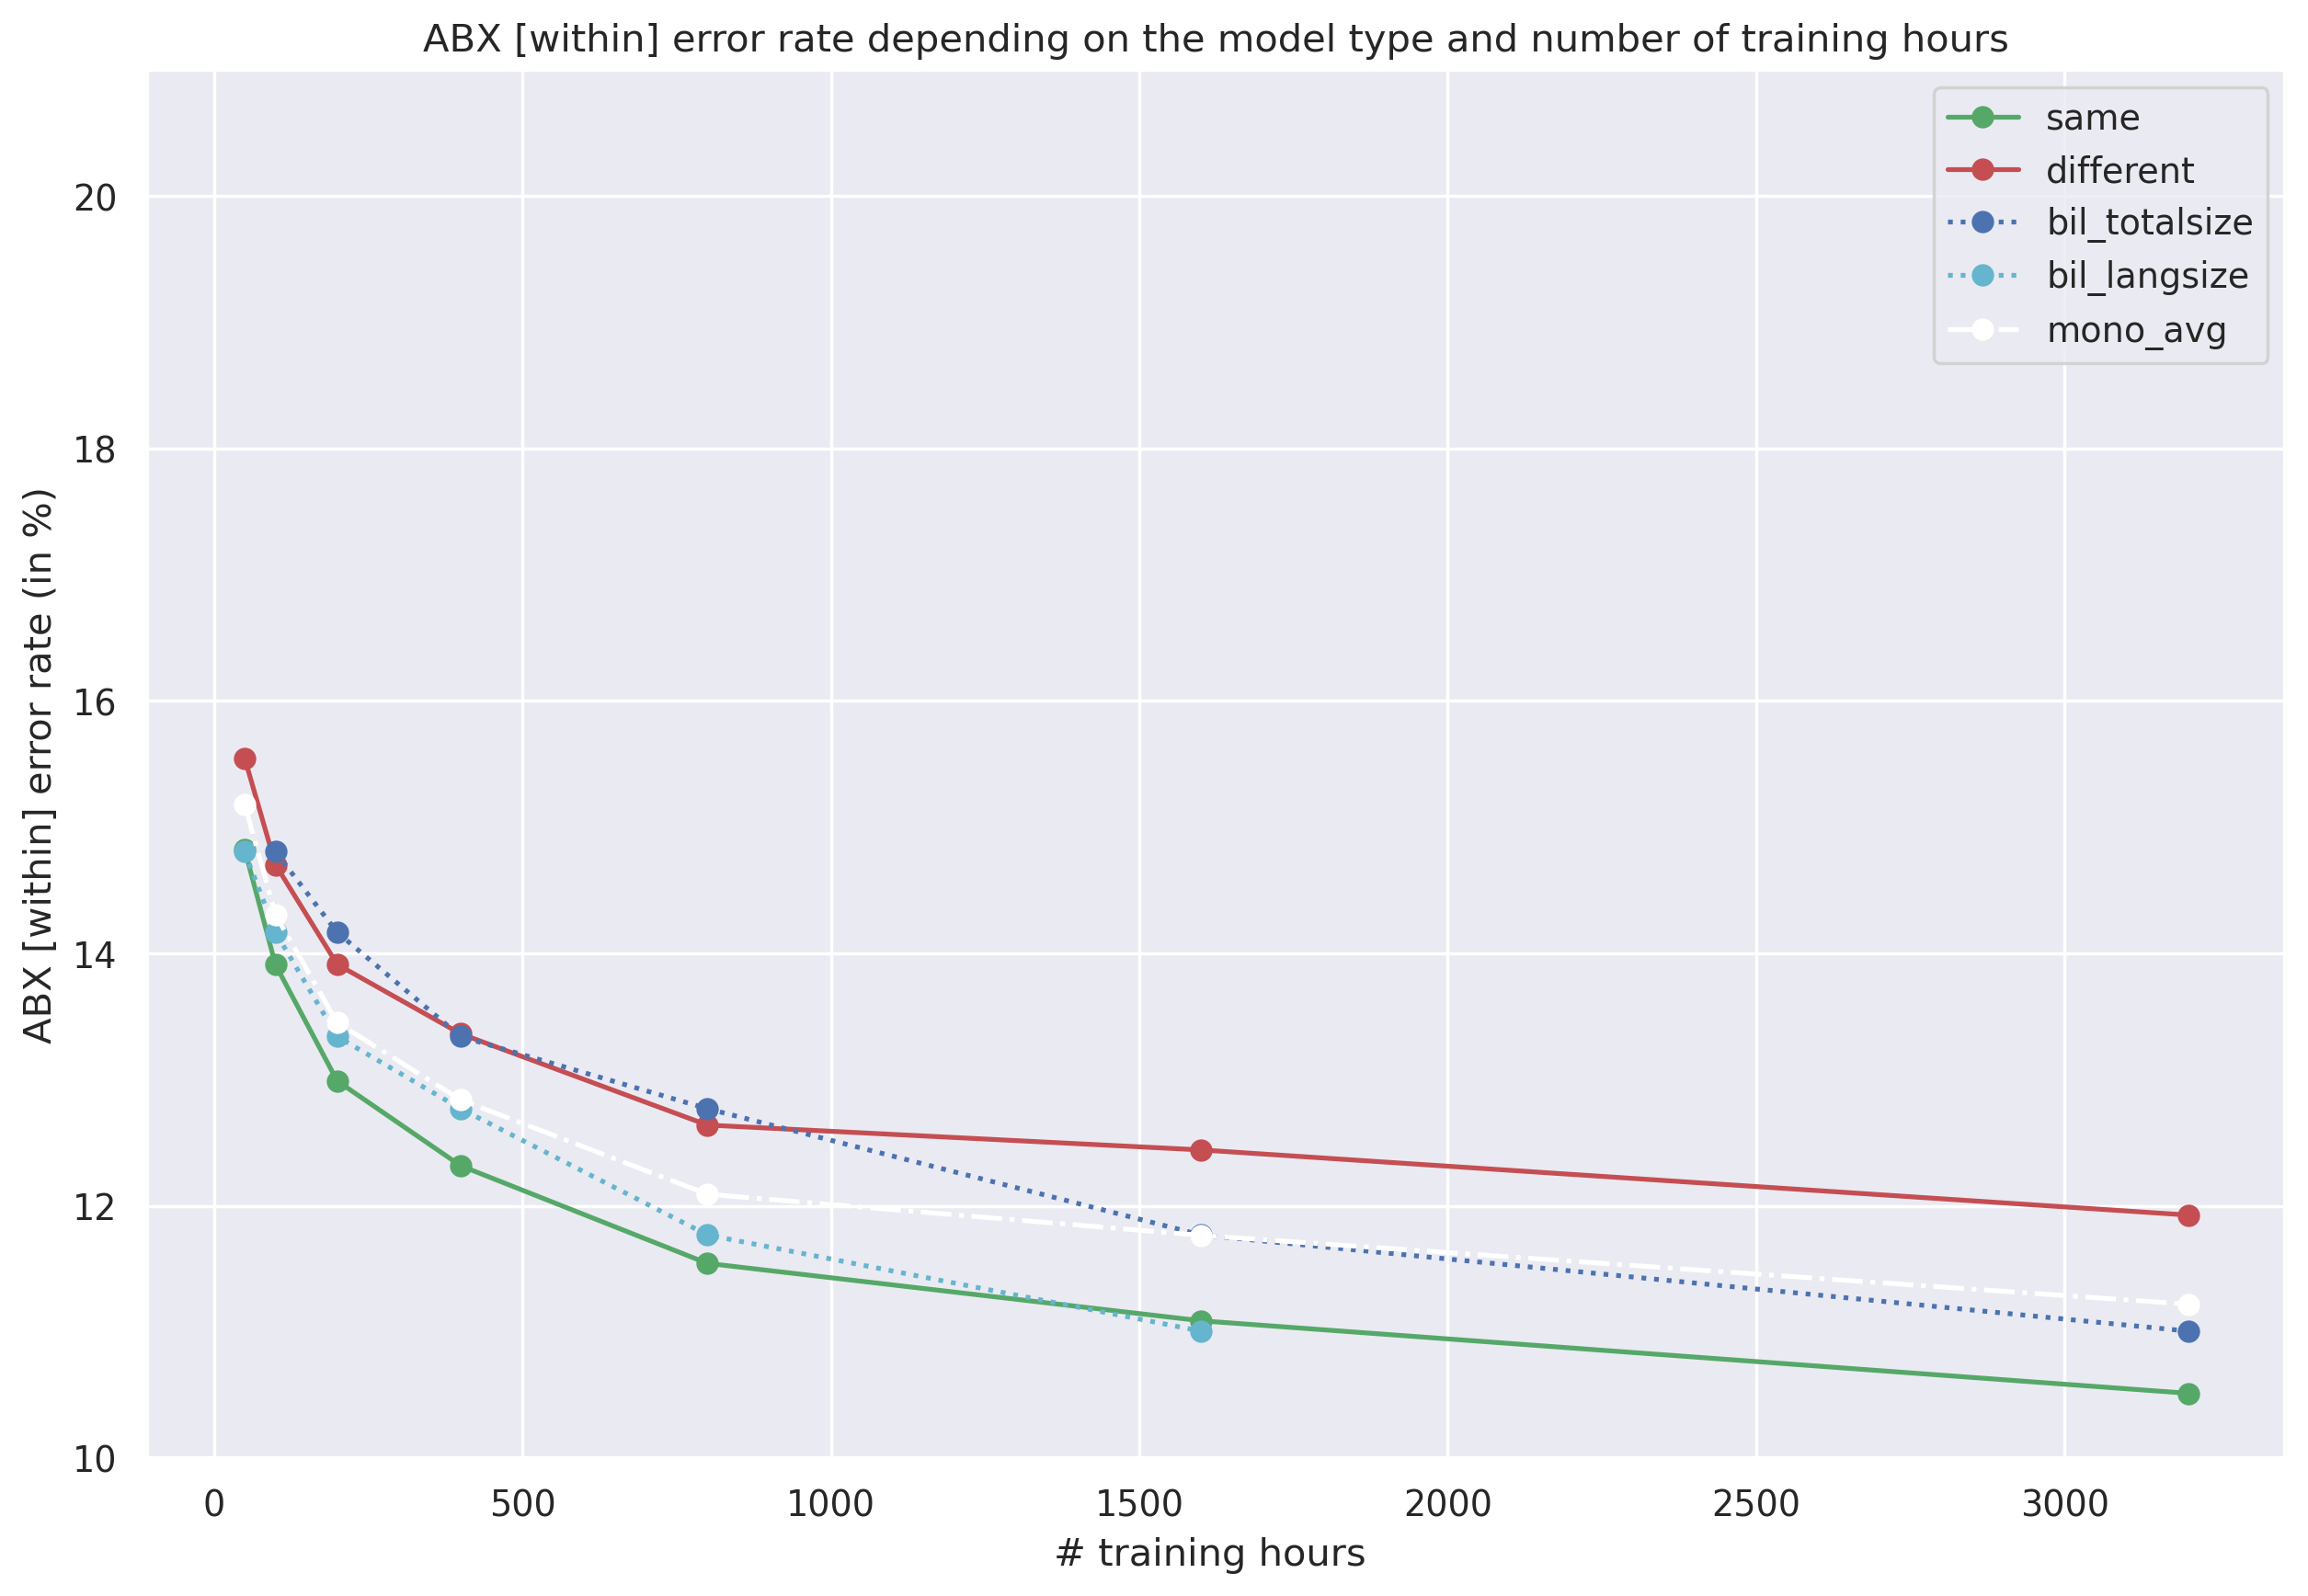

In [53]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")
plt.ylim([10,21])

(10.0, 21.0)

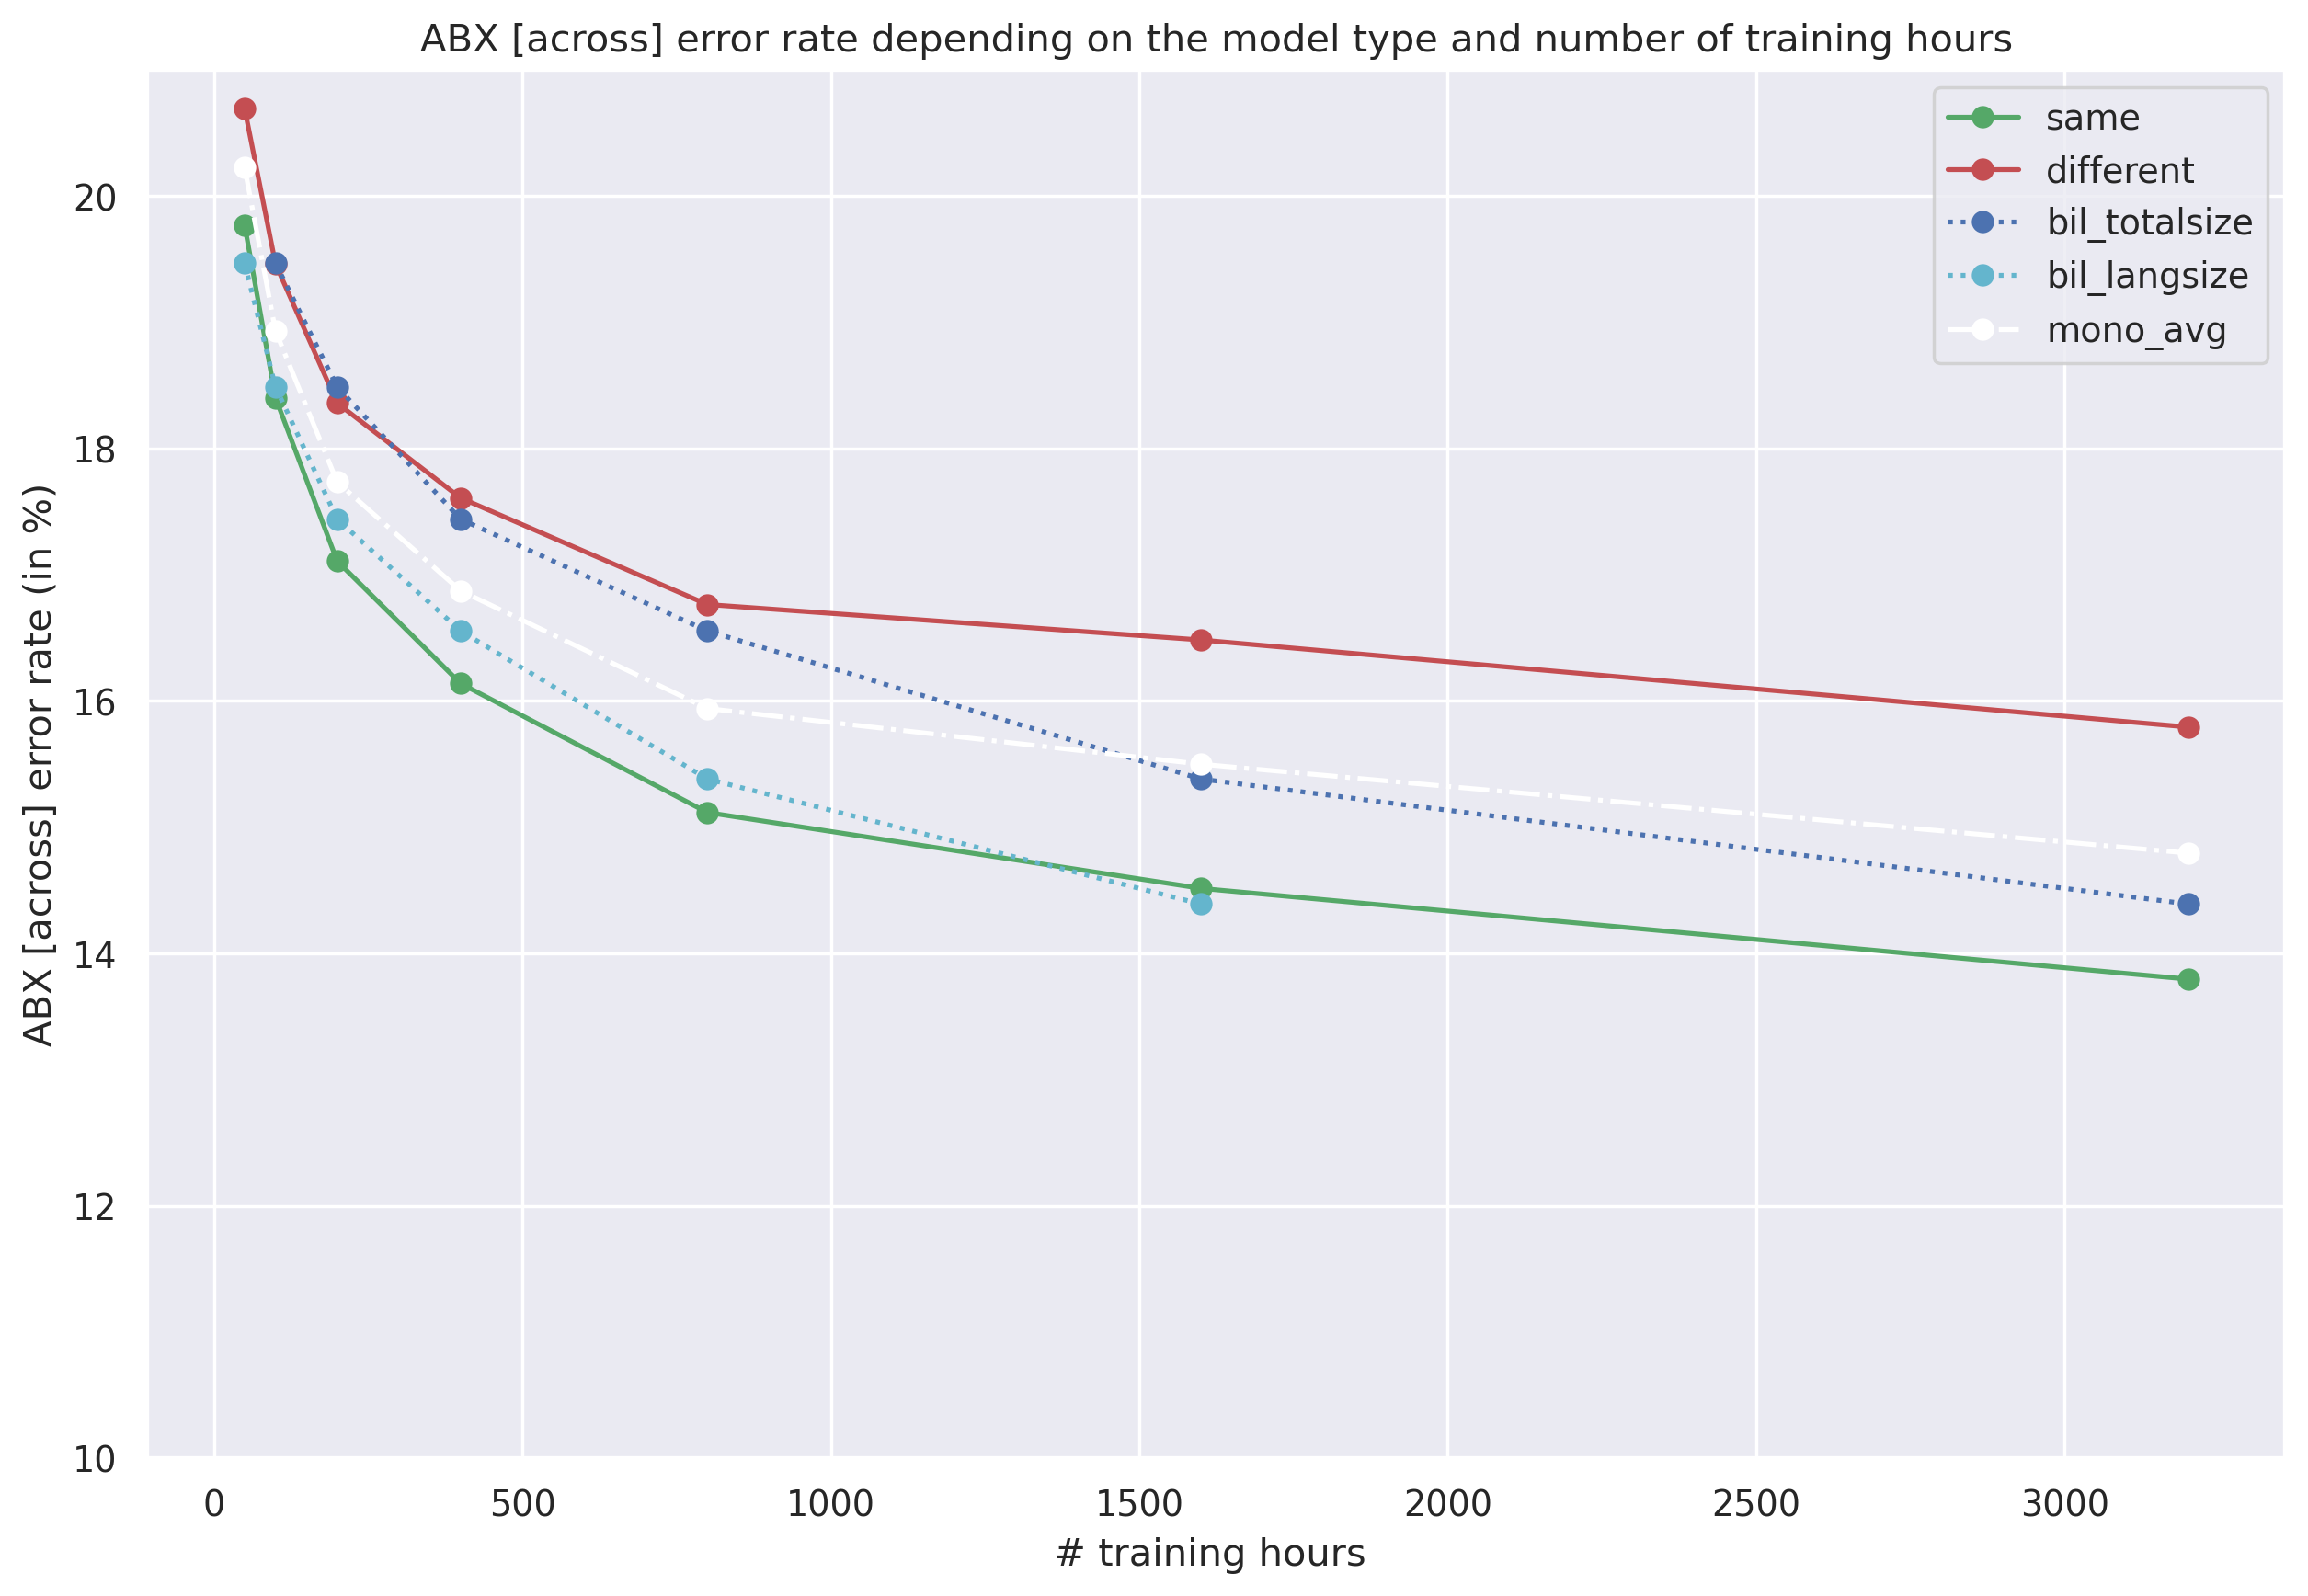

In [52]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %)")
plt.title("ABX [across] error rate depending on the model type and number of training hours")
plt.ylim([10,21])

In [14]:
err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']]

same  different  bil_totalsize  bil_langsize  mono_avg
size                                                            
50    0.879246   0.897116            NaN      0.626630  0.544081
100   0.678156   0.659250       0.456927      0.547322  0.376270
200   0.582534   0.608518       0.458208      0.364349  0.362071
400   0.471578   0.472301       0.254890      0.412710  0.130723
800   0.501621   0.417259       0.409566      0.363352  0.151586
1600  0.558177   0.502919       0.244545      0.309409  0.070244
3200  0.628515   0.528725       0.066962           NaN  0.049895

In [15]:
df_within.groupby('size').std()


en_model  fr_model  bil_totalsize_A  bil_totalsize_B      same  \
size                                                                   
50    0.771890  0.909418              NaN              NaN  0.879246   
100   0.664324  0.670661         0.621915         0.632622  0.678156   
200   0.707428  0.663255         0.539814         0.563342  0.582534   
400   0.646980  0.628009         0.337058         0.389266  0.471578   
800   0.693796  0.567314         0.439466         0.410412  0.501621   
1600  0.847338  0.748767         0.392766         0.378724  0.558177   
3200  1.048624  0.948834         0.068270         0.202195  0.628515   

      different  bil_langsize  bil_totalsize  mono_avg  
size                                                    
50     0.897116      0.626630            NaN  0.544081  
100    0.659250      0.547322       0.456927  0.376270  
200    0.608518      0.364349       0.458208  0.362071  
400    0.472301      0.412710       0.254890  0.130723  
800    0.417259      0.363352       0.409566  0.151586  
1600   0.502919      0.309409       0.244545  0.070244  
3200   0.528725           NaN       0.066962  0.049895

Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours')

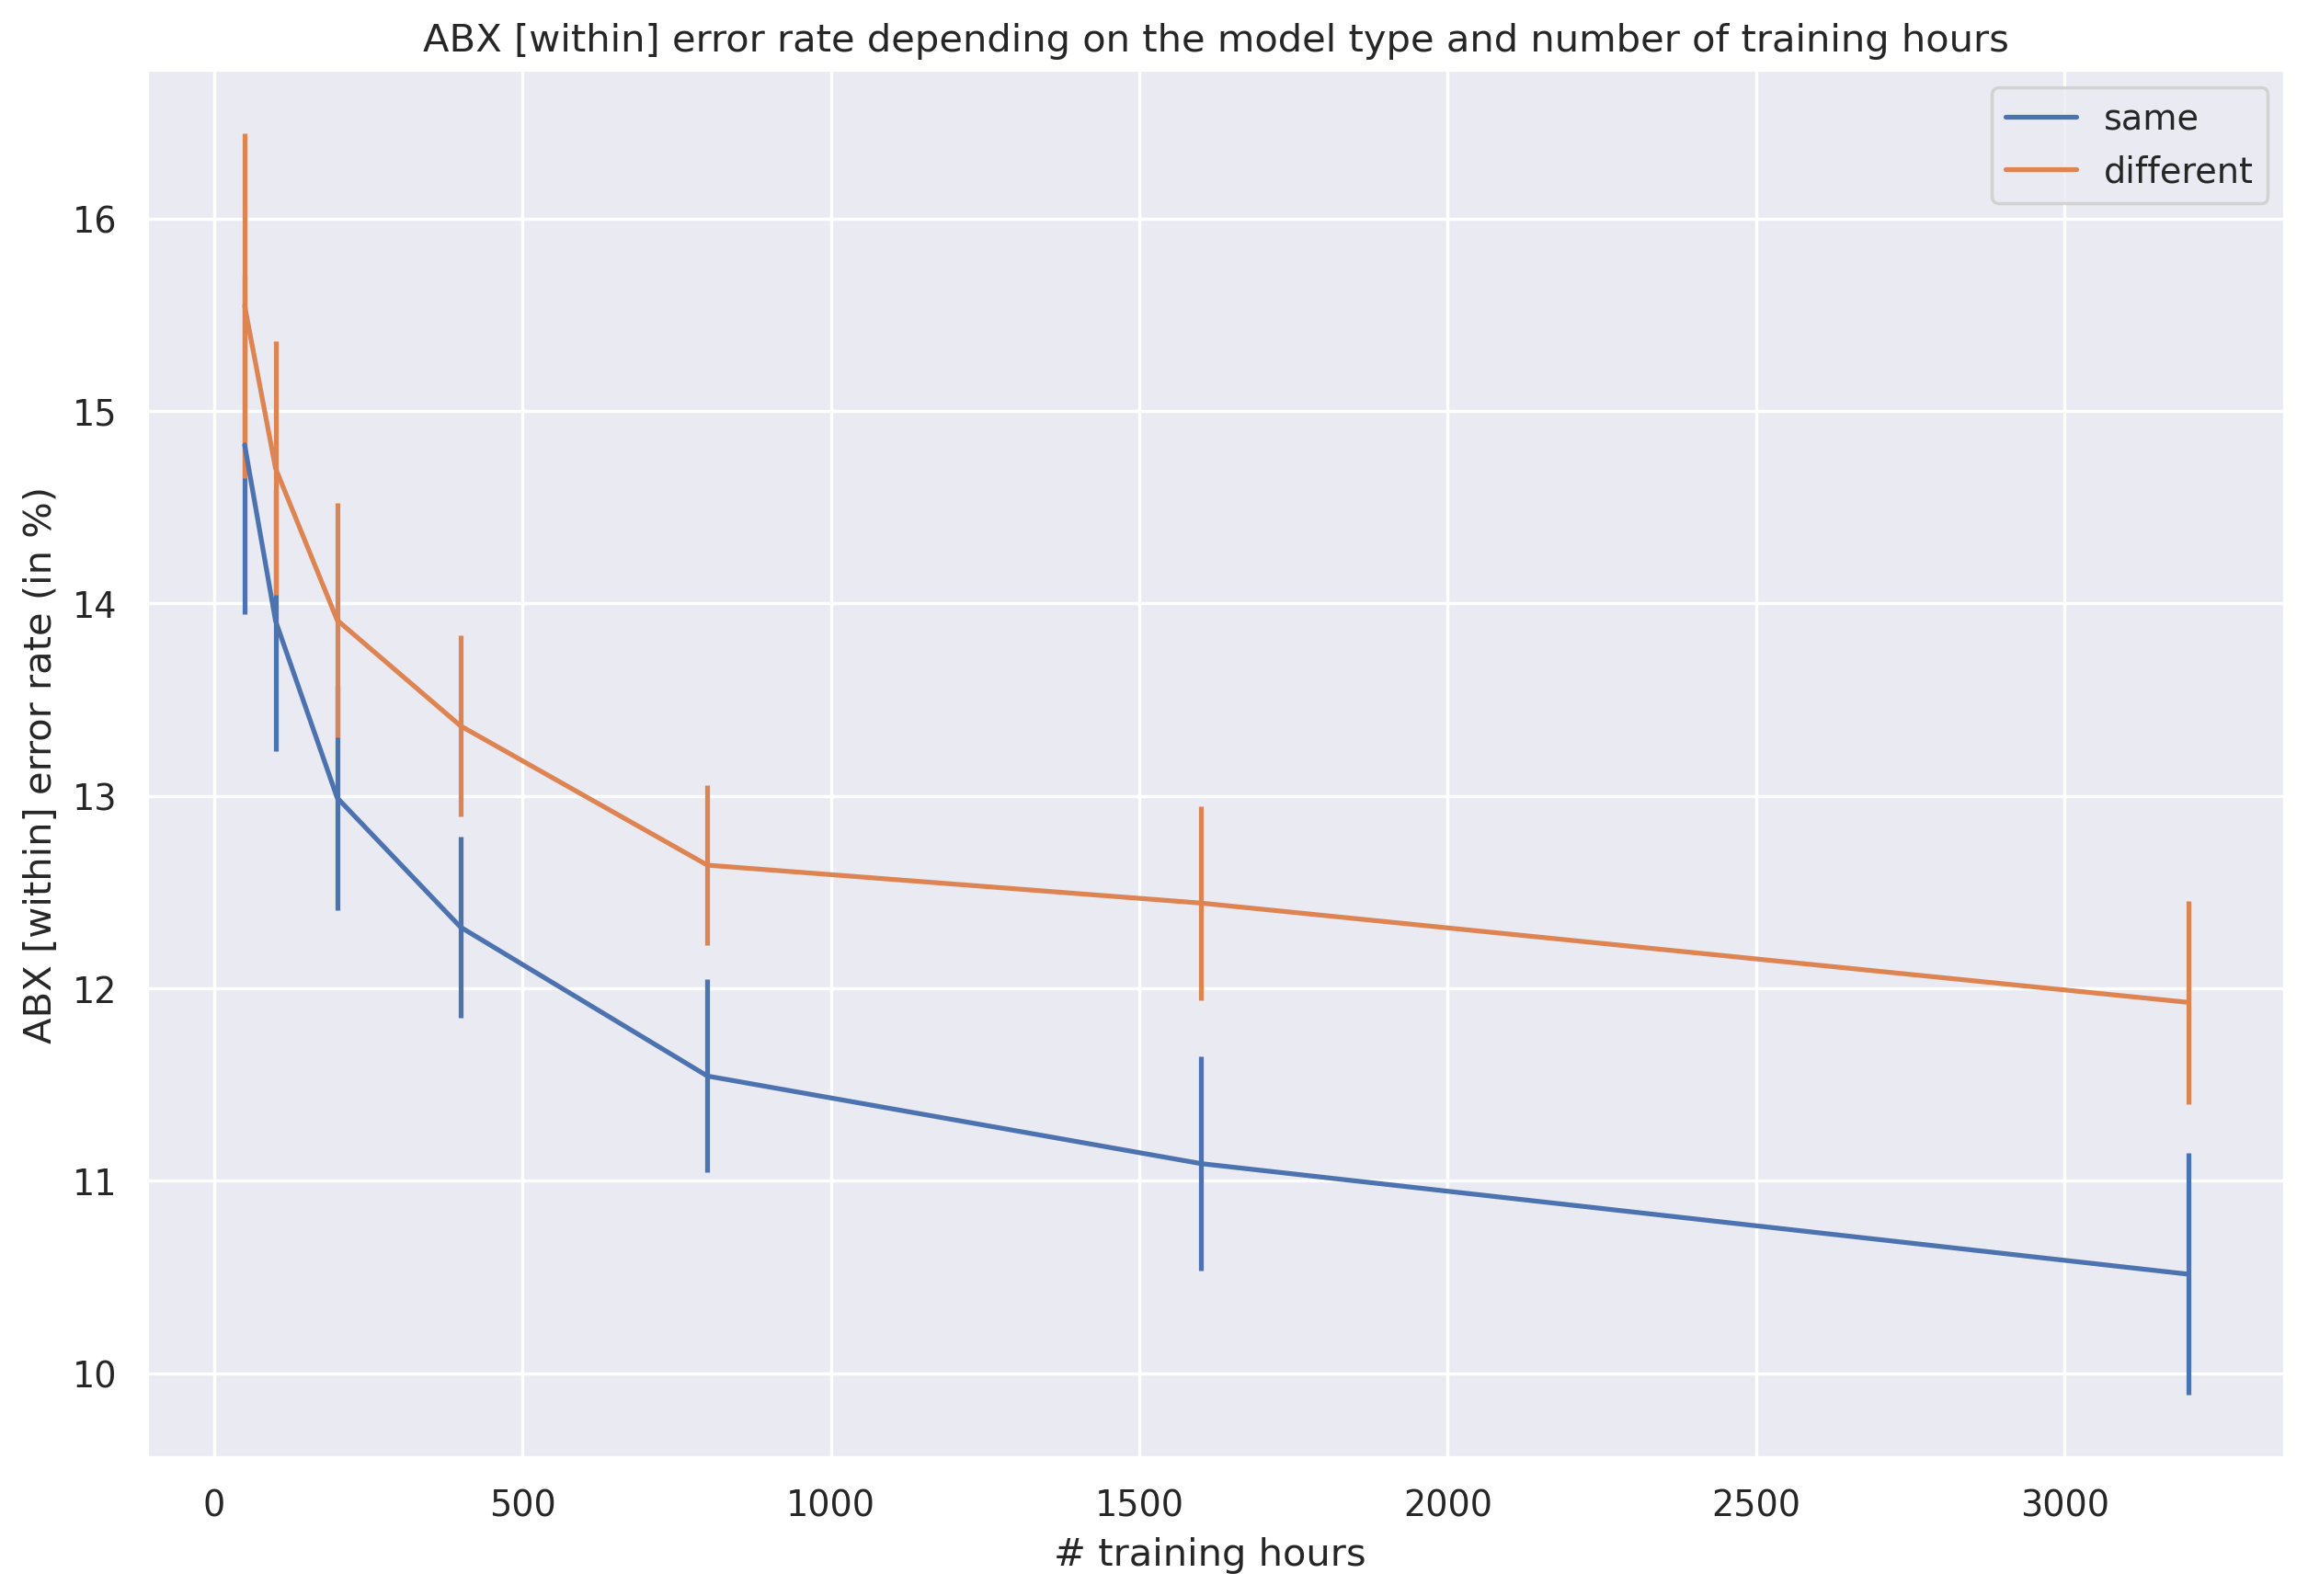

In [17]:
#doesn't work as this is not split by same vs different?

#df_within_size[['bil_totalsize']].plot(style = style_dict)
df_within_size[['same', 'different']].plot(style = style_dict, yerr=err_within[['same', 'different']])


plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")


(10, 21)

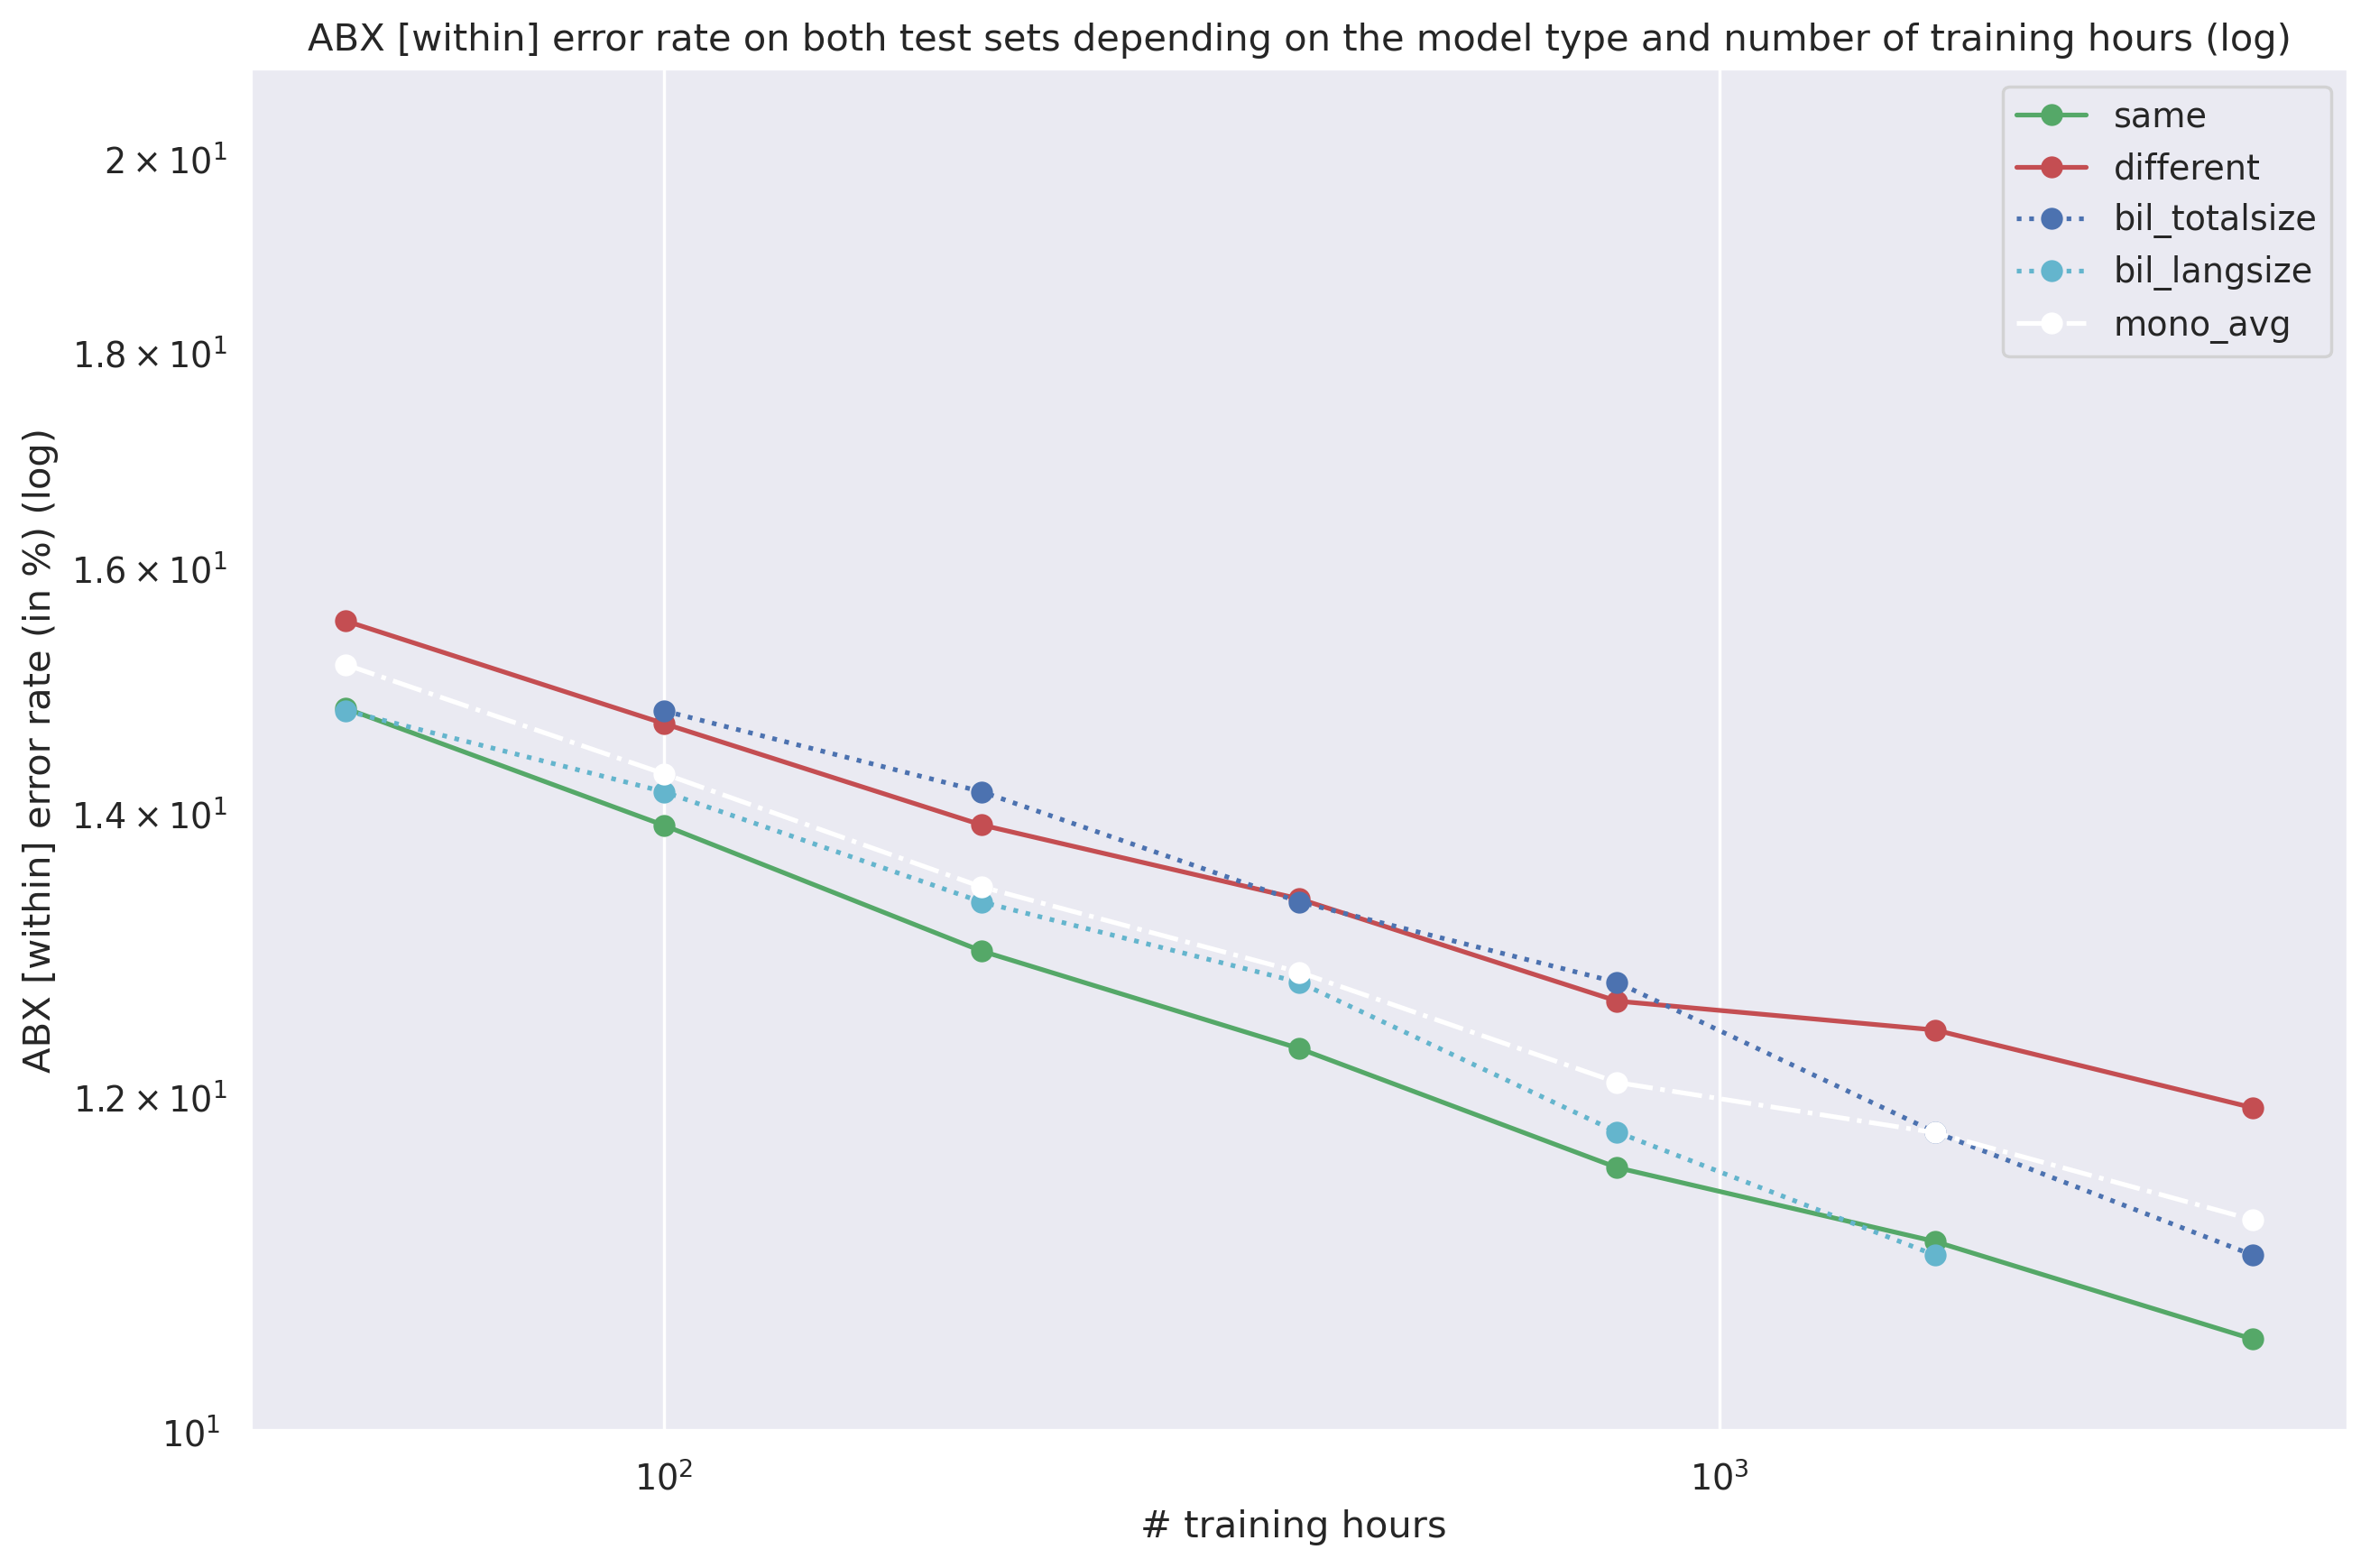

In [50]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_within_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %) (log)")
plt.title("ABX [within] error rate on both test sets depending on the model type and number of training hours (log)")
plt.ylim([10,21])

(12, 21)

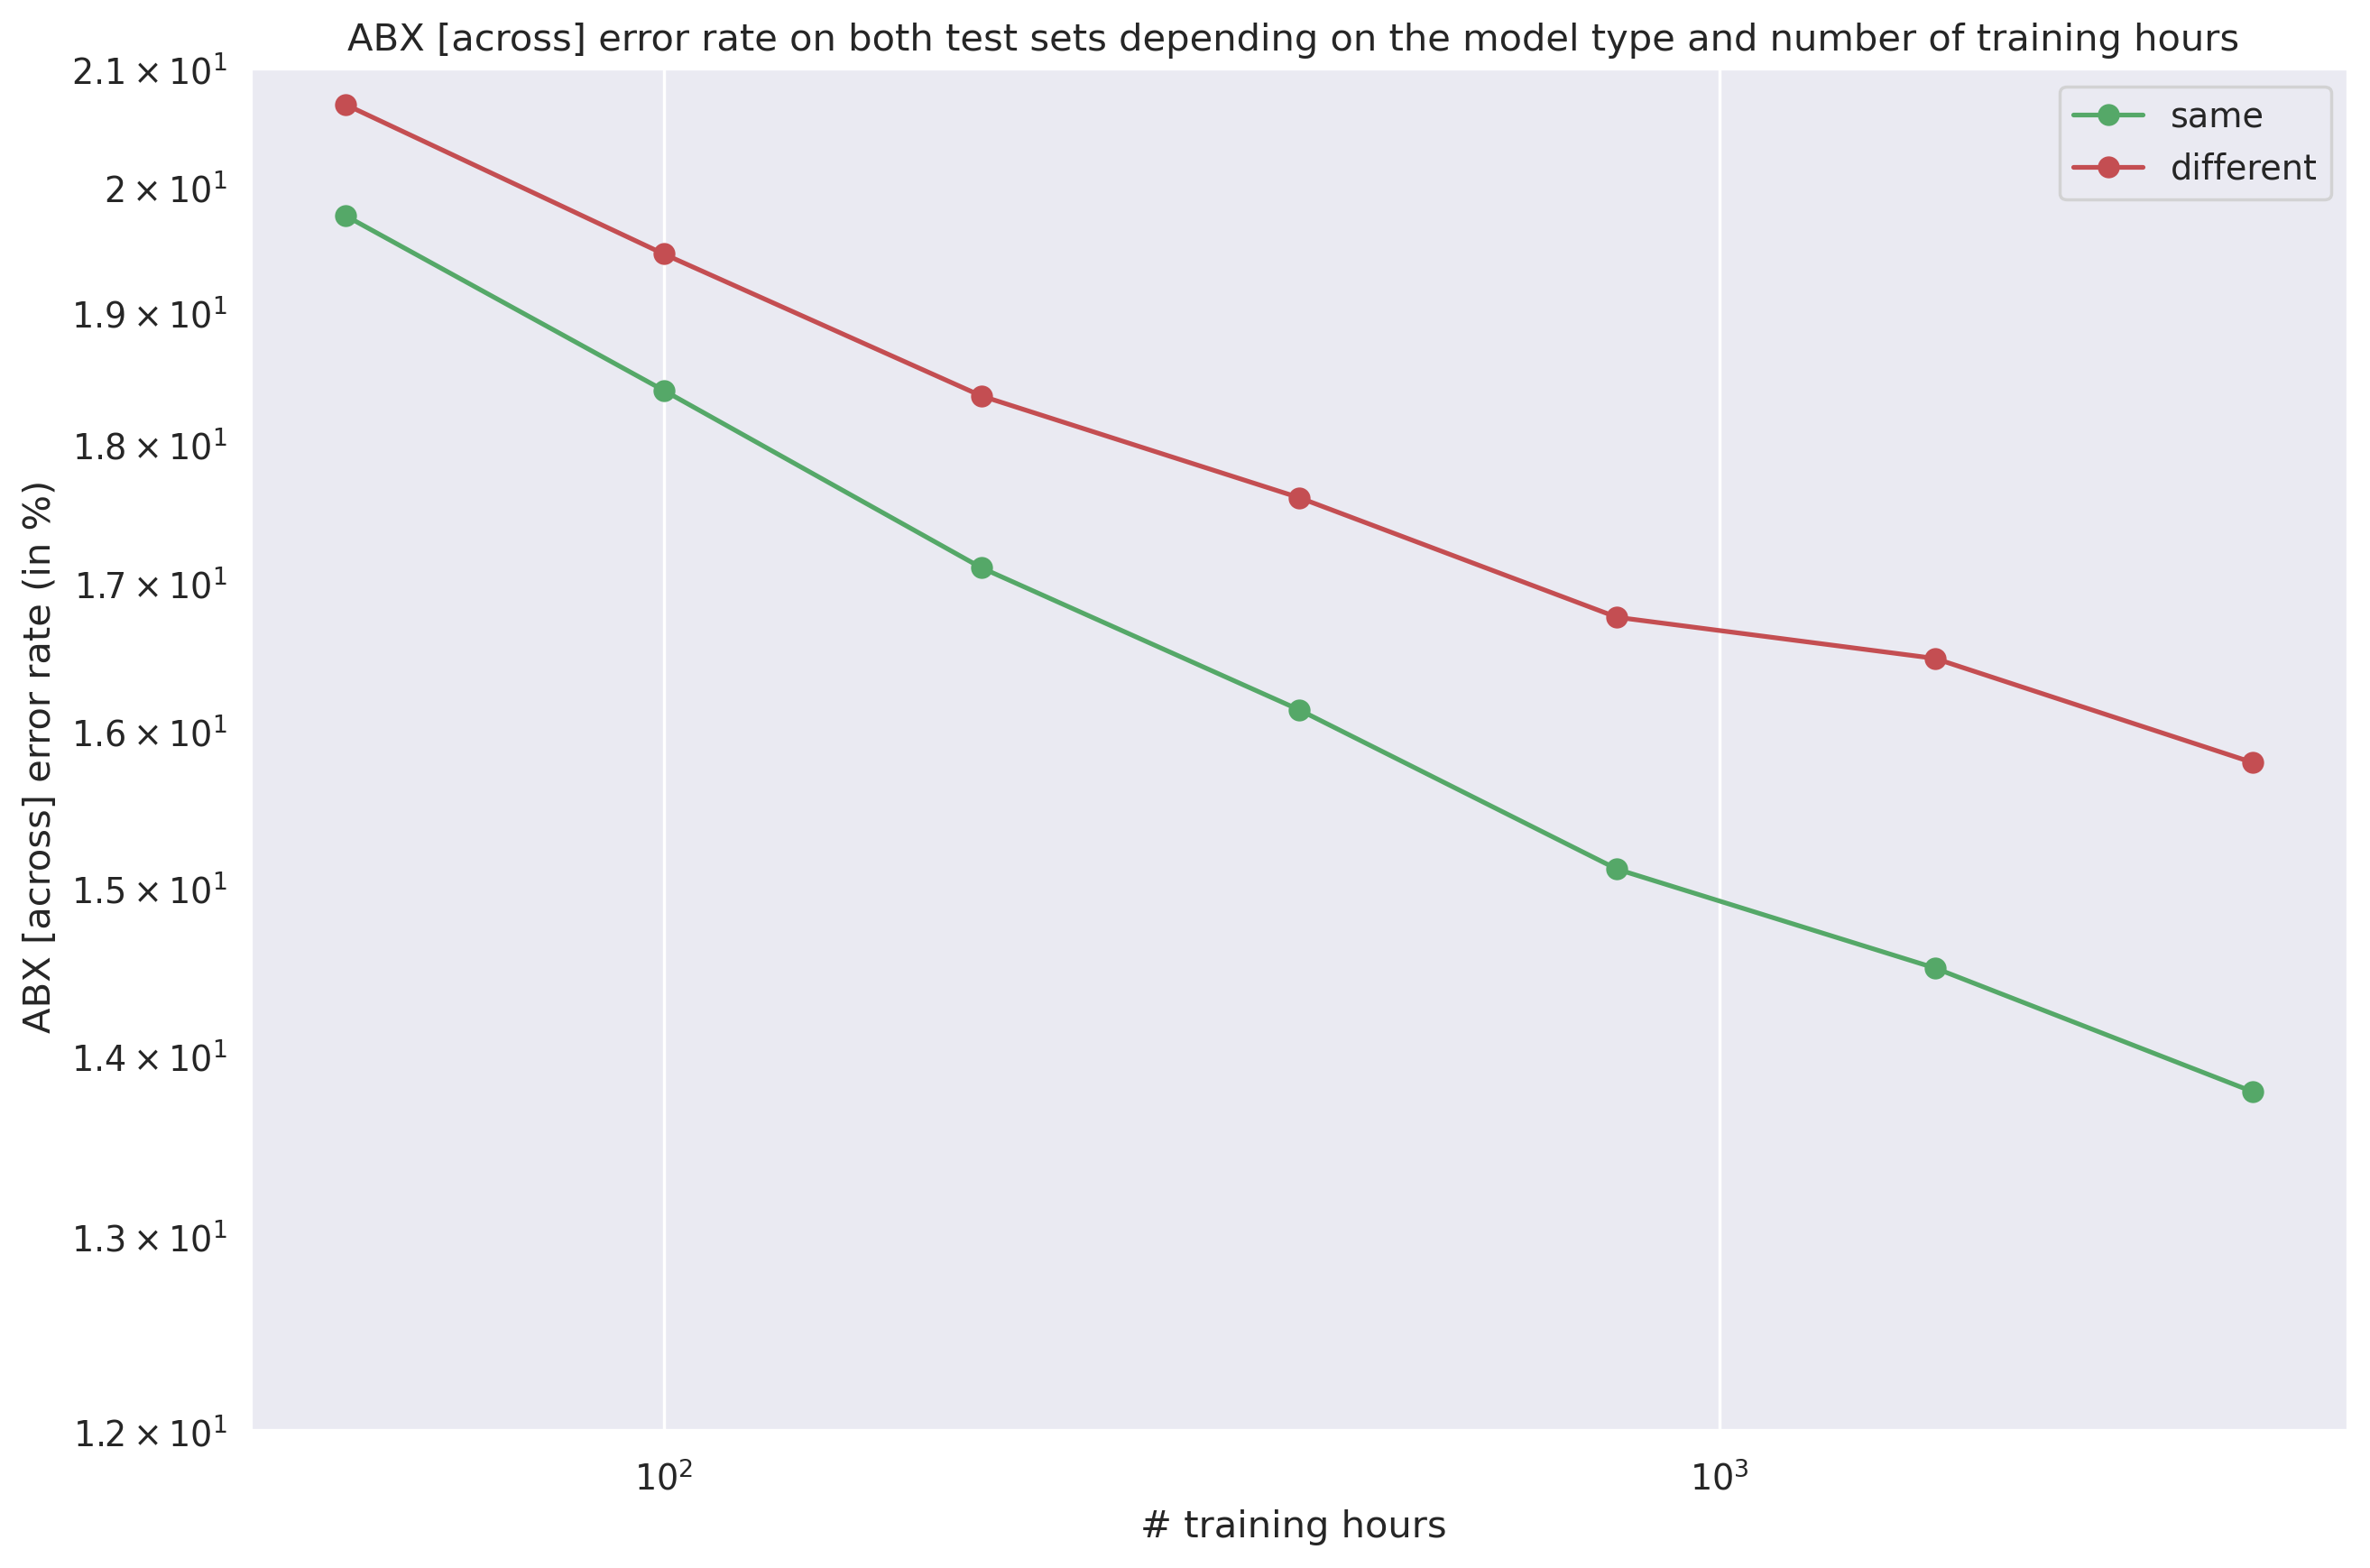

In [47]:
#df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) ")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours ")
plt.ylim([10,21])

(10, 21)

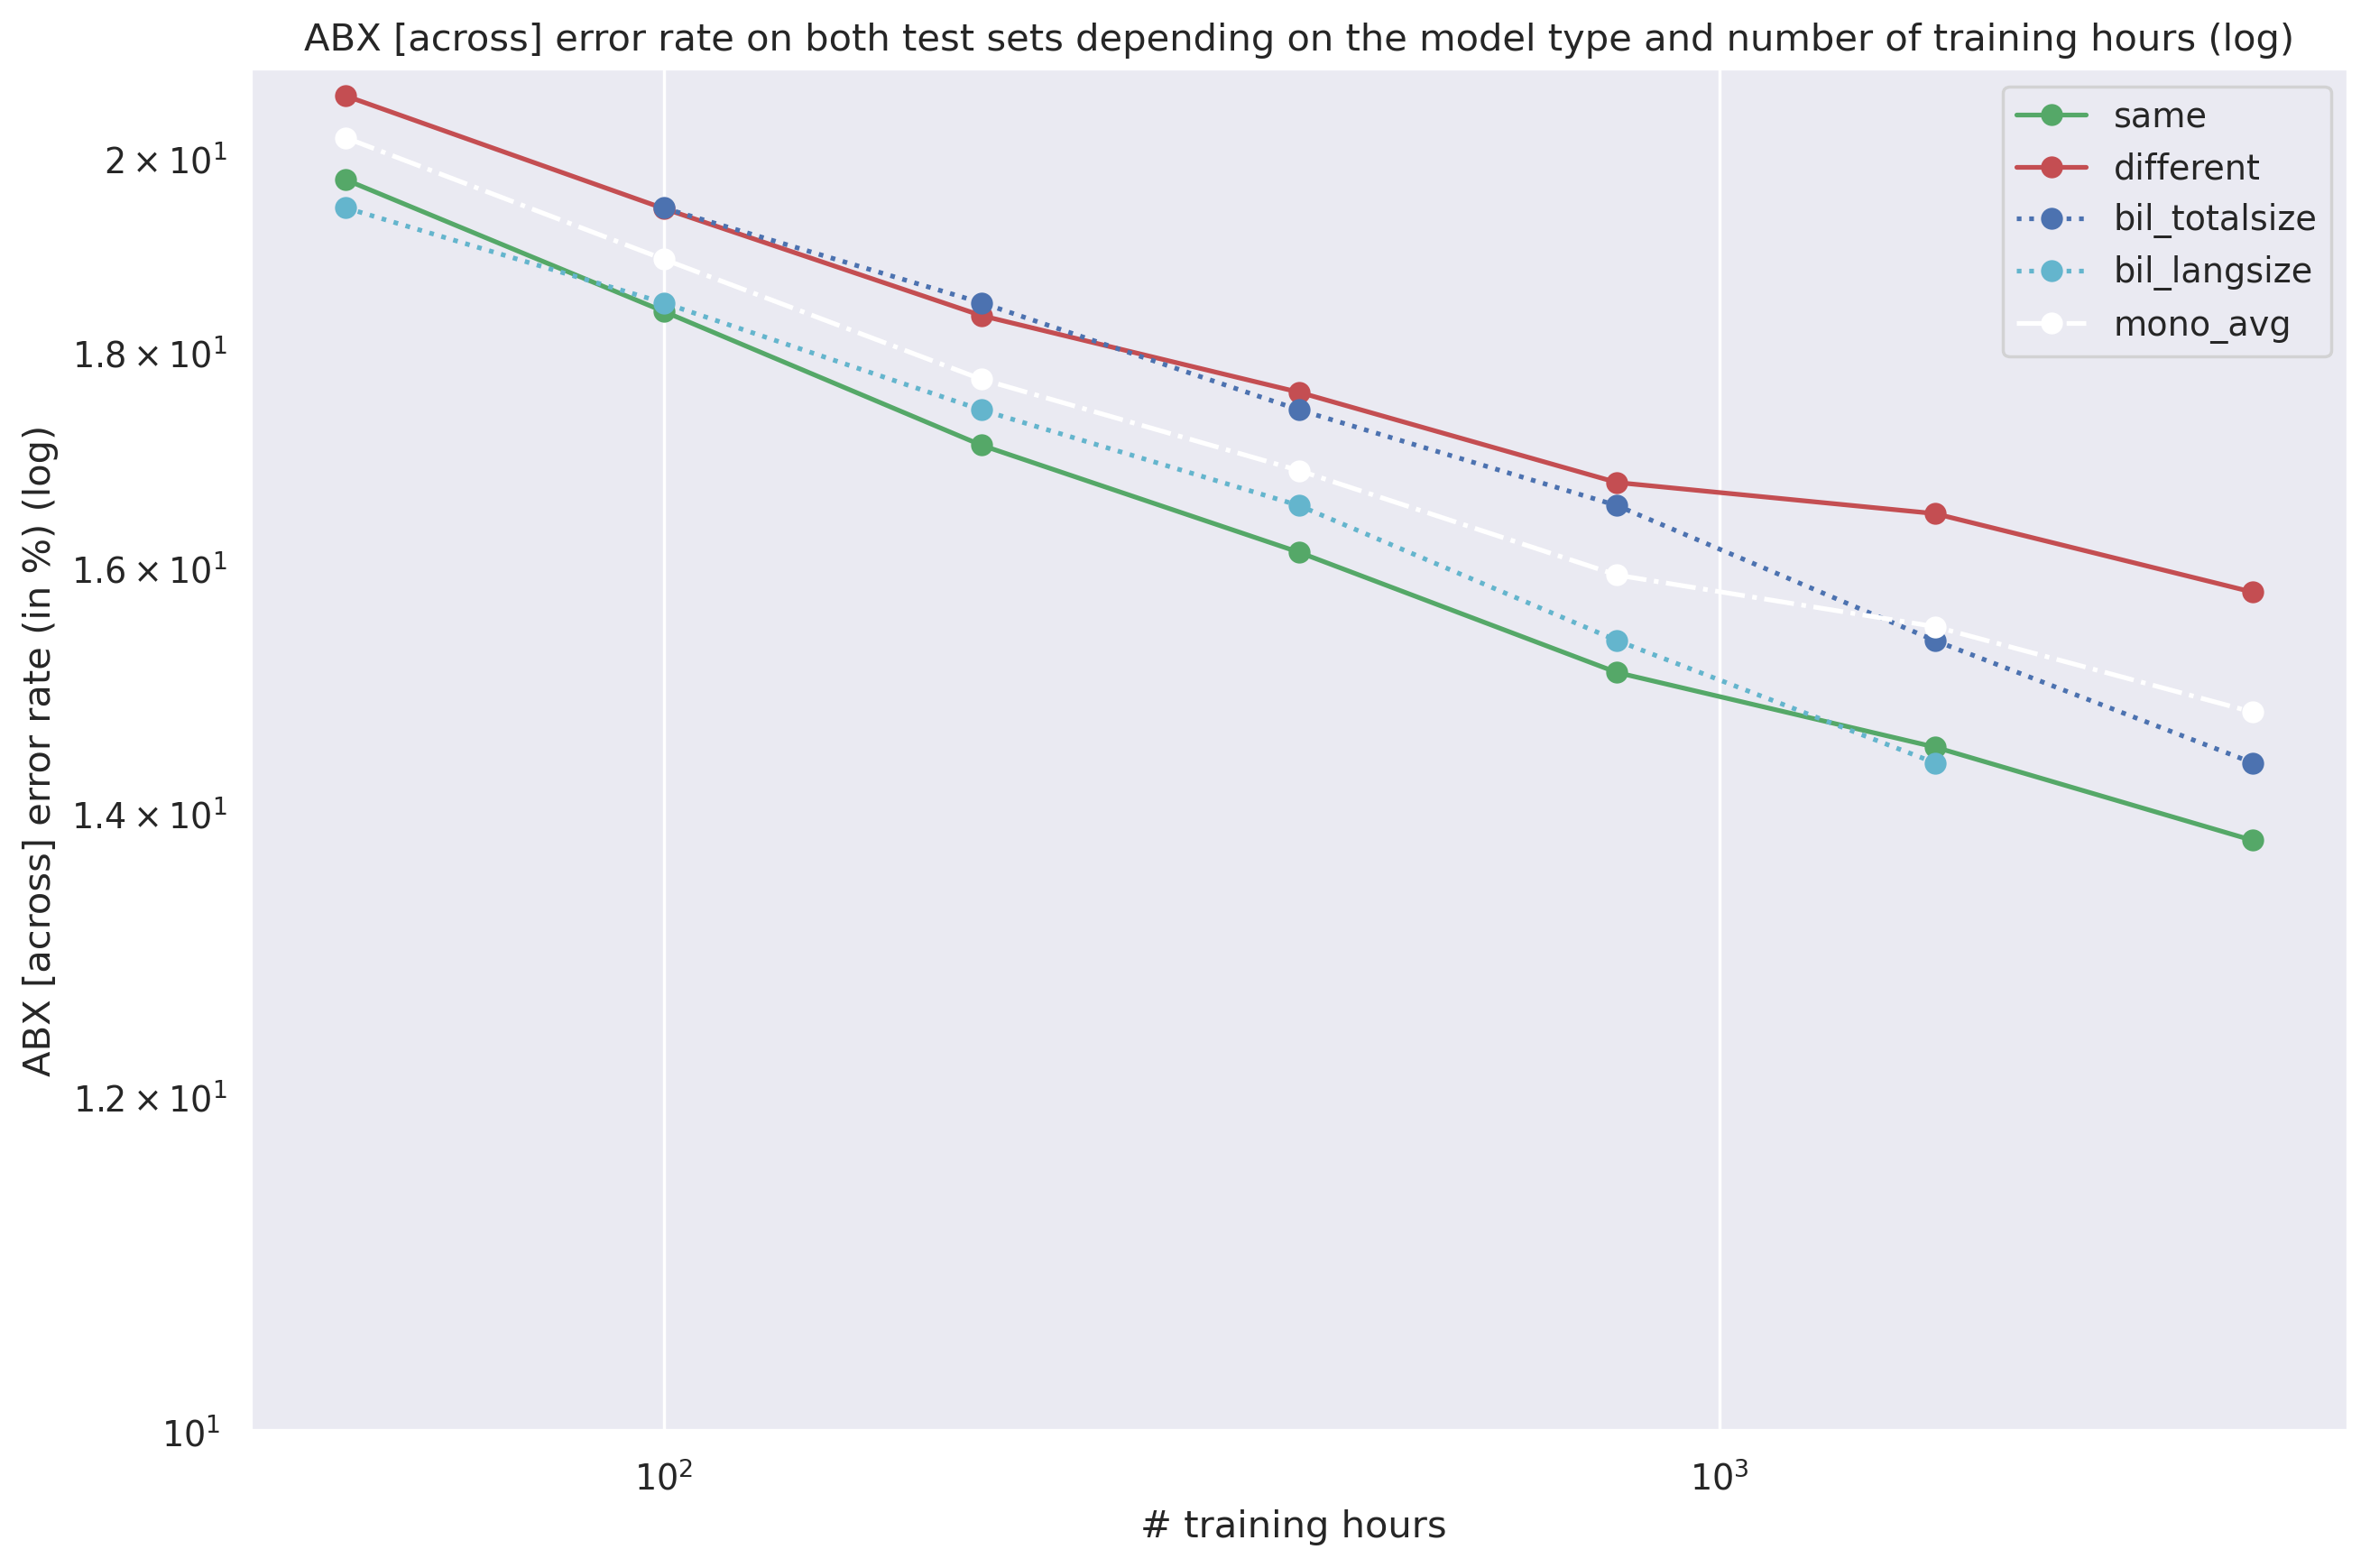

In [51]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) (log)")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours (log)")
plt.ylim([10,21])

### D3a. Developmental [within] ABX  on the French test set 

Text(0.5, 1.0, 'ABX [within] error rate on the FRENCH evaluation set')

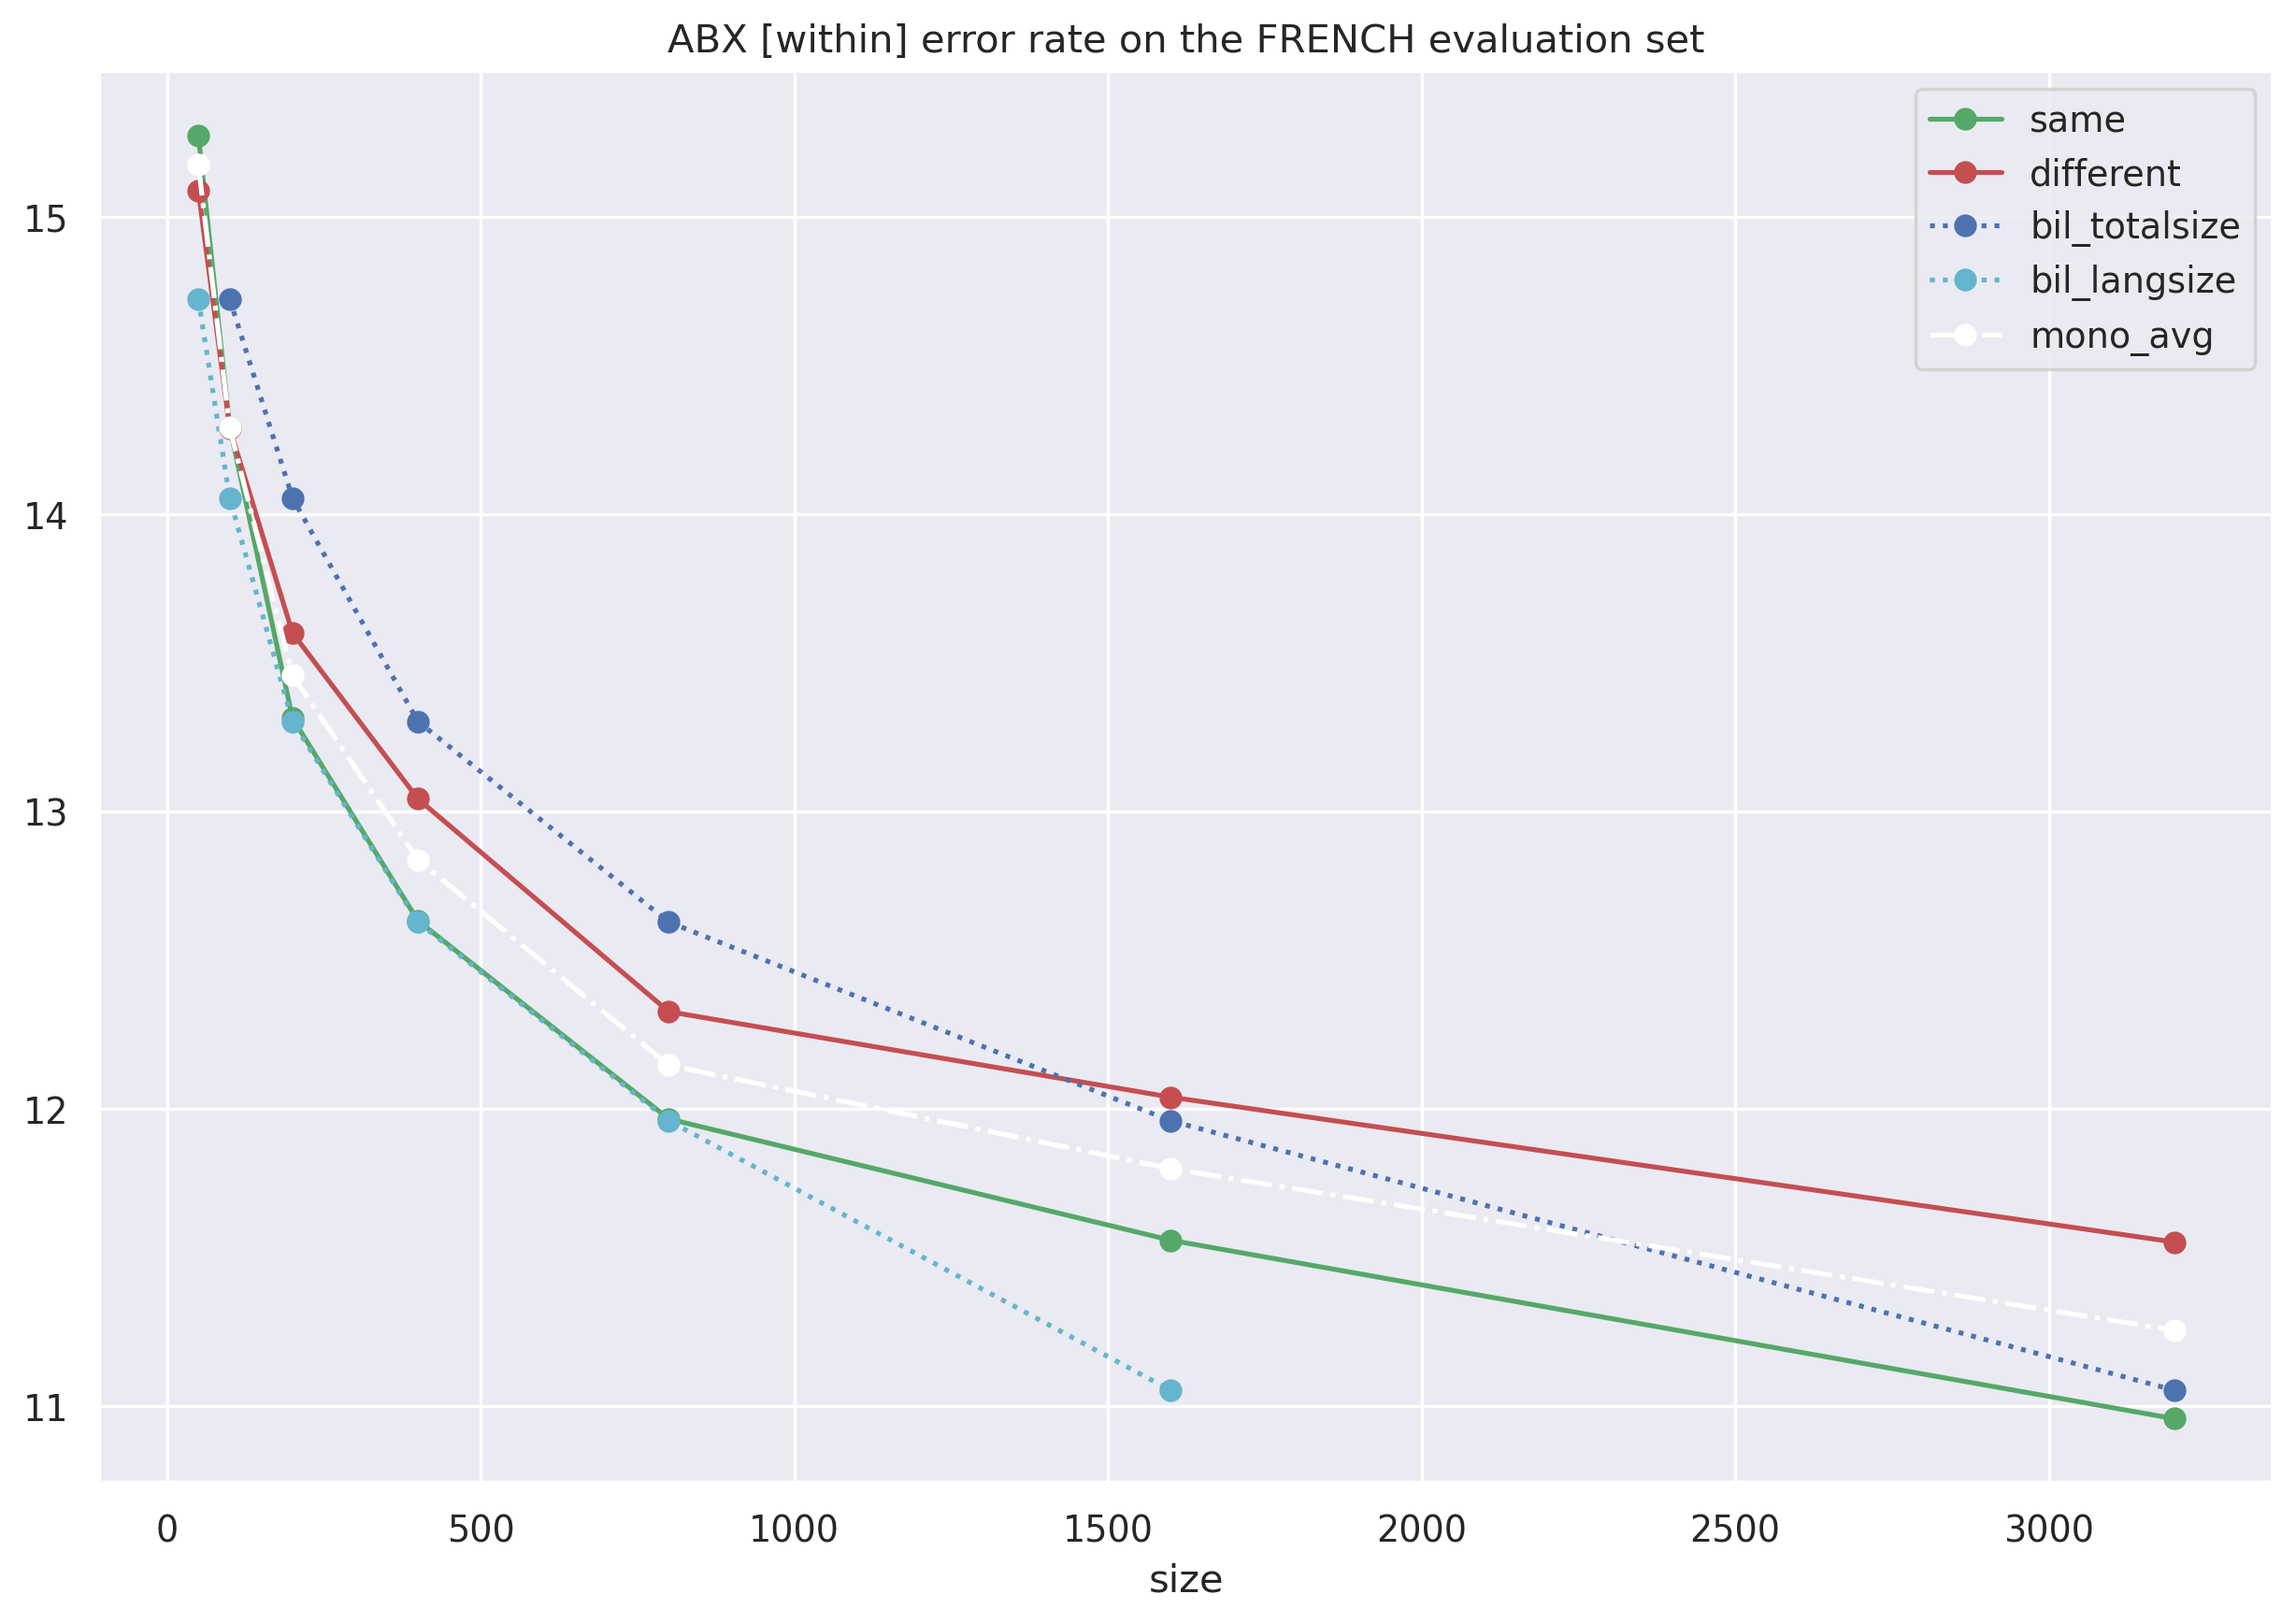

In [39]:
l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate on the FRENCH evaluation set")


### D3c. Developmental [within] ABX  on the French test set - Loglog scale

(10, 17)

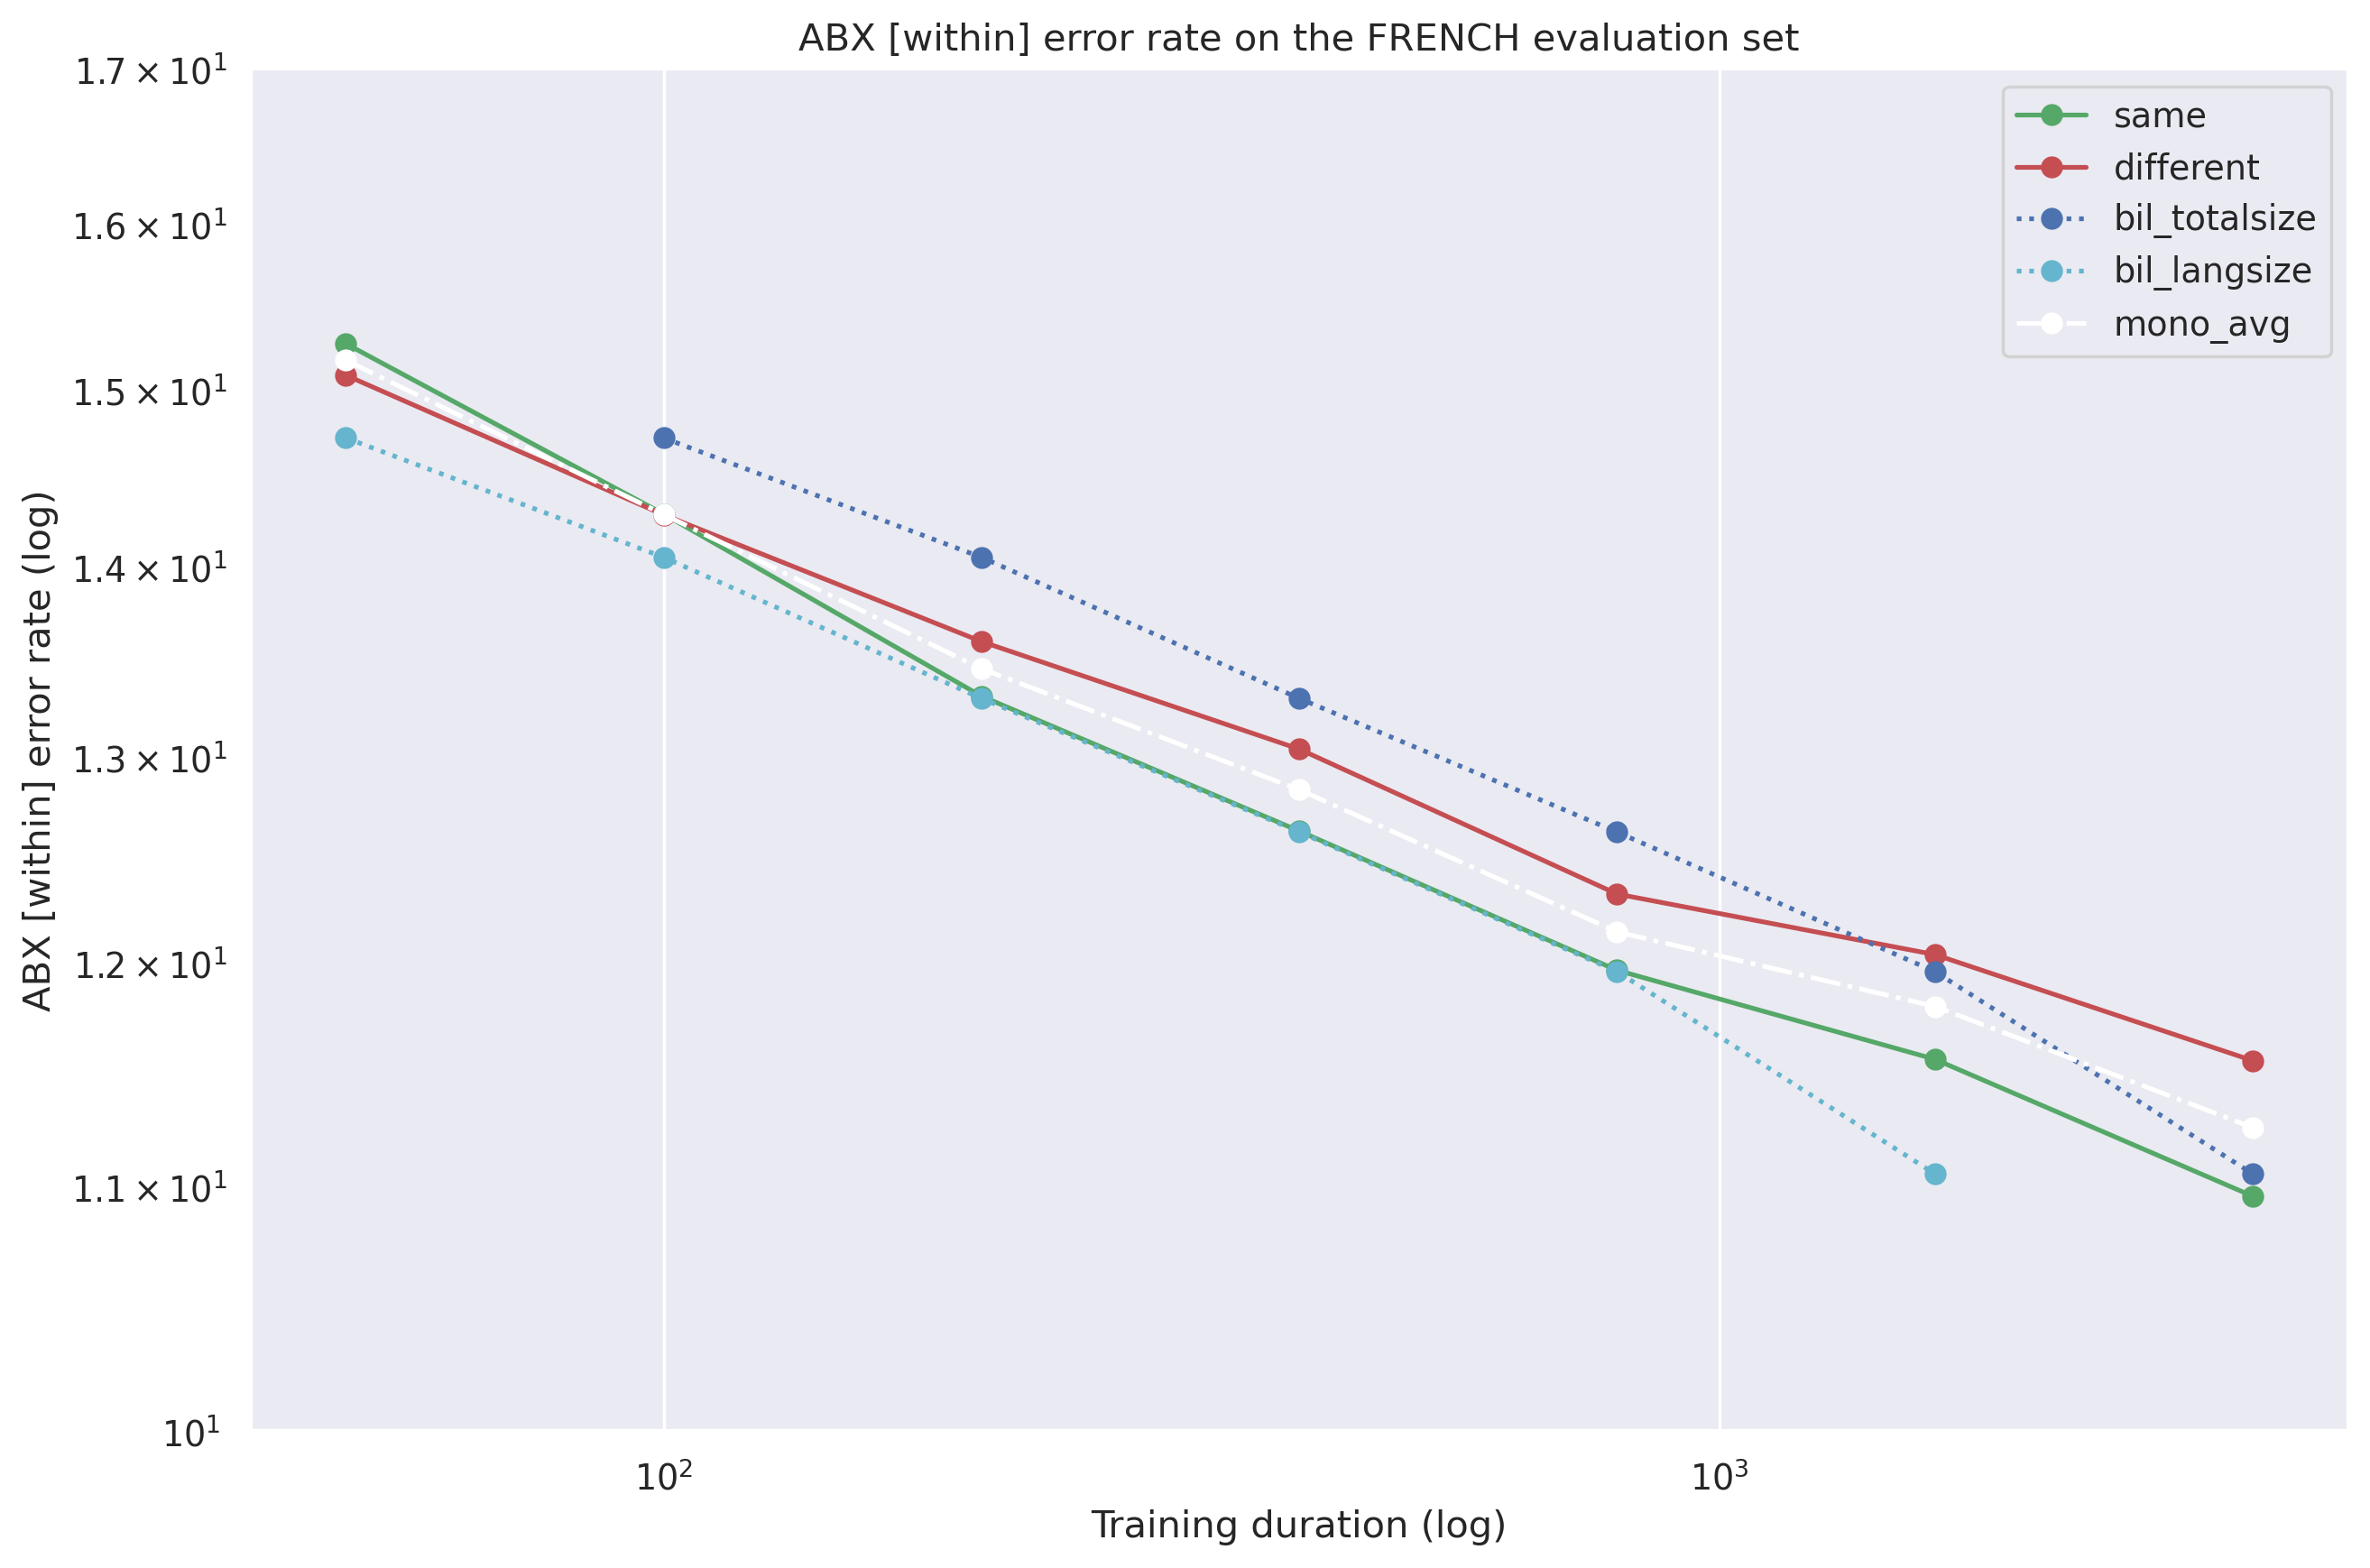

In [55]:
#log

l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set

(10.0, 17.0)

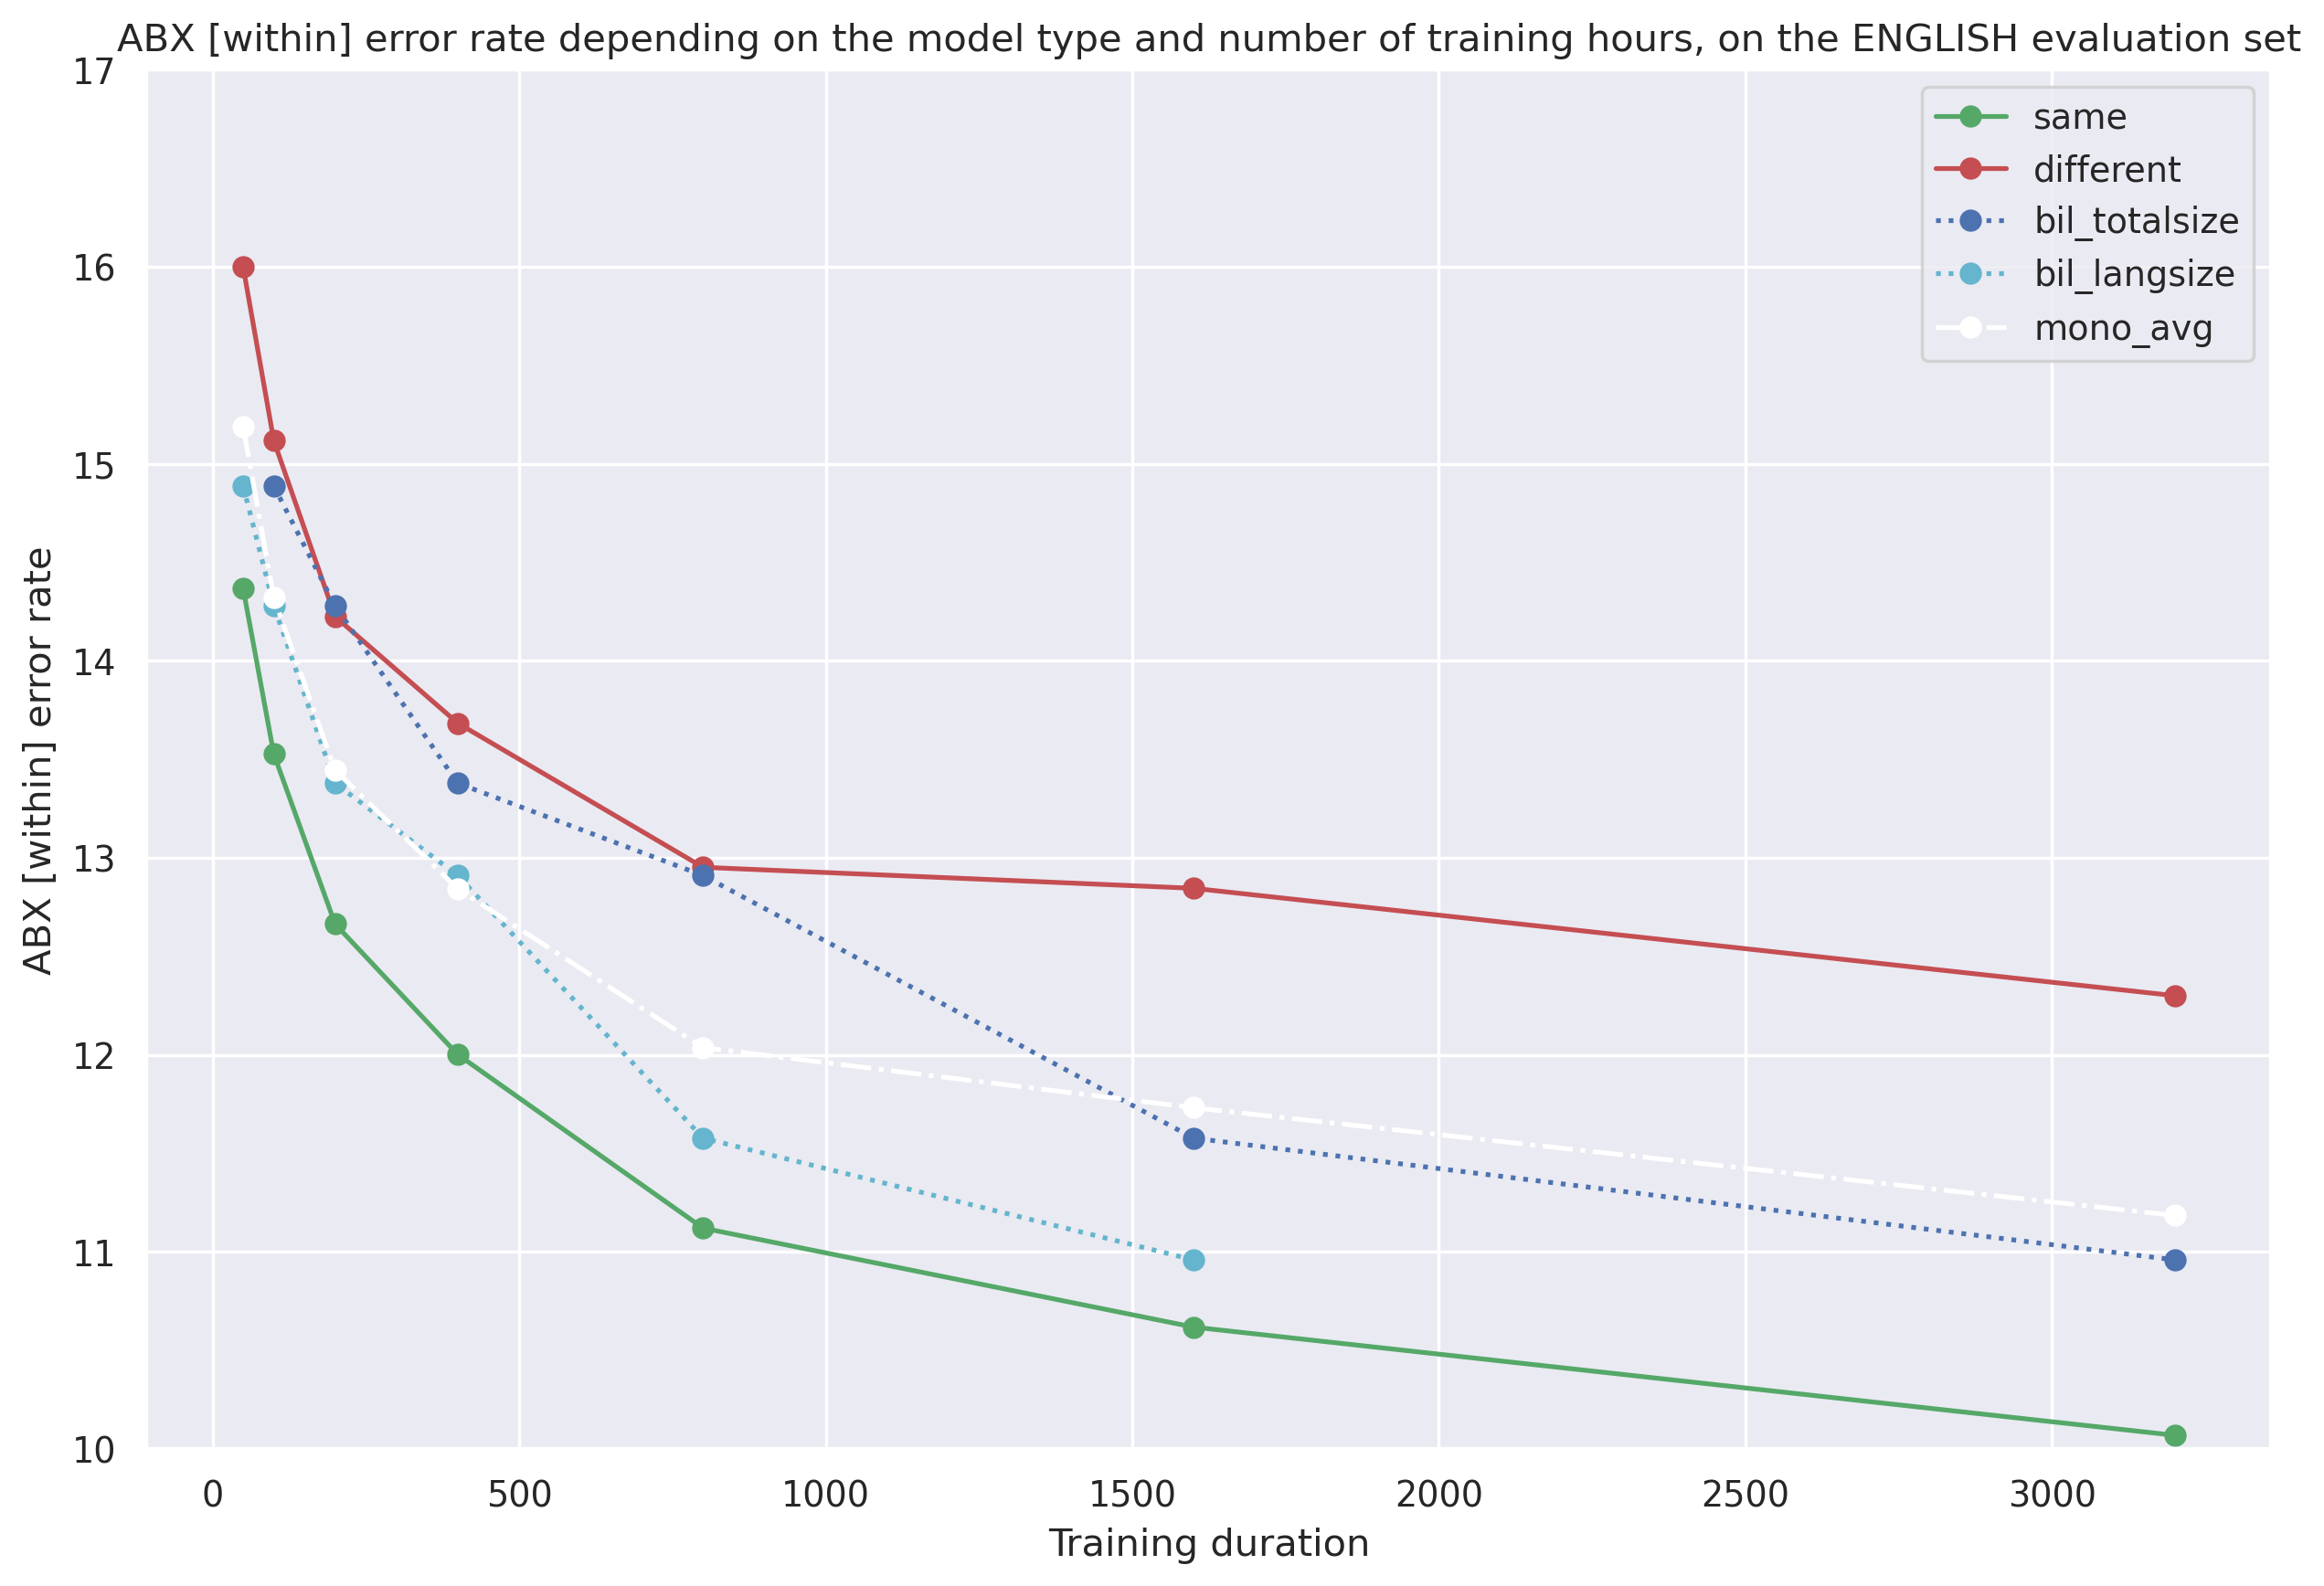

In [56]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration")
plt.ylabel("ABX [within] error rate")
plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set - loglog scale

(10, 17)

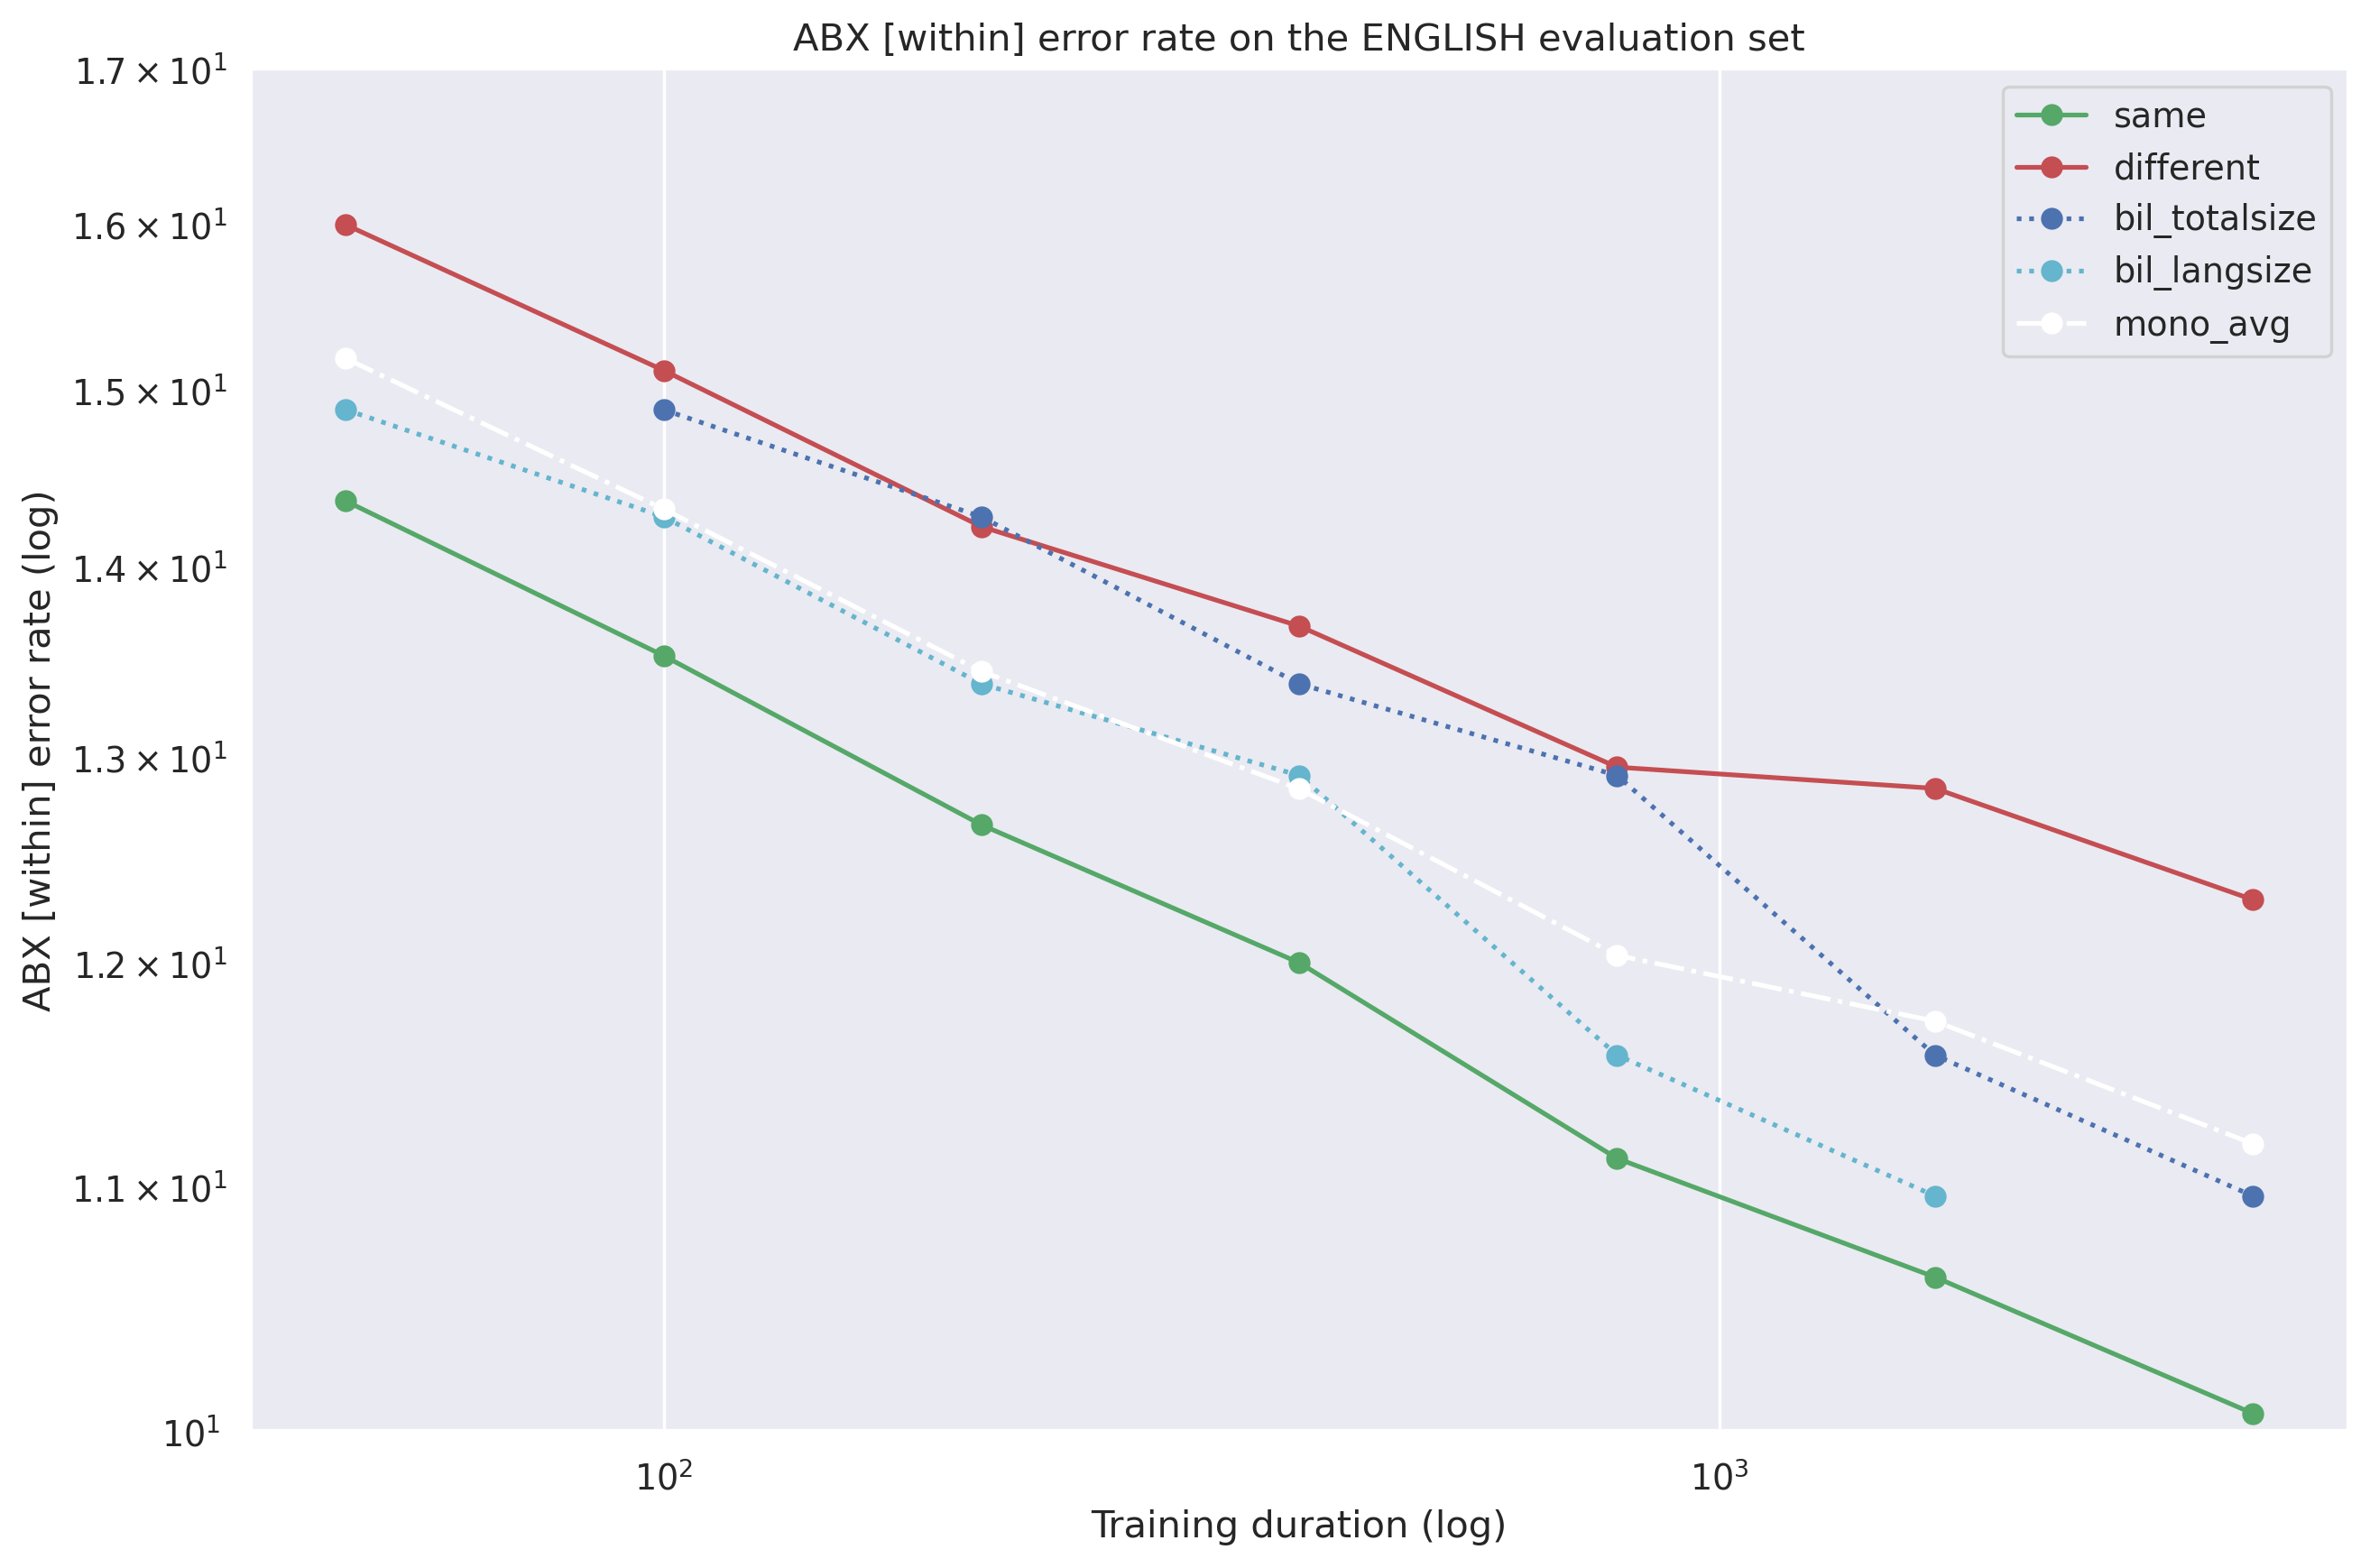

In [57]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
plt.ylim([10,17])

### D5. Developmental [across] ABX  on the French test set (original and QuickFix) - LogLog

(12, 21)

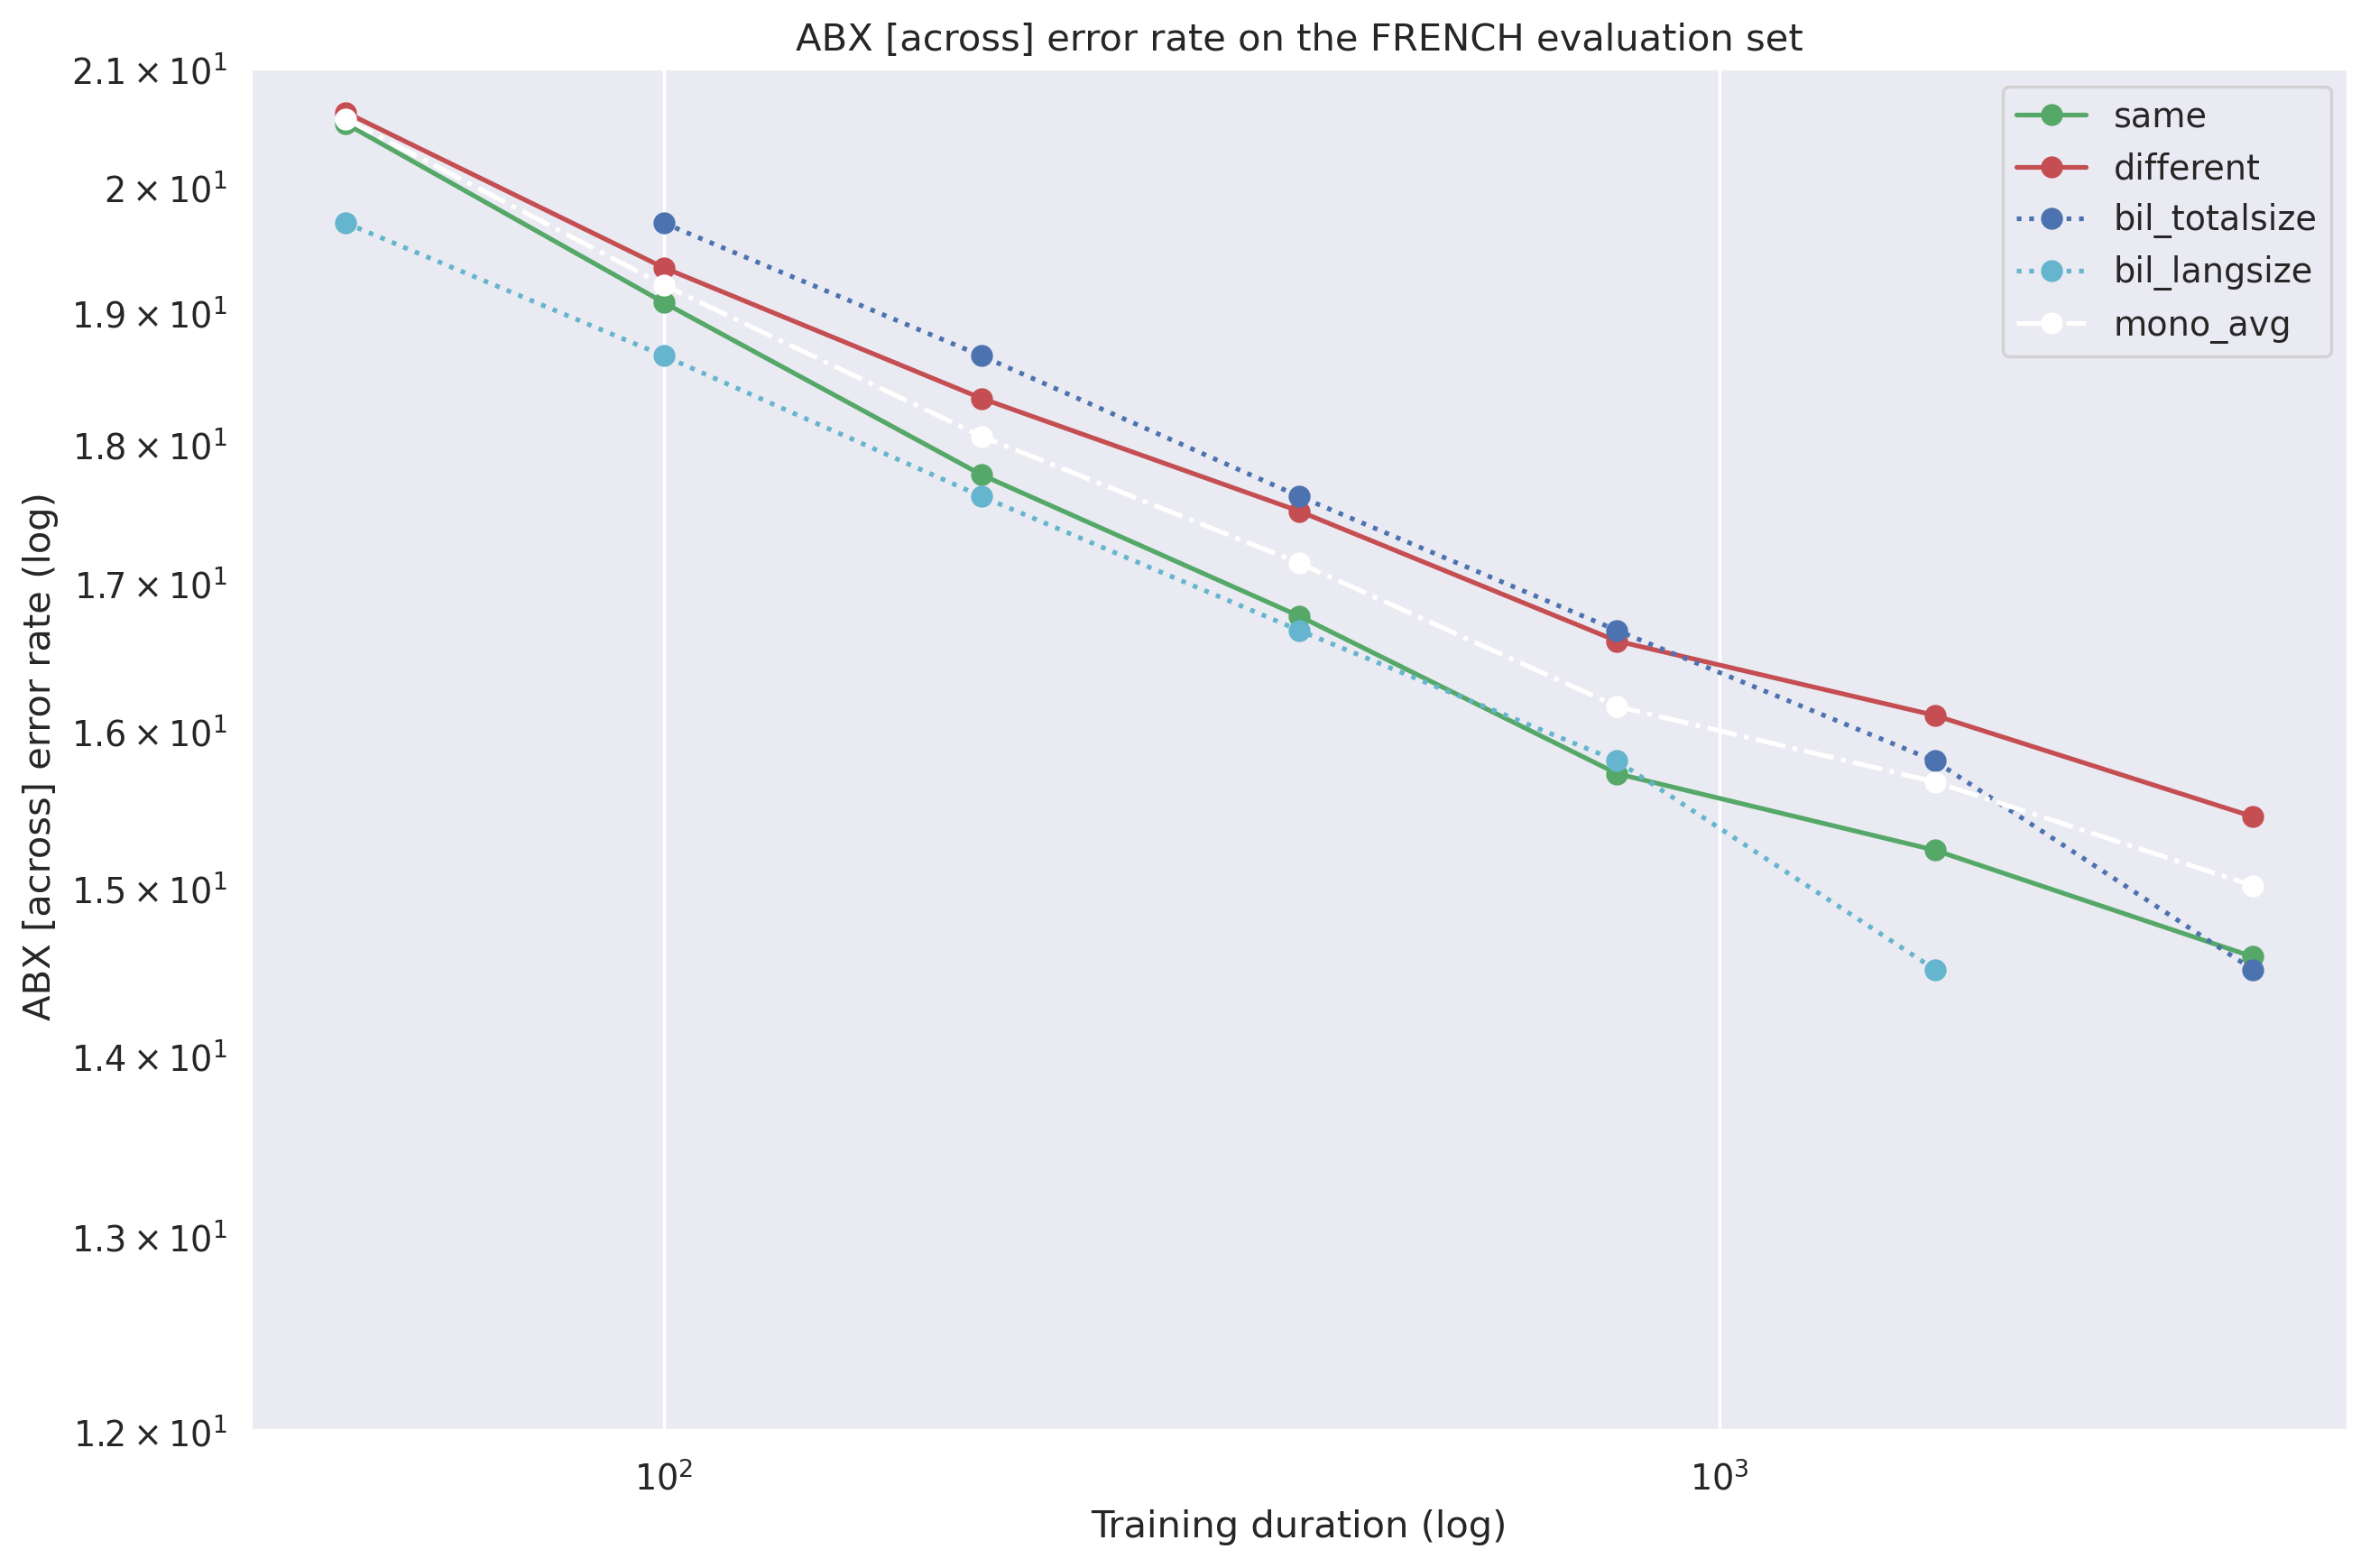

In [58]:
l="fr"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
plt.title("ABX [across] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log) ")
plt.ylim([12,21])


### D6. Developmental [across] ABX  on the English test set (original and QuickFix) - LogLog

(12, 21)

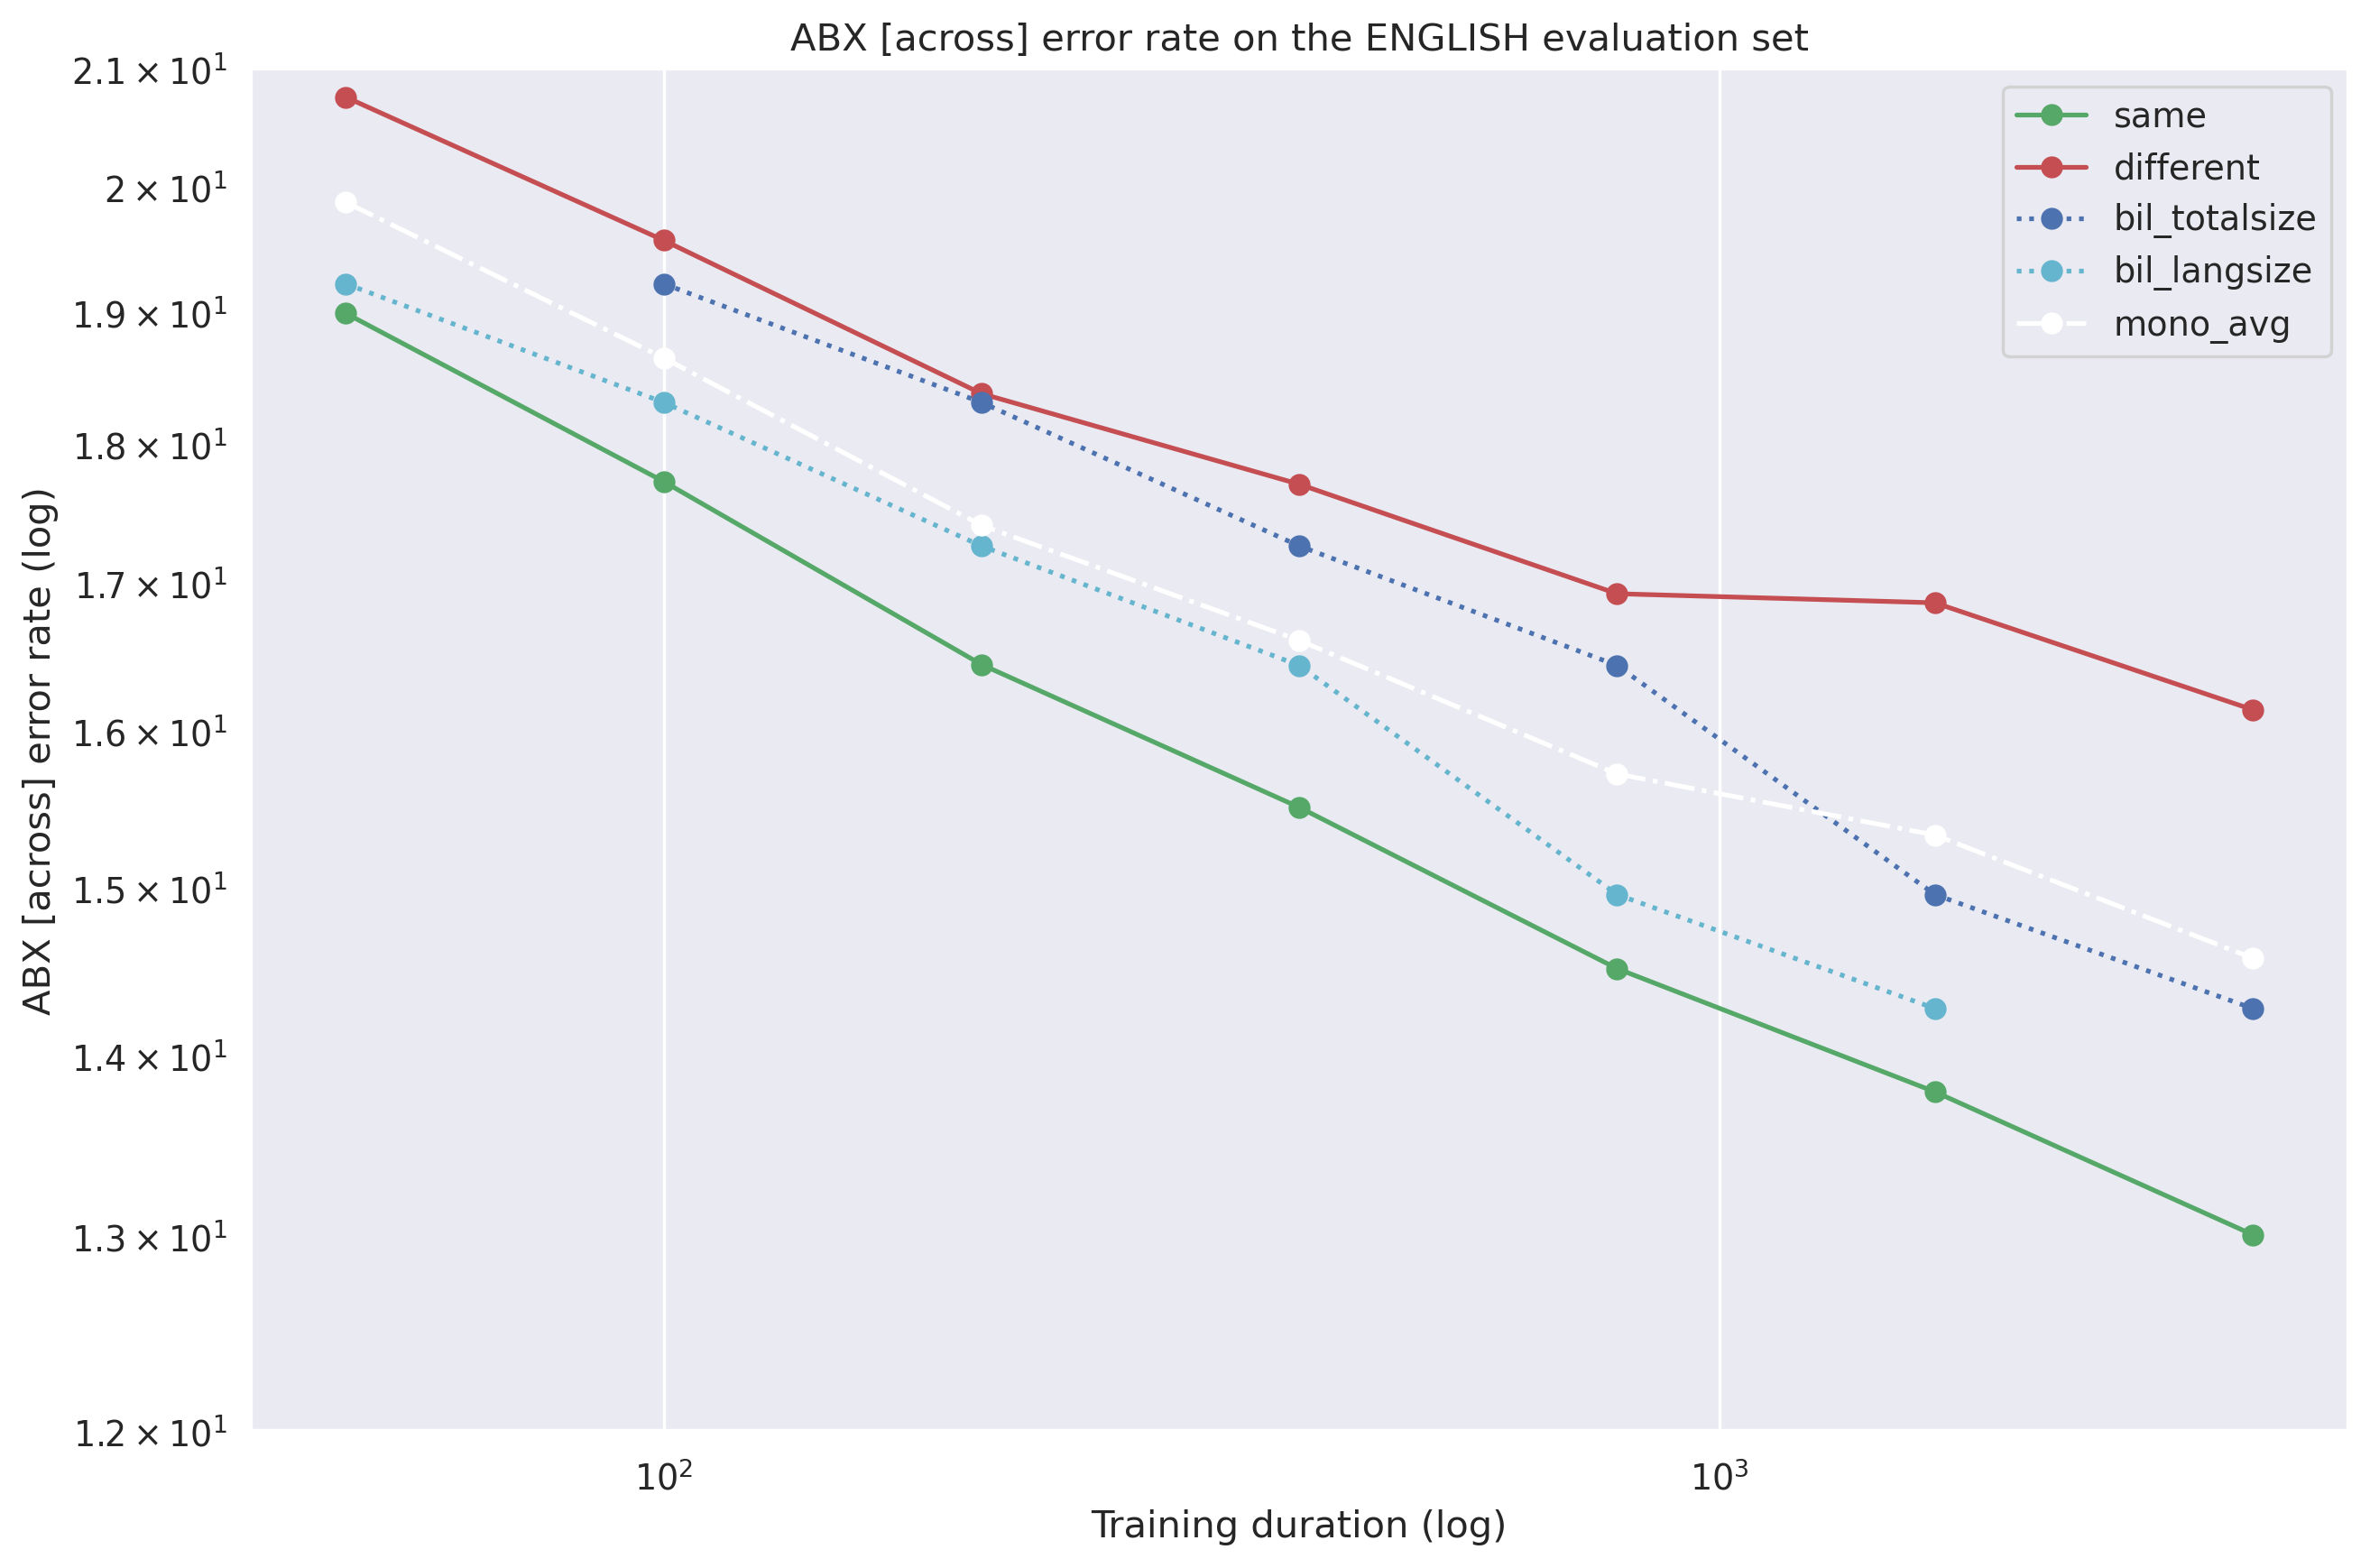

In [59]:
l="en"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [across] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log)")
plt.ylim([12,21])

###  Calculating Relative Advantage per data doubling :
Eg There is a **x** improvement when we double the data

In [60]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df

en_model   fr_model  bil_totalsize_A  bil_totalsize_B       same  \
size                                                                      
50    15.088224  15.274519              NaN              NaN  15.274519   
100   14.289648  14.293849        14.749834        14.698675  14.293849   
200   13.601602  13.315064        14.046220        14.064089  13.315064   
400   13.043336  12.633563        13.368592        13.238365  12.633563   
800   12.327646  11.966870        12.600117        12.657412  11.966870   
1600  12.040206  11.559099        11.946445        11.974936  11.559099   
3200  11.552946  10.958823        10.713123        11.395957  10.958823   

      different  bil_langsize  bil_totalsize   mono_avg  
size                                                     
50    15.088224     14.724254            NaN  15.176317  
100   14.289648     14.055155      14.724254  14.291748  
200   13.601602     13.303479      14.055155  13.458333  
400   13.043336     12.628765      13.303479  12.838450  
800   12.327646     11.960690      12.628765  12.147258  
1600  12.040206     11.054540      11.960690  11.799653  
3200  11.552946           NaN      11.054540  11.255885

In [61]:
df = df_within.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.560031350311017
different -4.312063376191741
bil_langsize -5.746842769022429
bil_totalsize -5.746842769022429


In [62]:
df = df_across.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.813716046471302
different -4.393908463949181
bil_langsize -5.861770928166684
bil_totalsize -5.861770928166684


In [67]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.3773216807802795
different -4.3462903889236895
bil_langsize -5.566025291012056
bil_totalsize -5.566025291012056


In [68]:
l="en"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.745974282867377
different -4.2712493683893795
bil_langsize -5.909174254004263
bil_totalsize -5.909174254004263


In [65]:
l="fr"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.533165996339039
different -4.701583956696216
bil_langsize -5.941473705435202
bil_totalsize -5.941473705435202


In [66]:
l="en"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -6.1099149406949875
different -4.089165783494153
bil_langsize -5.765200468956943
bil_totalsize -5.765200468956943
